In [7]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt

import quairkit as qkit
from quairkit import Circuit
from quairkit.database import *
from quairkit.qinfo import *

qkit.set_dtype('complex128')


## Construct LCQNN model

In [8]:
class RecursiveProbabilityDistribution(nn.Module):
    def __init__(self, depth):
        """
        初始化递归概率分布生成器
        :param depth: 递归深度 t，决定概率分布的元素数量 (2^t)
        """
        super().__init__()
        self.depth = depth
        self.n_angles = (2 ** depth) - 1  # 计算所需角度参数总数
        # 初始化角度参数 (使用均匀分布初始化)
        self.angles = nn.Parameter(torch.rand(self.n_angles, dtype=torch.float64) * np.pi * 2)
        
    
    def forward(self):
        """生成概率分布 (长度为 2^t)"""
        # 递归生成函数 (内部实现)
        def _recursive_generator(current_depth, start_idx):
            if current_depth == 1:
                # 基础情况：返回单个角度的 cos 和 sin
                a = self.angles[start_idx]
                return torch.stack([torch.cos(a/2), torch.sin(a/2)])
            else:
                # 递归情况：处理上一层的结果
                prev = _recursive_generator(current_depth - 1, start_idx)
                # 当前层需要的角度参数数量
                n_angles_this_layer = 2 ** (current_depth - 1)
                # 当前层角度参数的起始位置
                next_idx = start_idx + (2 ** (current_depth - 1) - 1)
                # 获取当前层所有角度参数
                angles_layer = self.angles[next_idx : next_idx + n_angles_this_layer]
                
                # 为上一层的每个元素生成两个新元素
                new_elements = []
                for i, val in enumerate(prev):
                    a = angles_layer[i]
                    new_elements.append(val * torch.cos(a/2))
                    new_elements.append(val * torch.sin(a/2))
                return torch.stack(new_elements)
        
        # 启动递归生成过程
        return _recursive_generator(self.depth, 0)
    
    def get_probability_distribution(self):
        """获取当前概率分布 (L2 范数为 1)"""
        p = self.forward()
        return p*p
    

In [9]:
def lcqnn_model(n, L, k):
    lcqnn = torch.nn.Sequential()
    
    for j in range(L):
        cir_U = Circuit(n)
        
        start_idx = j % 2

        while start_idx<=n-1 and start_idx+k<=n:
            cir_U.complex_entangled_layer(qubits_idx=range(start_idx,start_idx+k), depth=3)
            # cir_U.real_entangled_layer(qubits_idx=range(start_idx,start_idx+k), depth=3)
            start_idx += k
        lcqnn.append(cir_U)
    

    t = int(np.ceil(np.log2(L)))
    if t==0:
        t += 1
    coef_model = RecursiveProbabilityDistribution(t)
    
    lcqnn.append(coef_model)
        
    return lcqnn


def get_cost(L, lcqnn, rho, O_list):
    prob = lcqnn[L].get_probability_distribution()
    cost = 0.0
    for O in O_list:
        for j in range(L):
            pj = prob[j]
            Uj = lcqnn[j].unitary_matrix()
            cost = cost + torch.real(torch.trace(Uj @ rho @ dagger(Uj) @ O)) * pj
    
    return cost / len(O_list)



\documentclass[border=2pt]{standalone}

% WARNING: please disable other quantum circuit packages, such as qcircuit
\usepackage{tikz}
\usetikzlibrary{quantikz2}

\begin{document}

\begin{quantikz}[transparent]
\lstick{} & \gate[1]{U(3.86, 0.86, 6.25)}\gategroup[3,steps=12,style={inner sep=4pt,dashed,label={above:{3 Complex Entangled Layers}}}]{} & \ctrl[]{1} & {} & \targ{} & \gate[1]{U(3.66, 4.92, 2.94)} & \ctrl[]{1} & {} & \targ{} & \gate[1]{U(6.11, 5.64, 3.54)} & \ctrl[]{1} & {} & \targ{} & \rstick{} \\
\lstick{} & \gate[1]{U(1.89, 5.29, 4.12)} & \targ{} & \ctrl[]{1} & \push{\,\,} & \gate[1]{U(2.62, 0.60, 1.37)} & \targ{} & \ctrl[]{1} & \push{\,\,} & \gate[1]{U(2.16, 3.70, 6.27)} & \targ{} & \ctrl[]{1} & \push{\,\,} & \rstick{} \\
\lstick{} & \gate[1]{U(2.13, 3.38, 0.76)} & {} & \targ{} & \ctrl[]{-2} & \gate[1]{U(3.95, 4.84, 0.56)} & {} & \targ{} & \ctrl[]{-2} & \gate[1]{U(6.25, 1.04, 5.52)} & {} & \targ{} & \ctrl[]{-2} & \rstick{}
\end{quantikz}

\end{document}



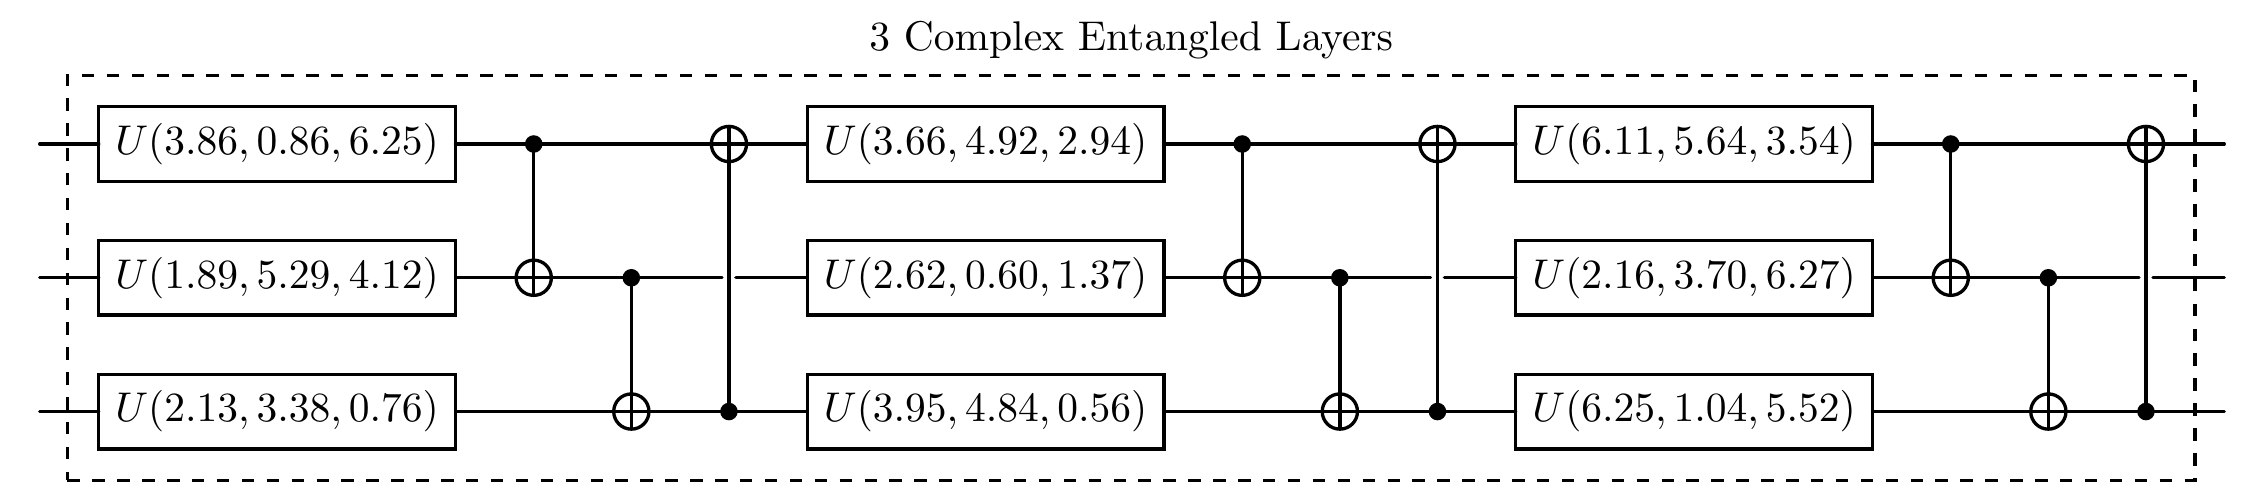

In [10]:
model = lcqnn_model(3,1,3)
model[0].plot(print_code=True)

## Grad Test

In [11]:
import time
from tqdm import tqdm

  0%|          | 0/50 [00:00<?, ?it/s]

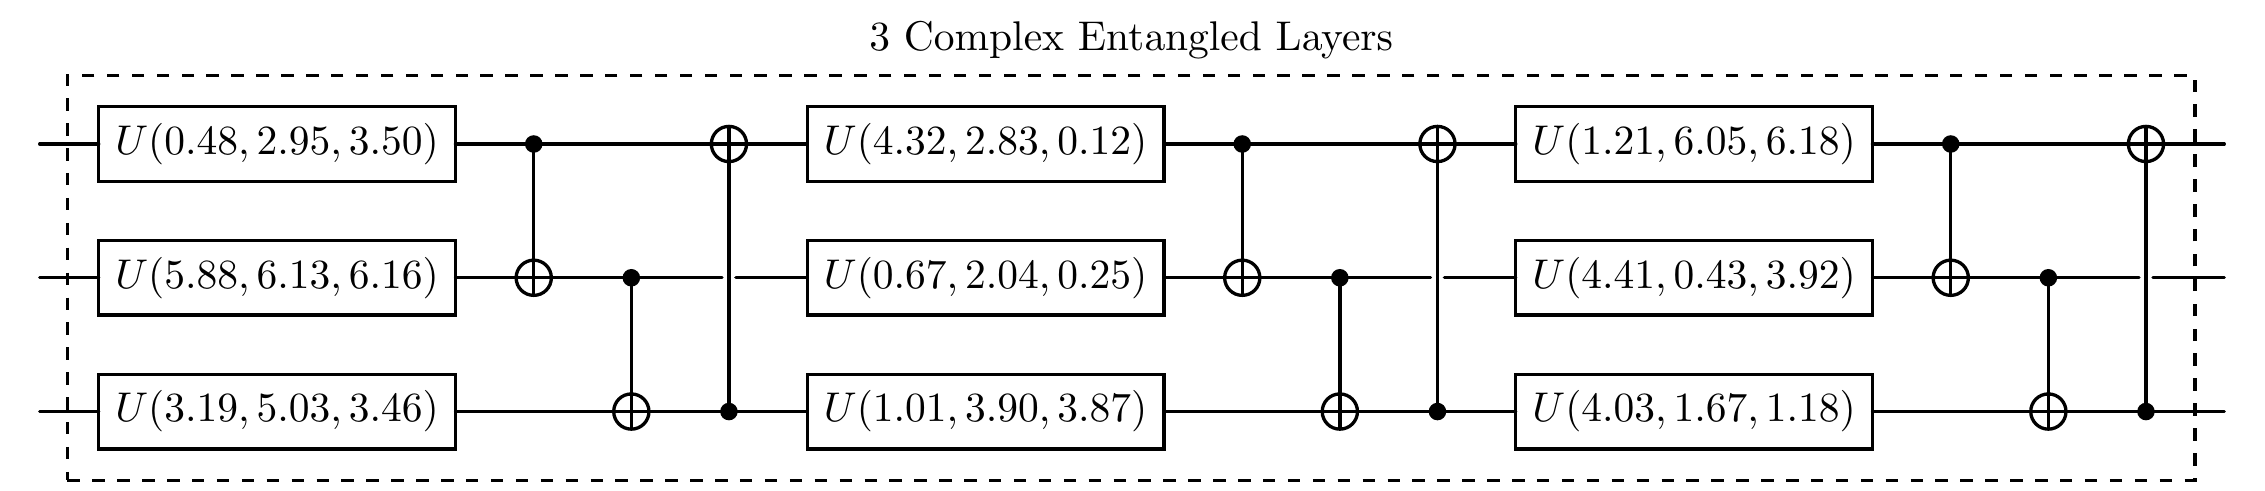

  2%|▏         | 1/50 [00:04<03:18,  4.05s/it]

None


  0%|          | 0/50 [00:00<?, ?it/s]

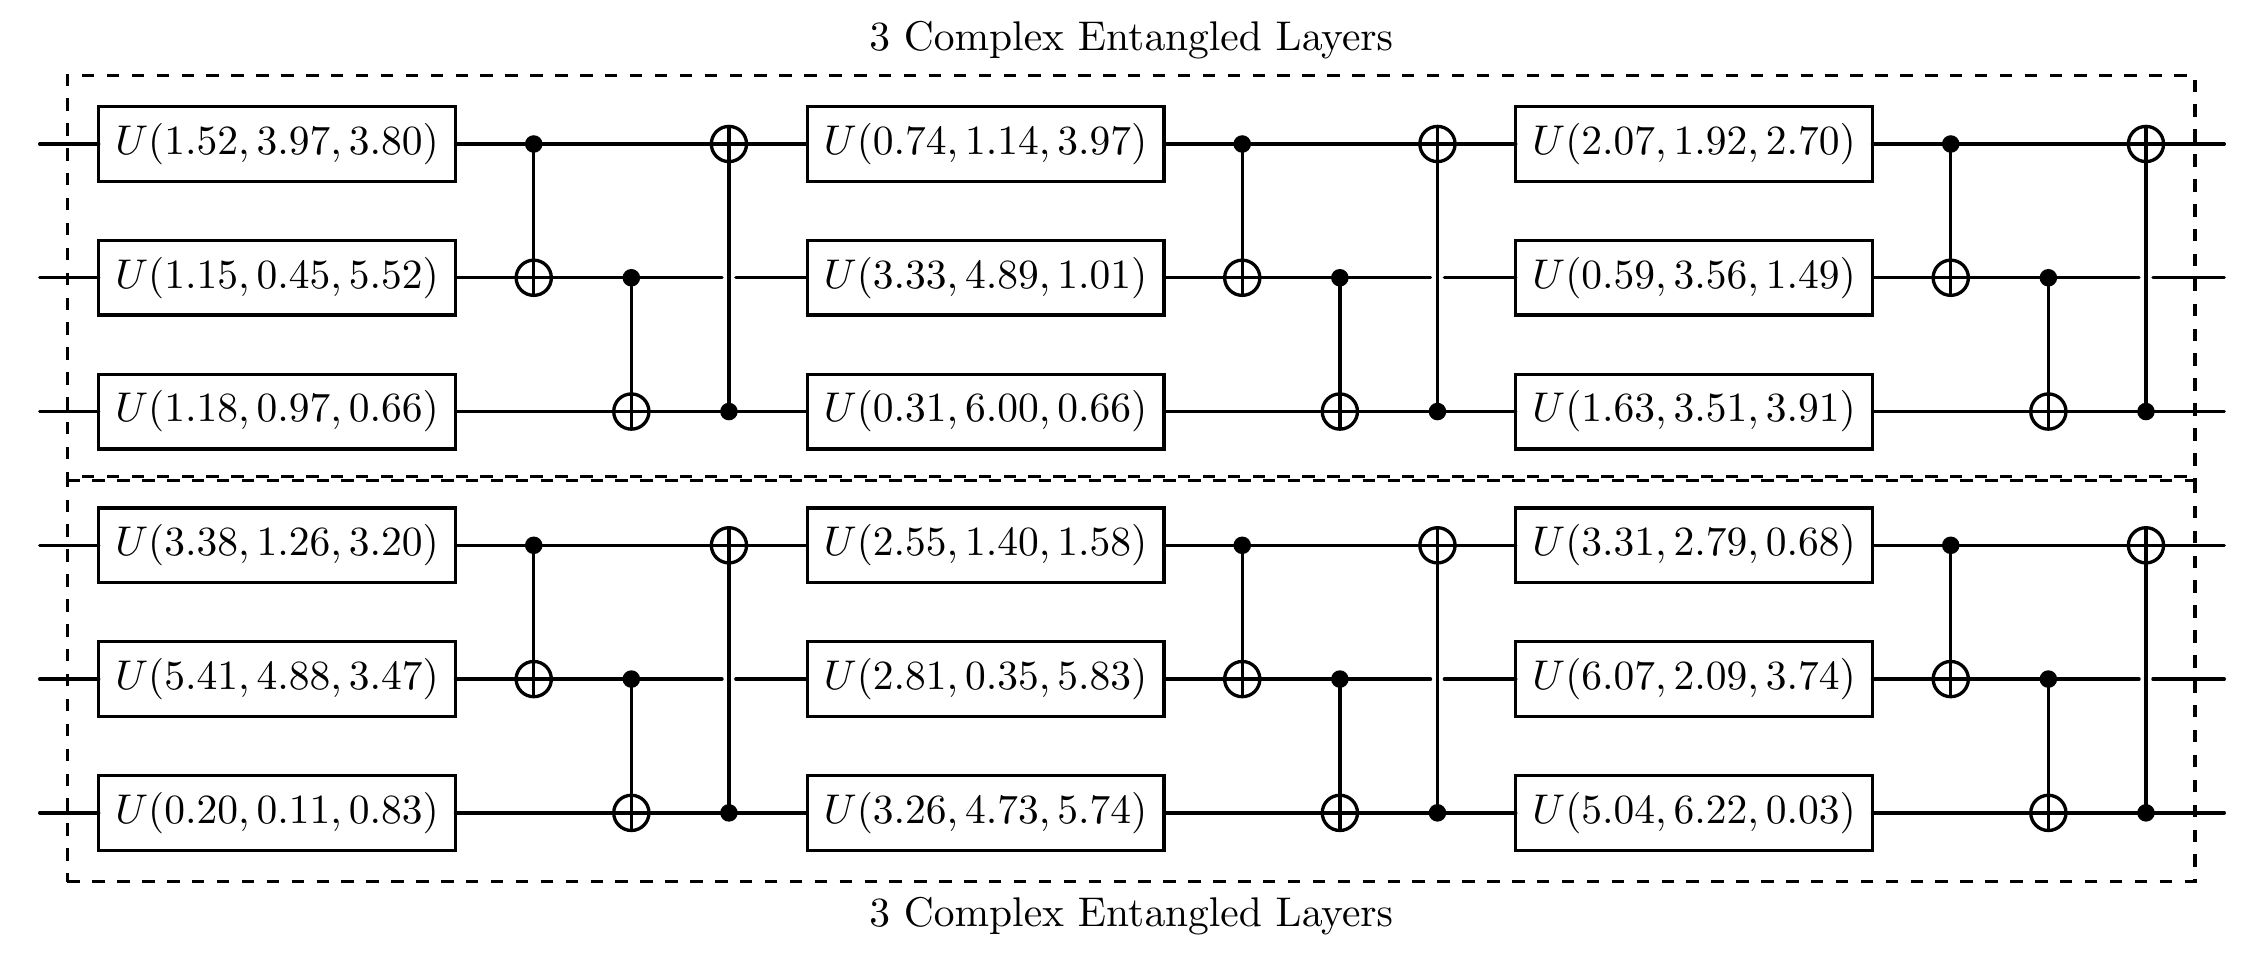

None


  0%|          | 0/50 [00:00<?, ?it/s]

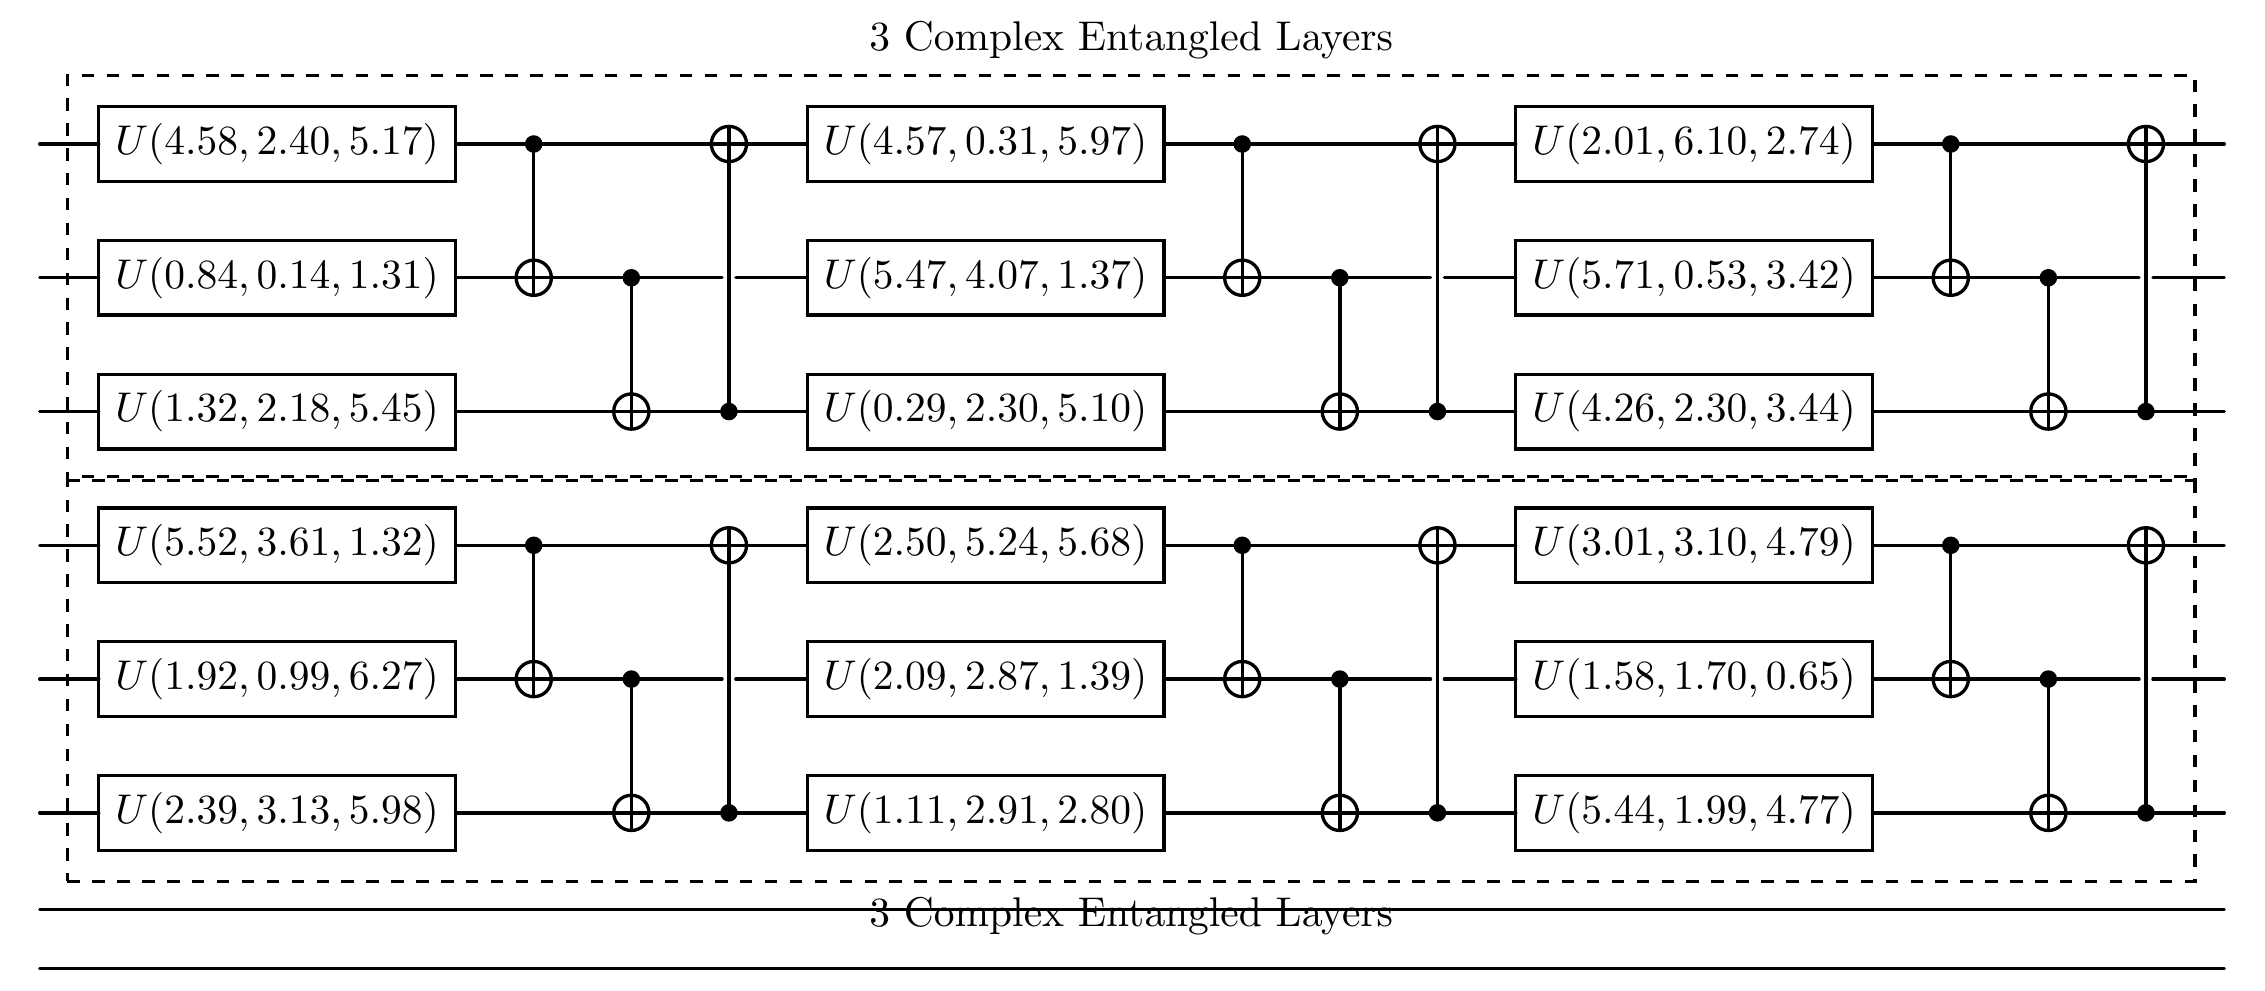

None


  0%|          | 0/50 [00:00<?, ?it/s]

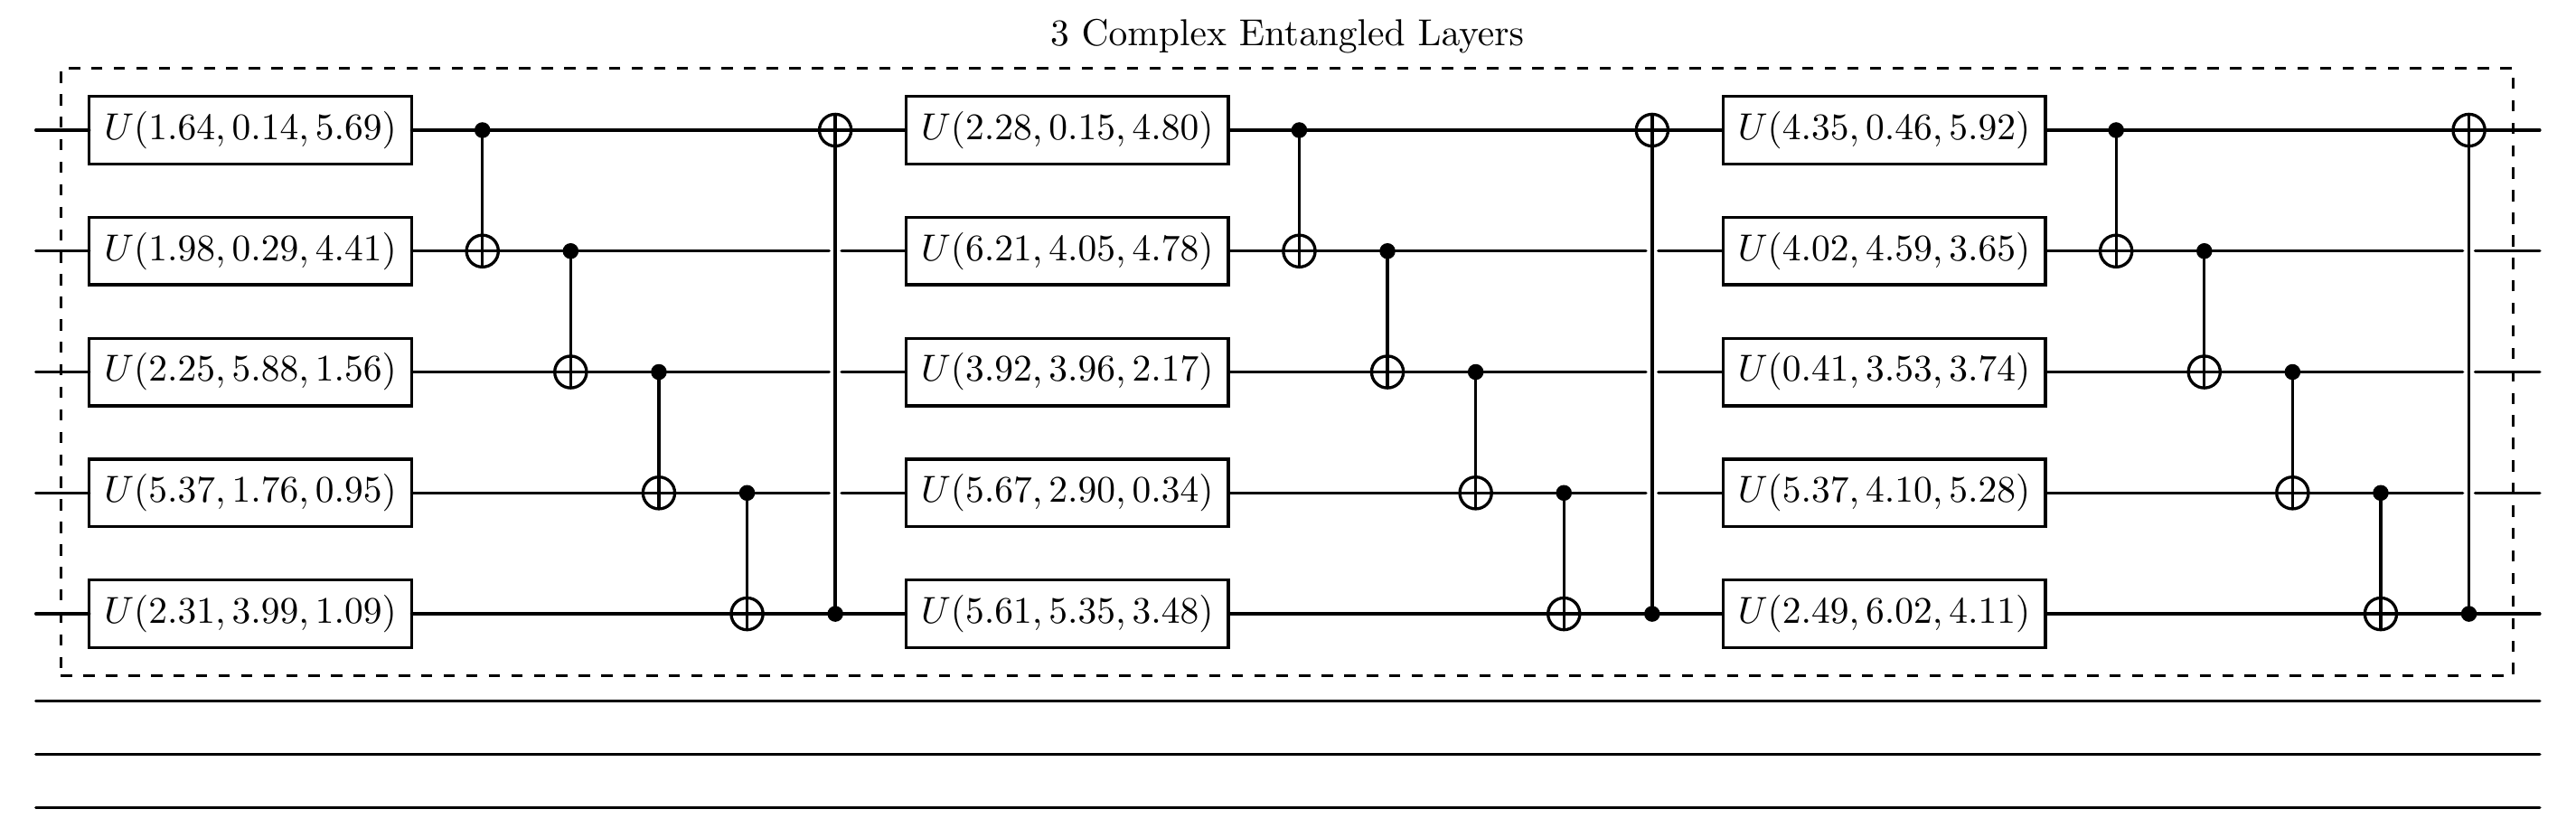

None


  0%|          | 0/50 [00:00<?, ?it/s]

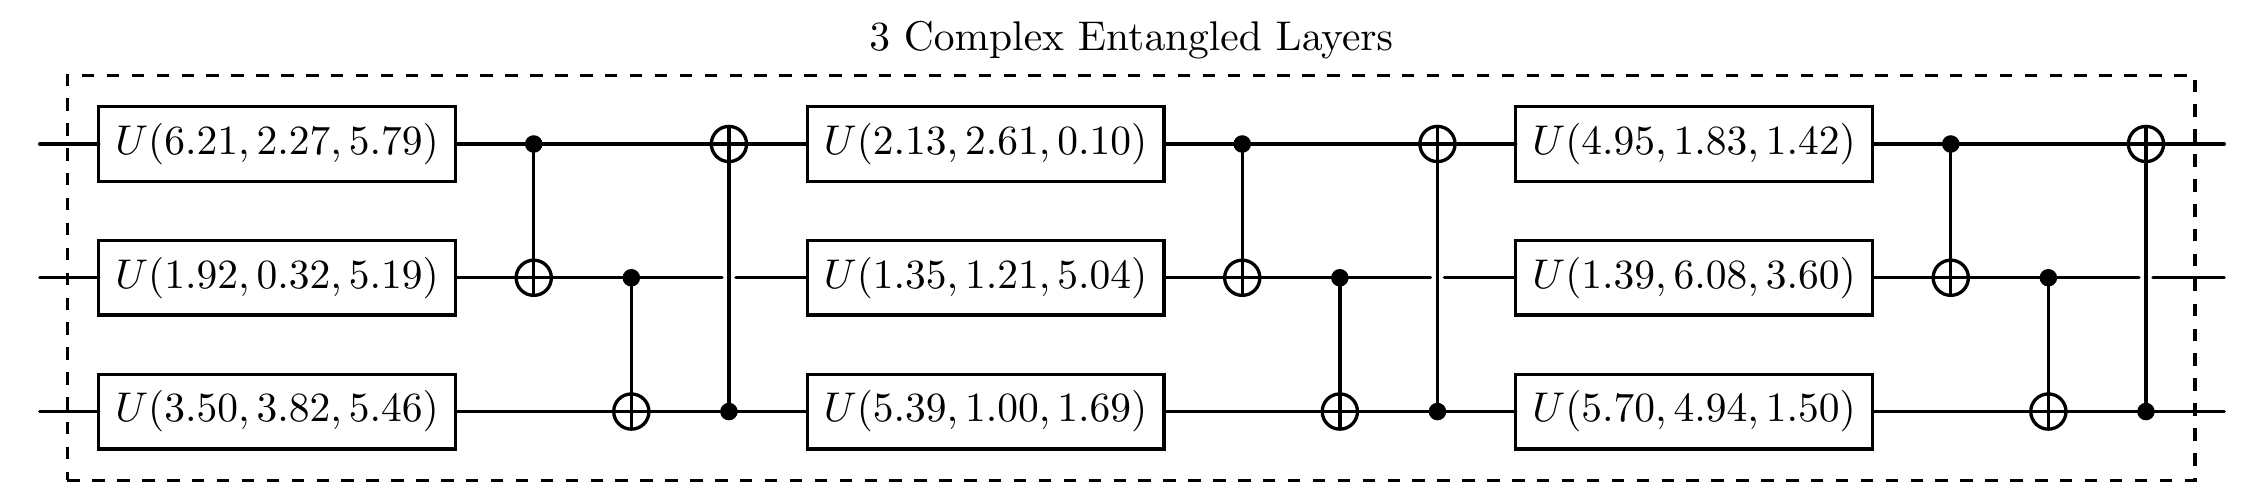

  2%|▏         | 1/50 [00:01<01:32,  1.89s/it]

None


  0%|          | 0/50 [00:00<?, ?it/s]

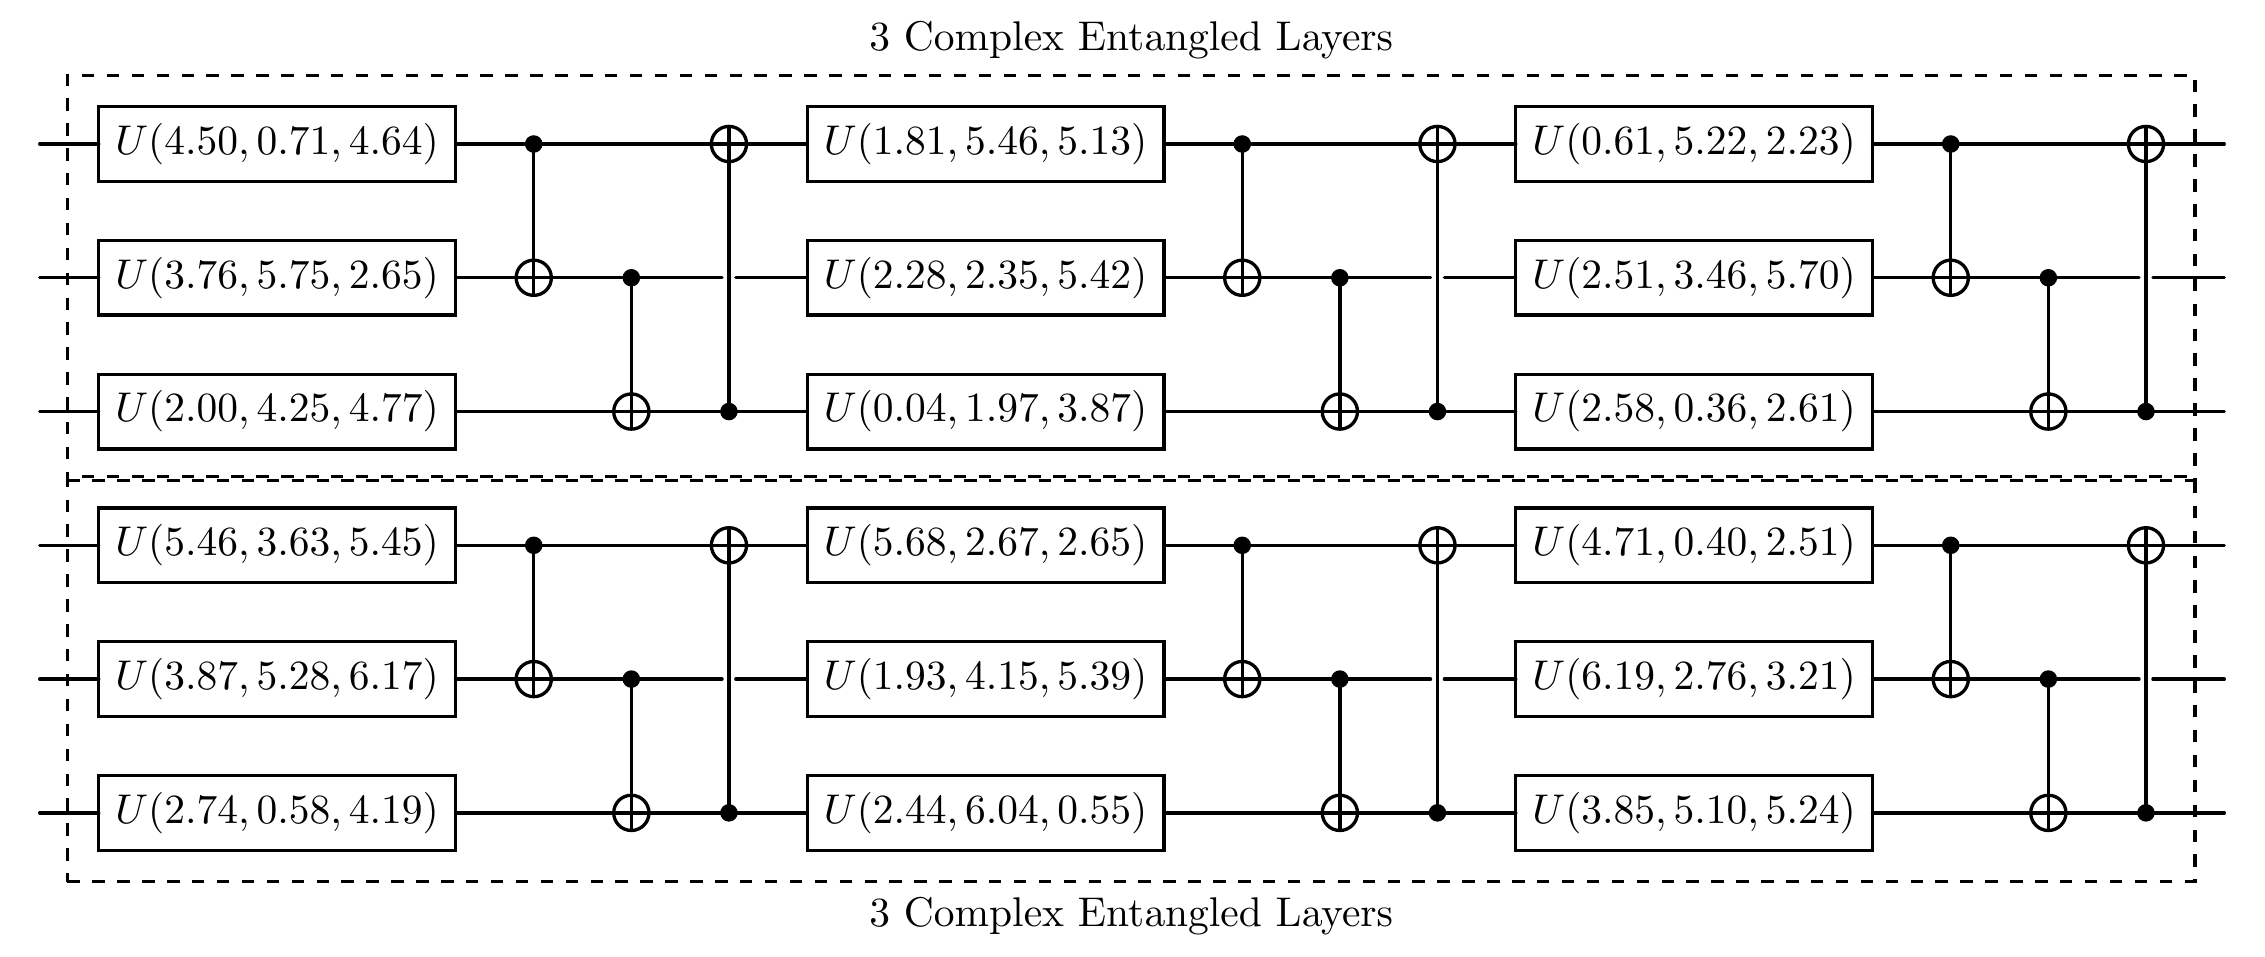

None


  0%|          | 0/50 [00:00<?, ?it/s]

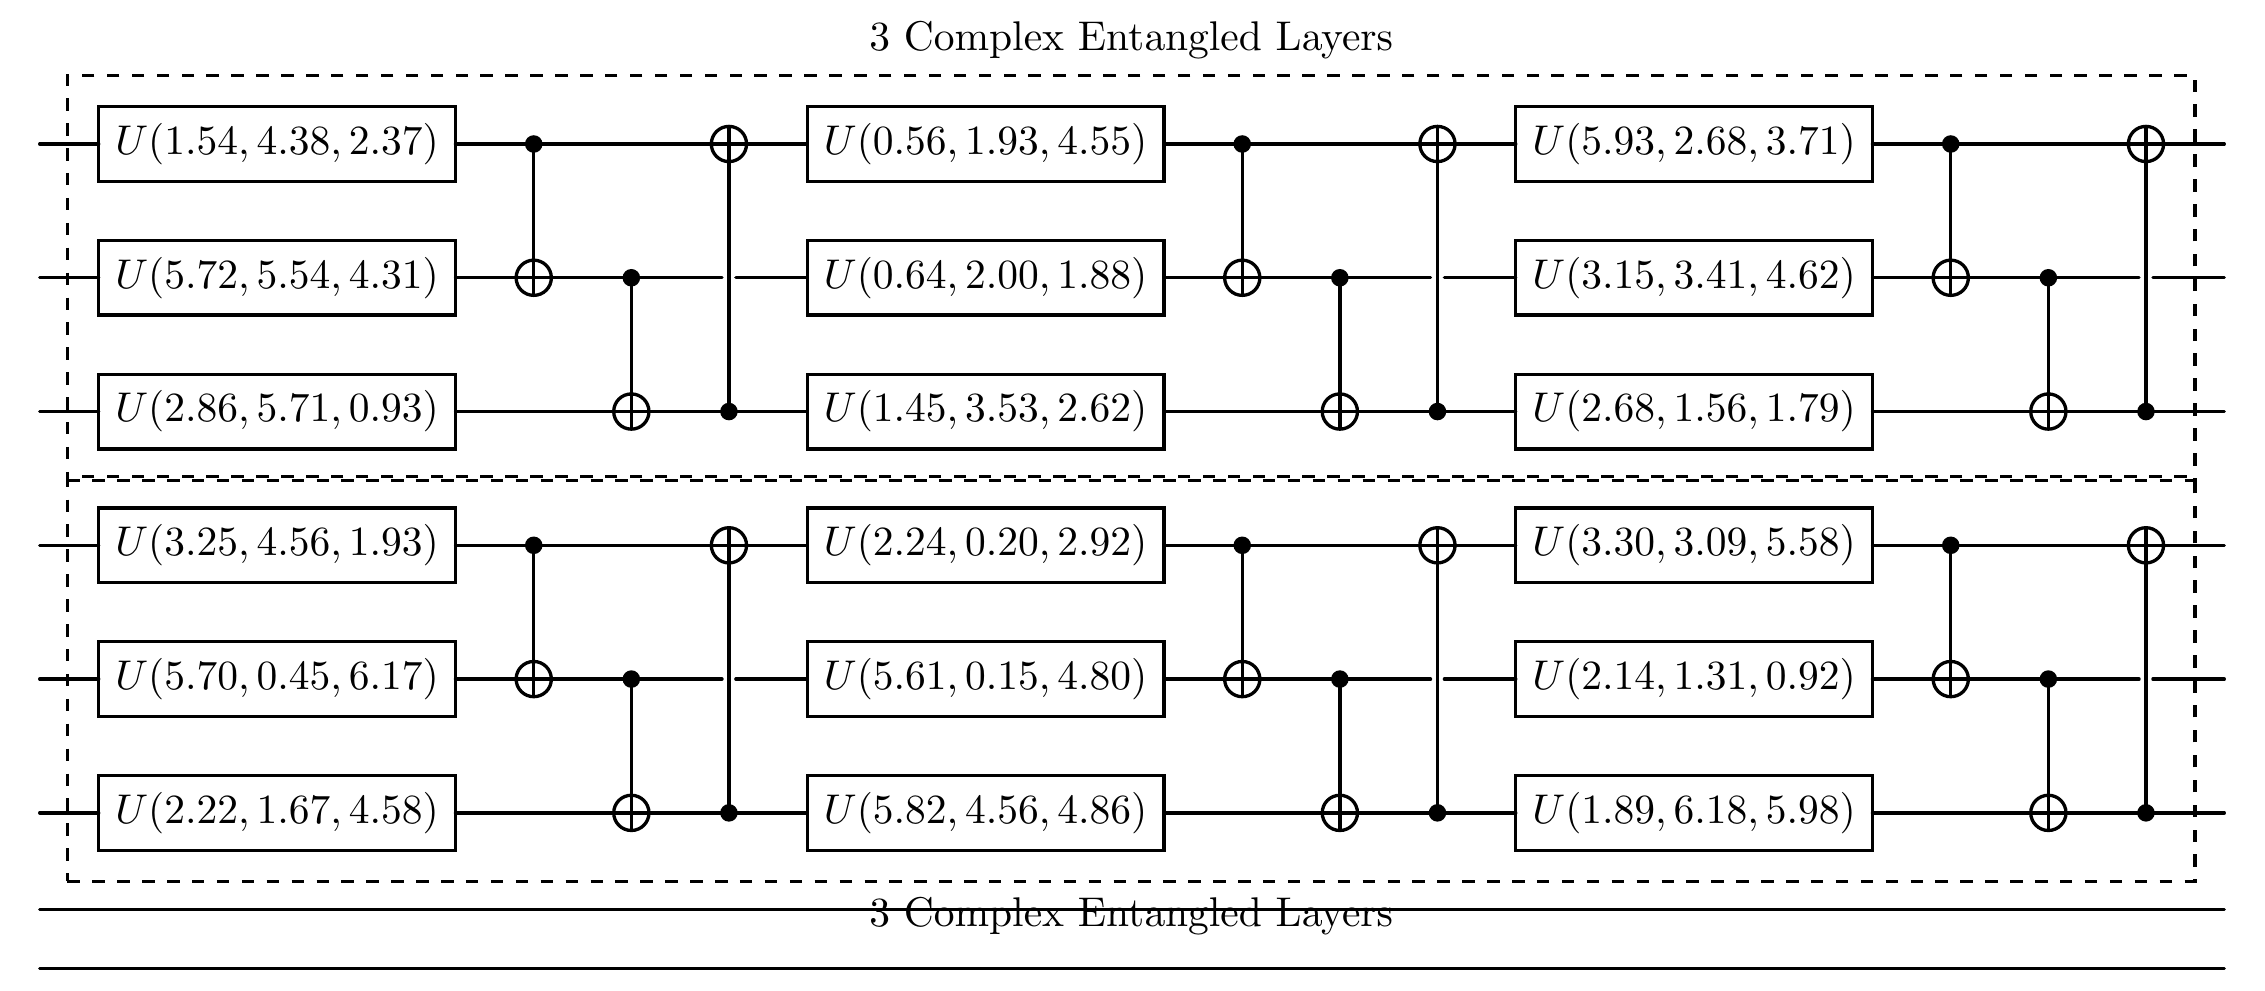

None


  0%|          | 0/50 [00:00<?, ?it/s]

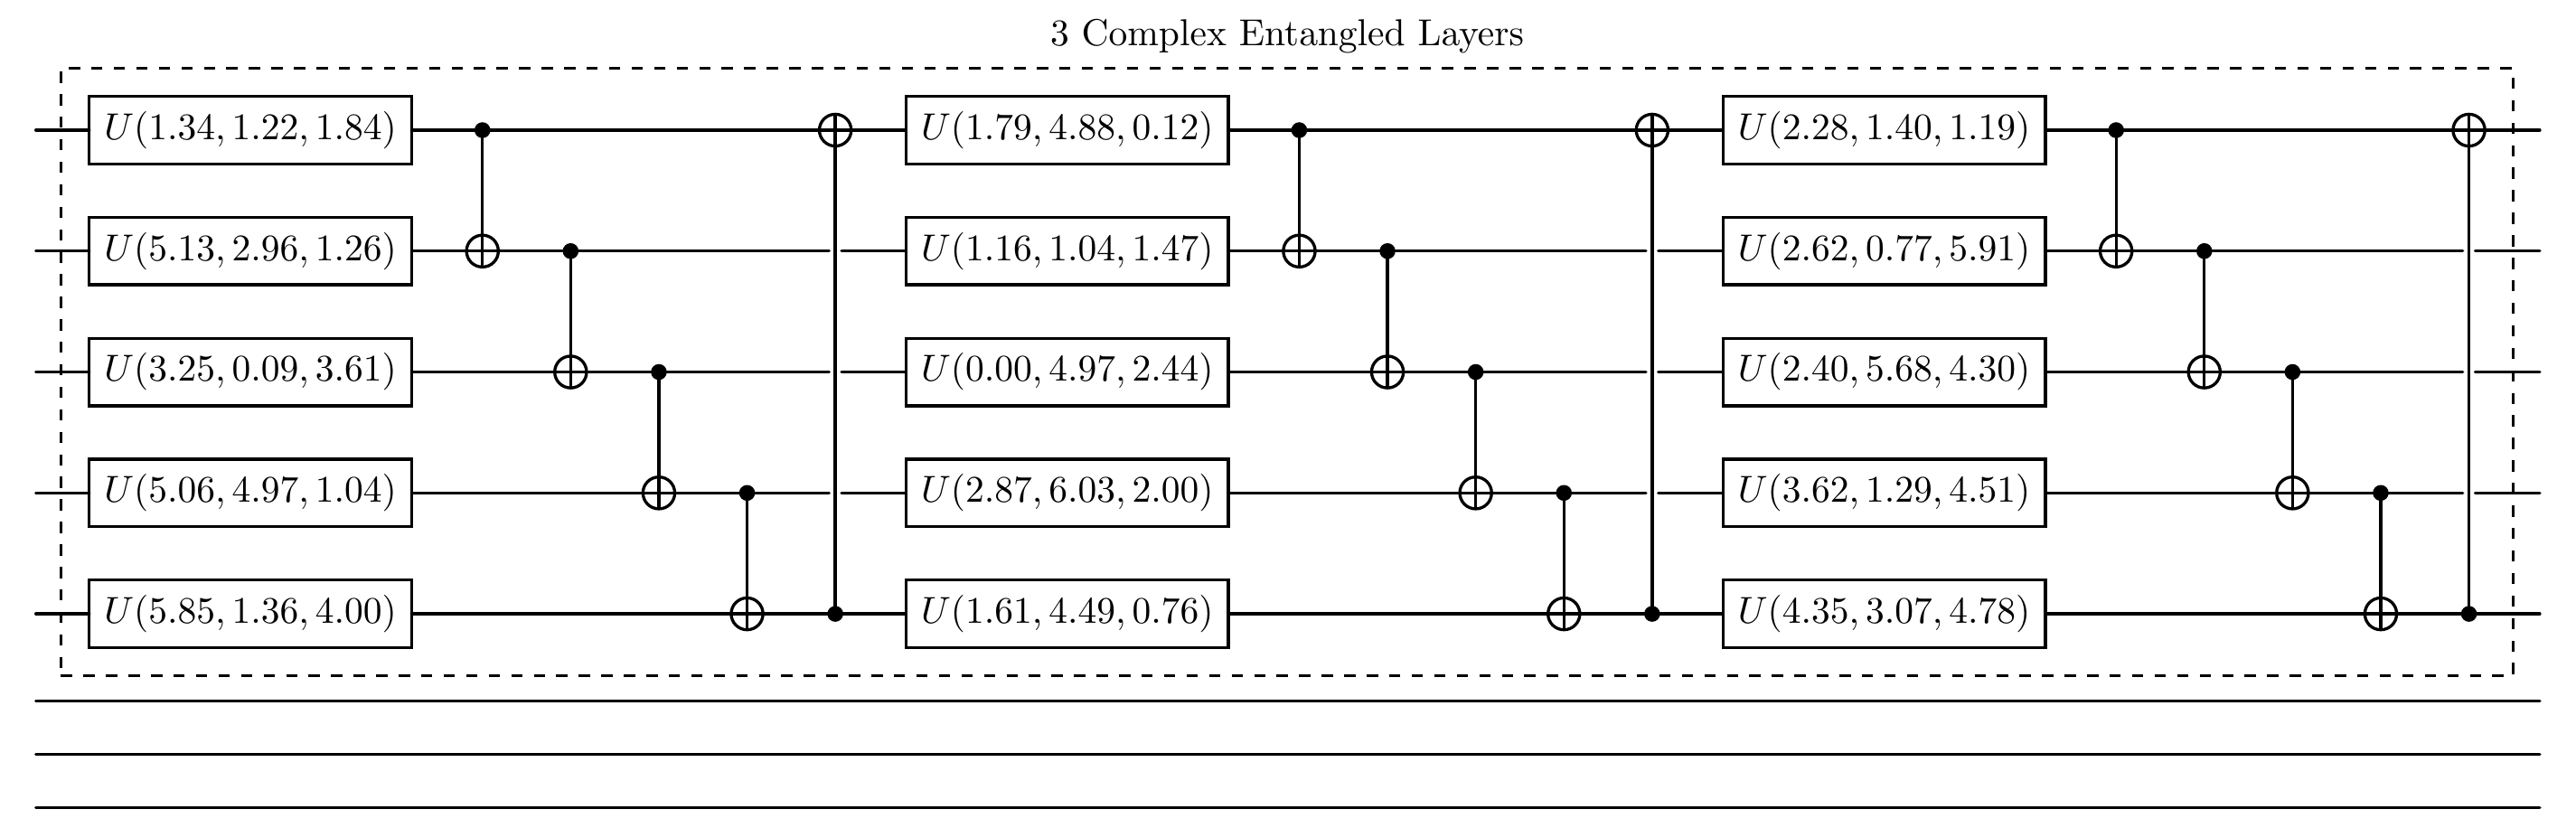

None


  0%|          | 0/50 [00:00<?, ?it/s]

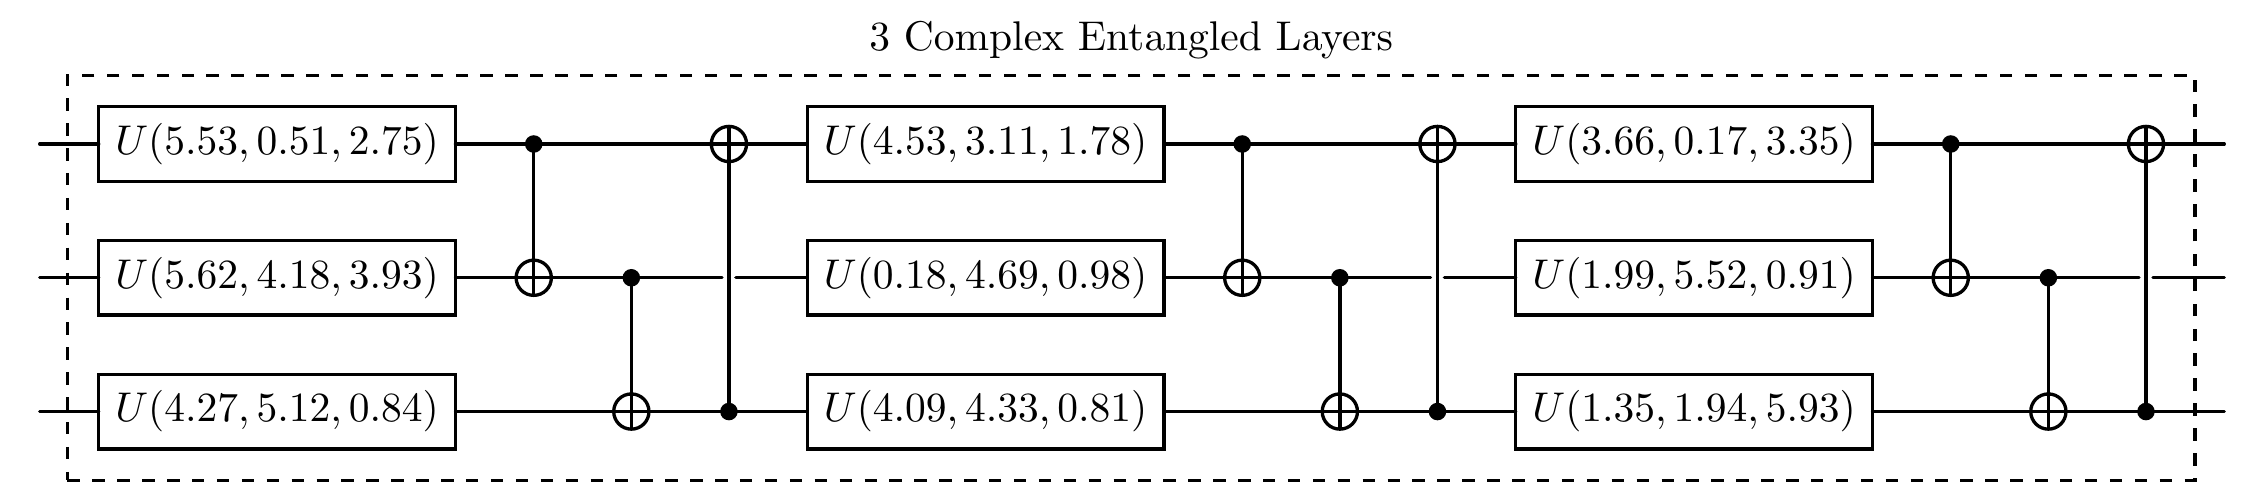

None


  0%|          | 0/50 [00:00<?, ?it/s]

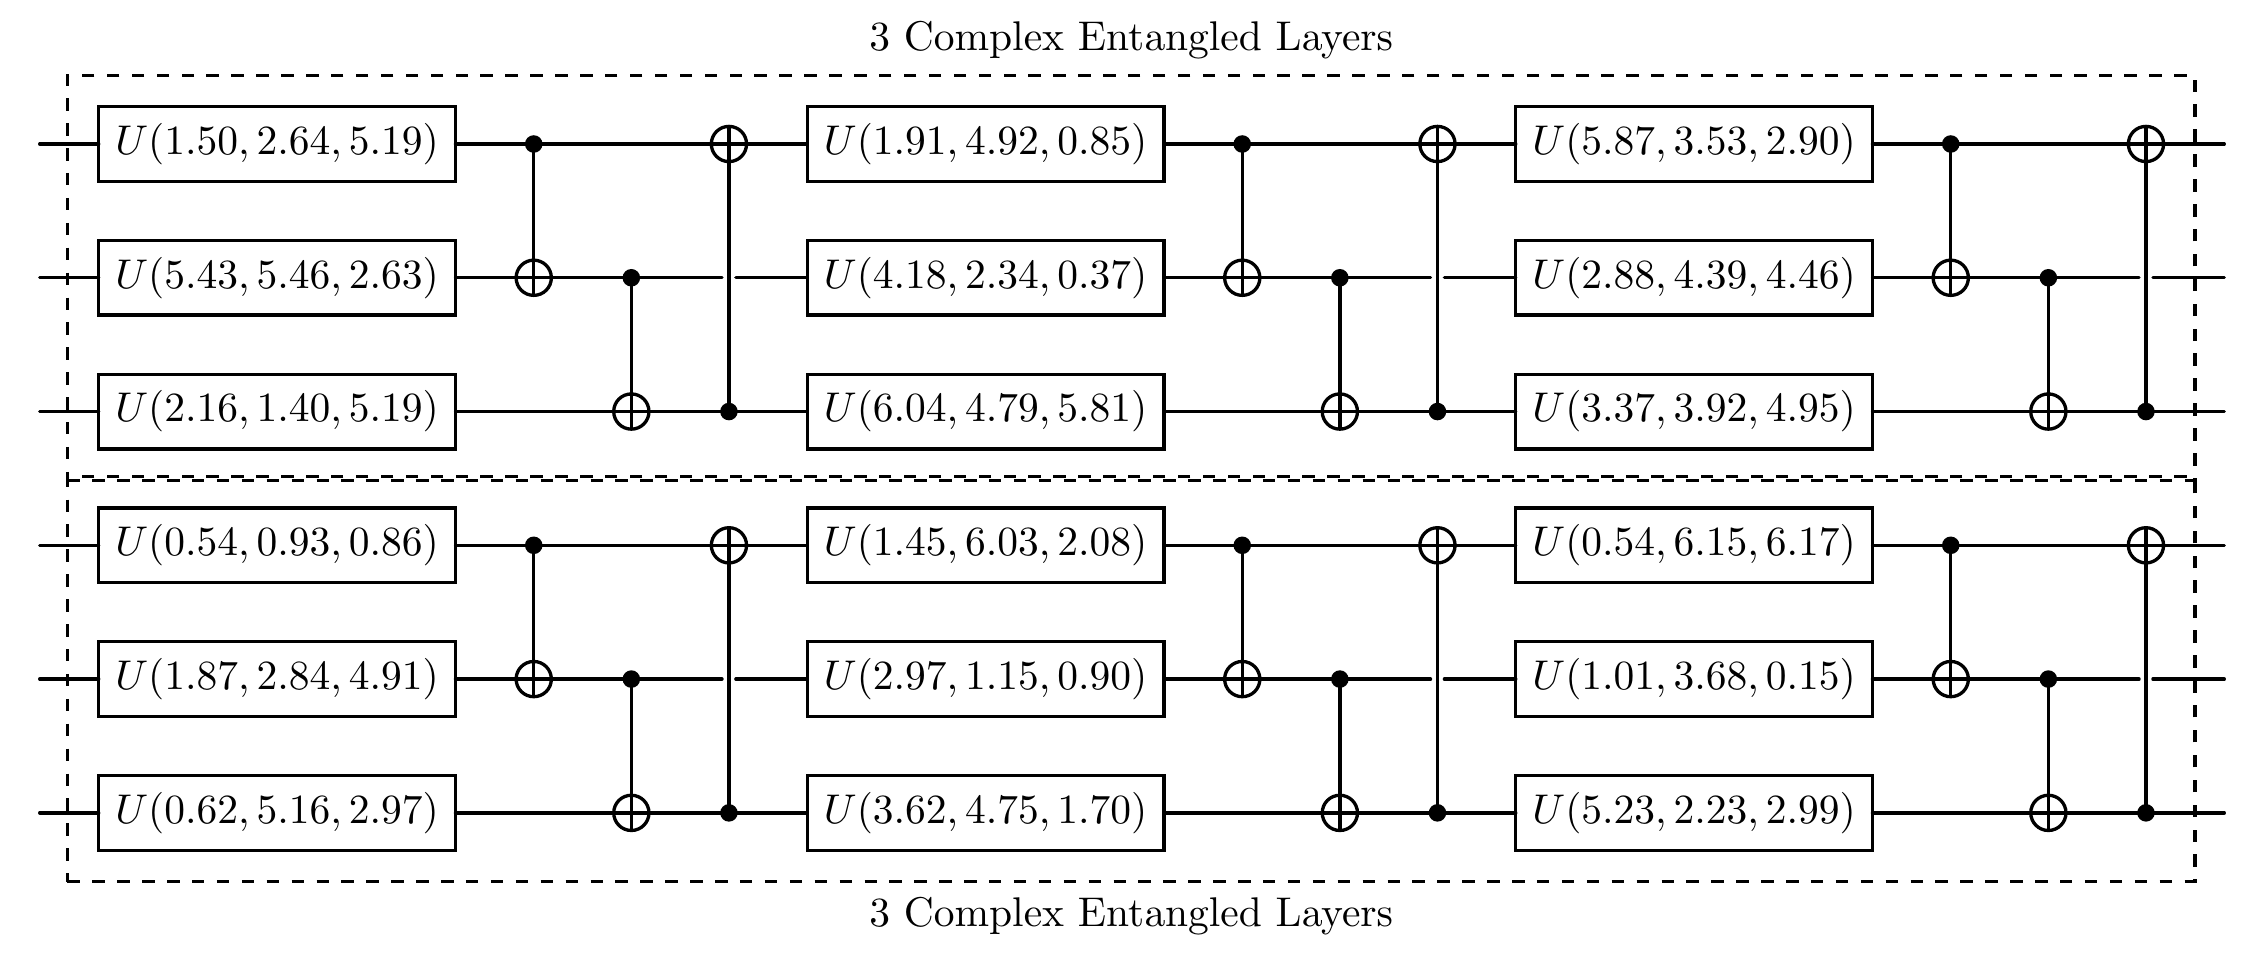

None


  0%|          | 0/50 [00:00<?, ?it/s]

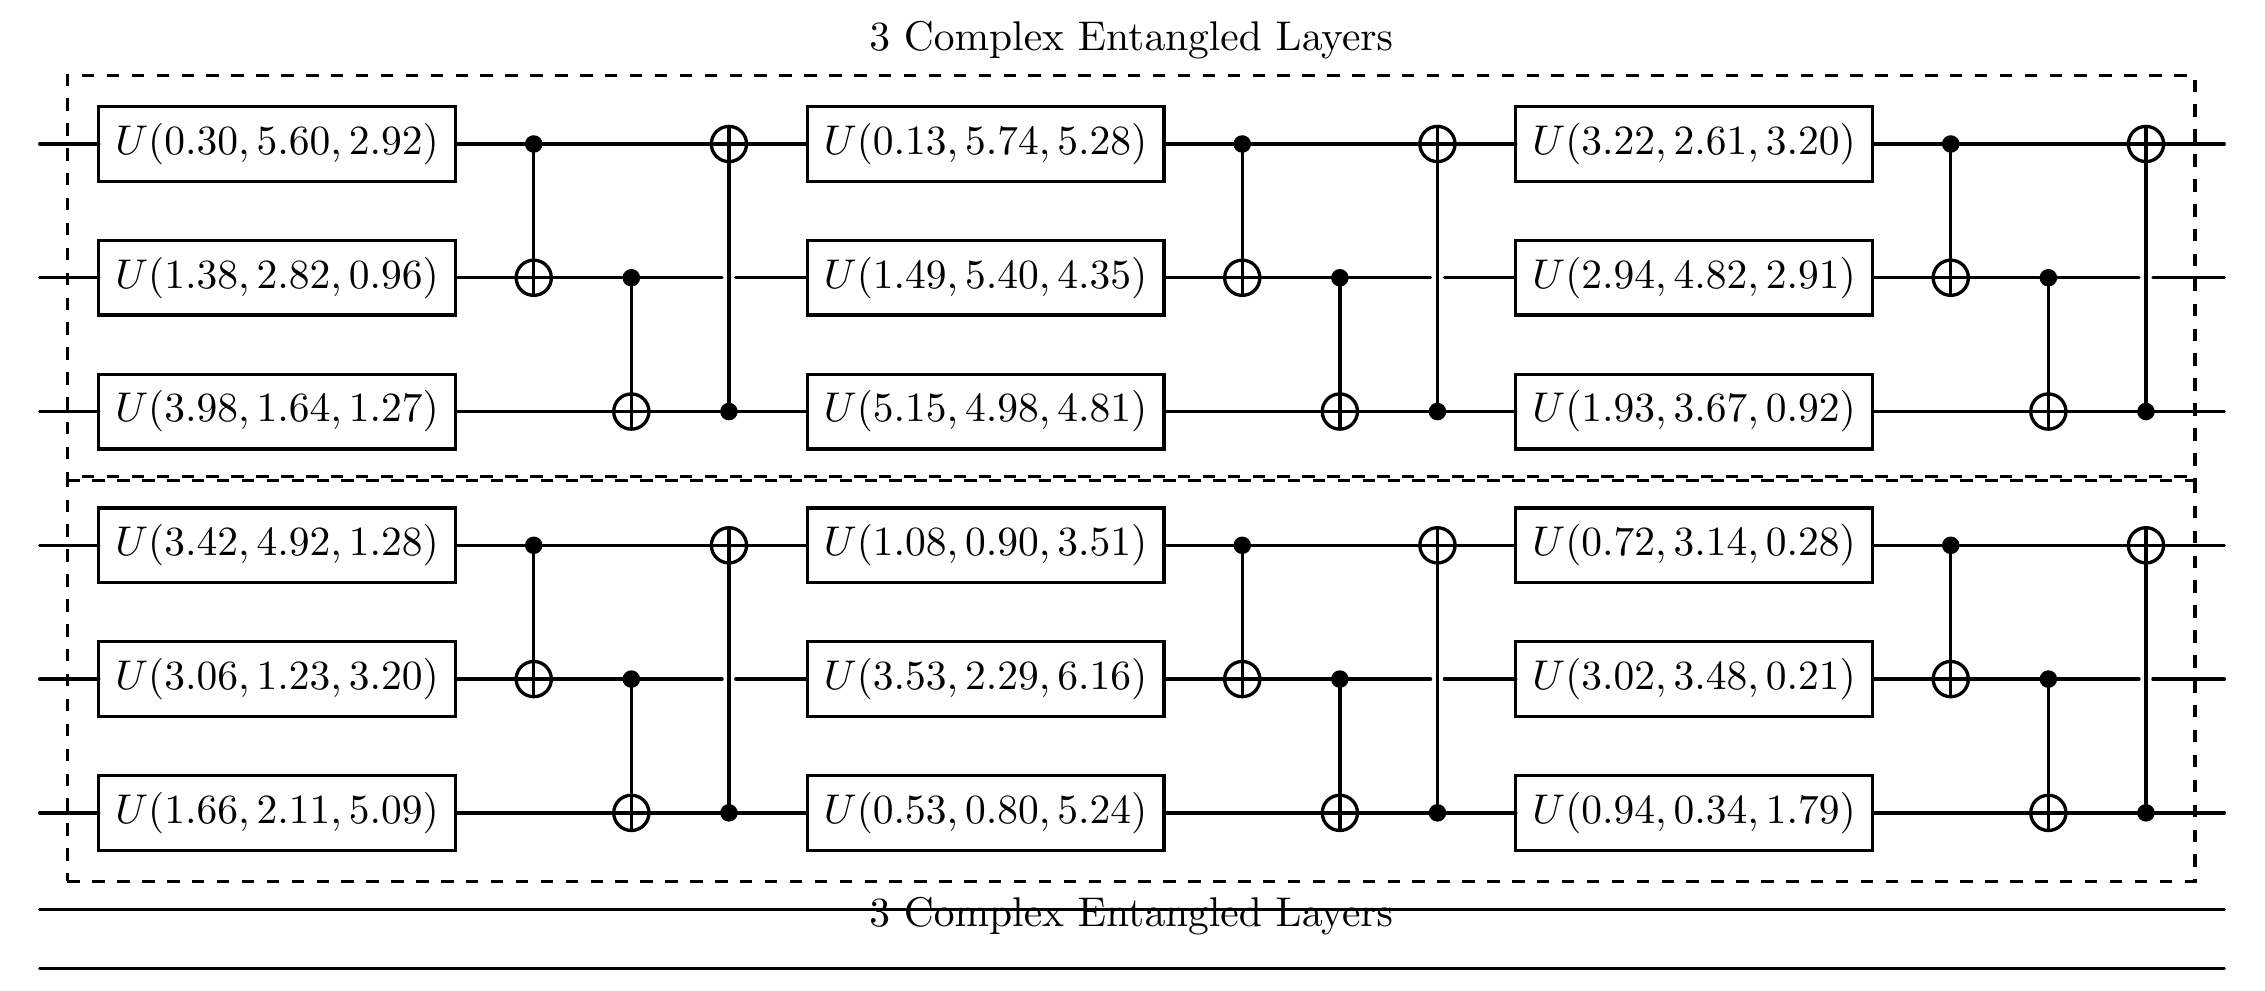

None


  0%|          | 0/50 [00:00<?, ?it/s]

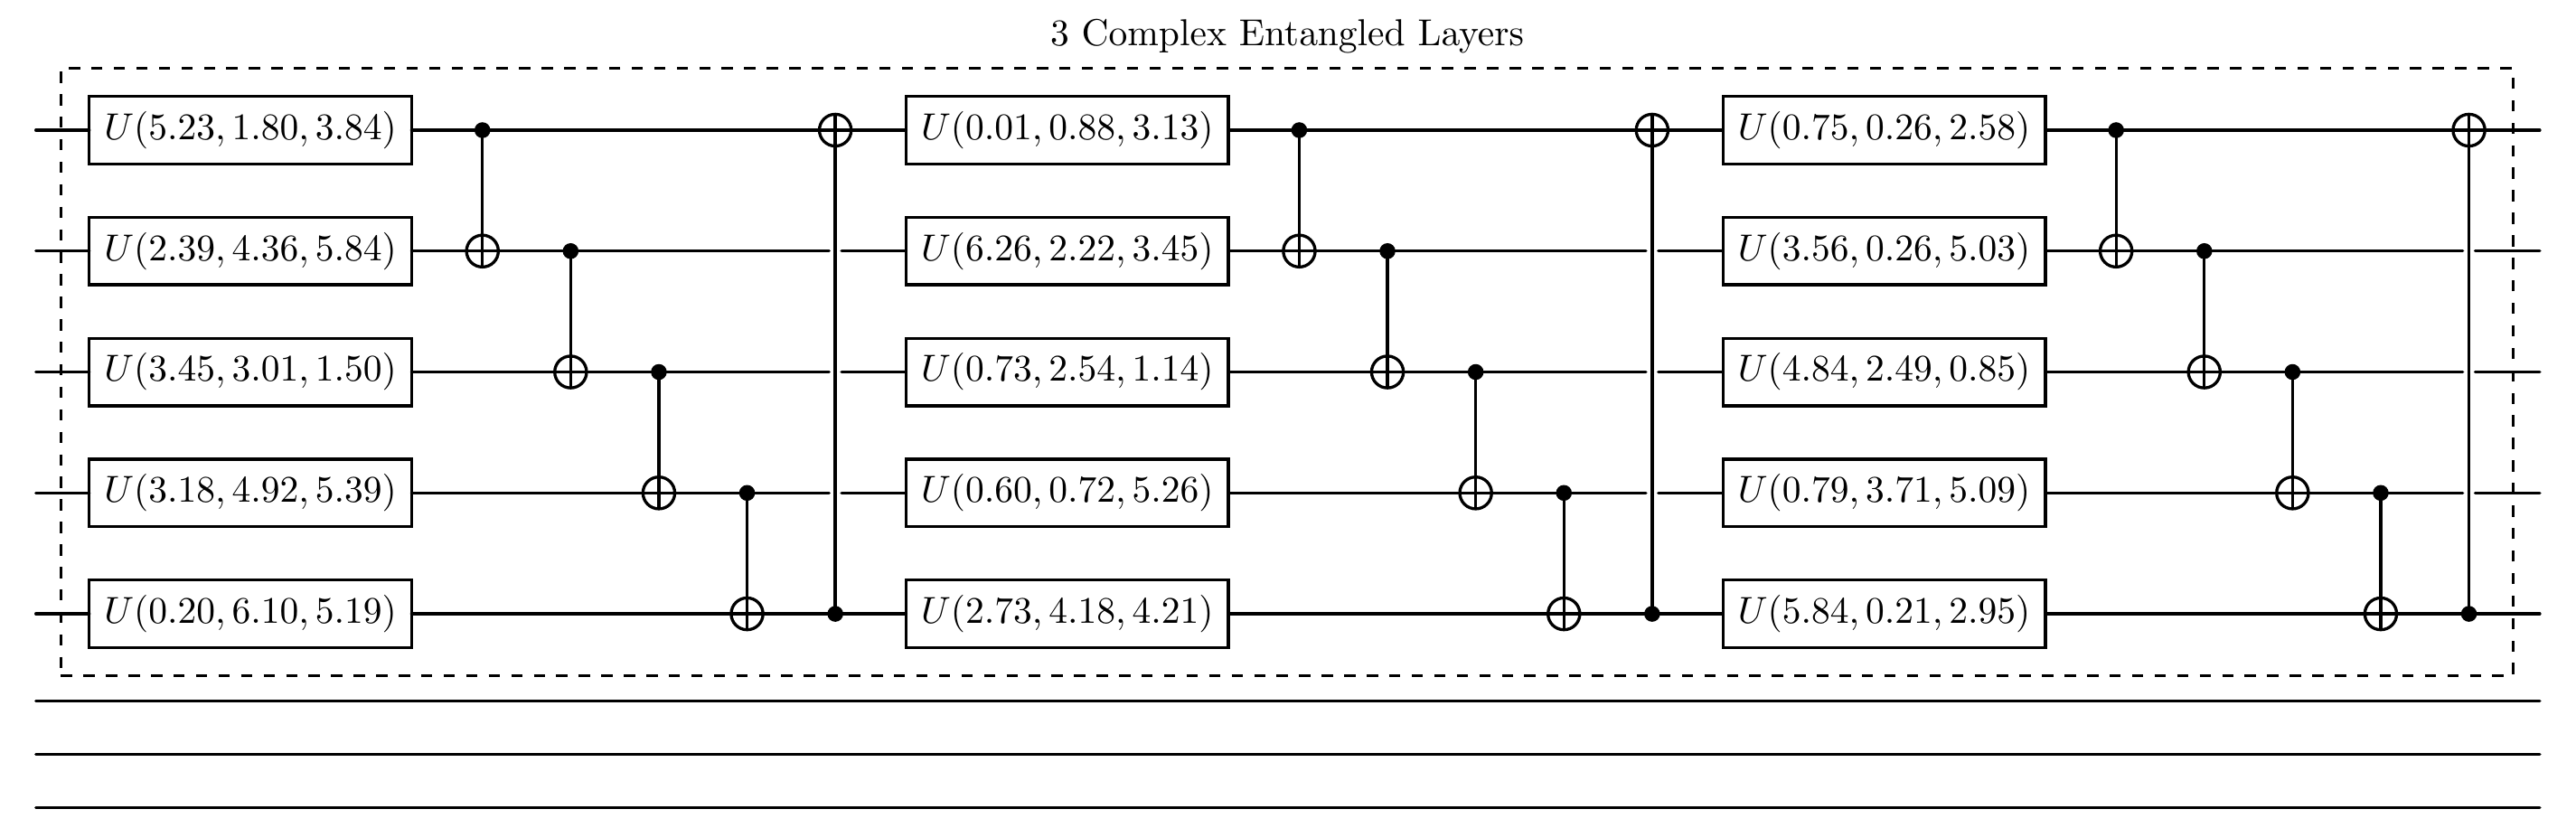

None


  0%|          | 0/50 [00:00<?, ?it/s]

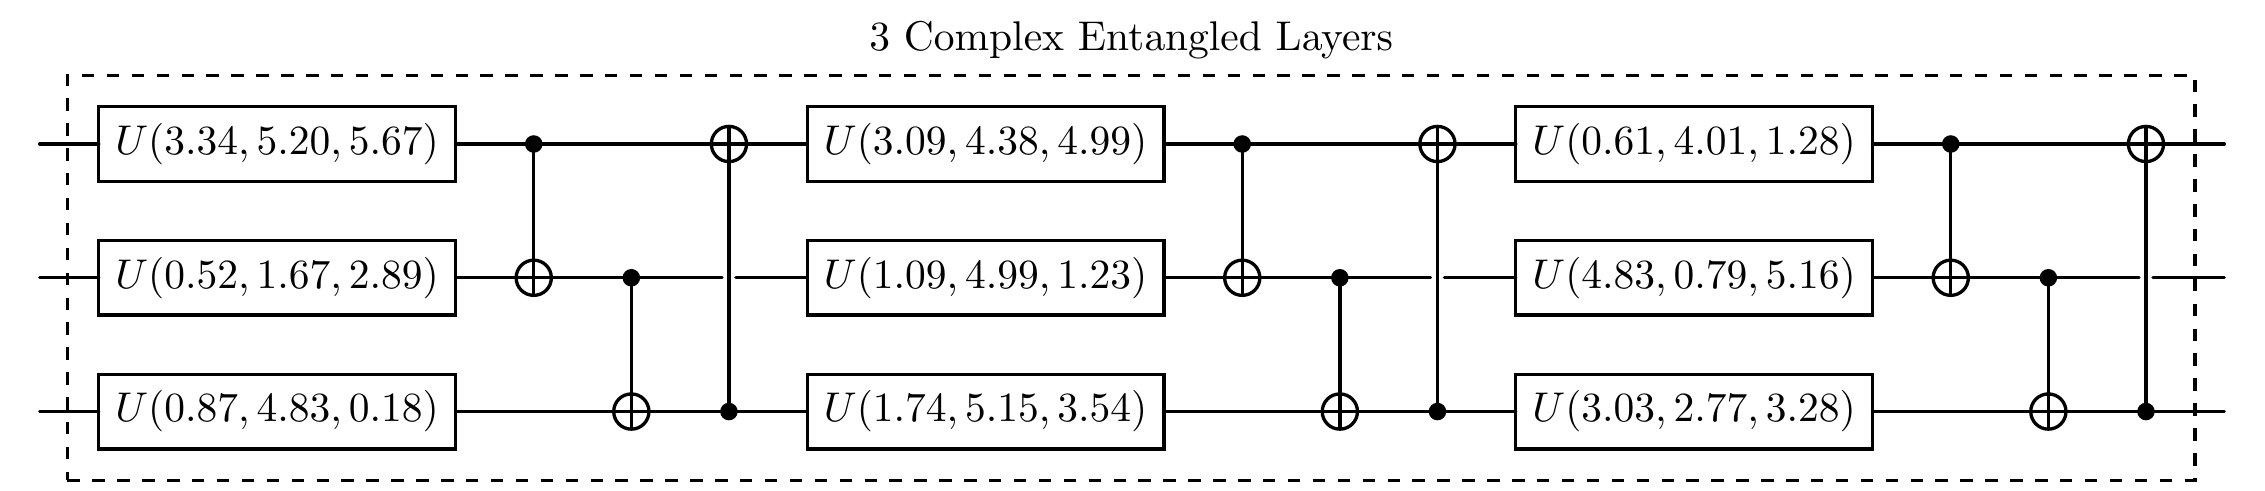

  2%|▏         | 1/50 [00:02<01:57,  2.41s/it]

None


  0%|          | 0/50 [00:00<?, ?it/s]

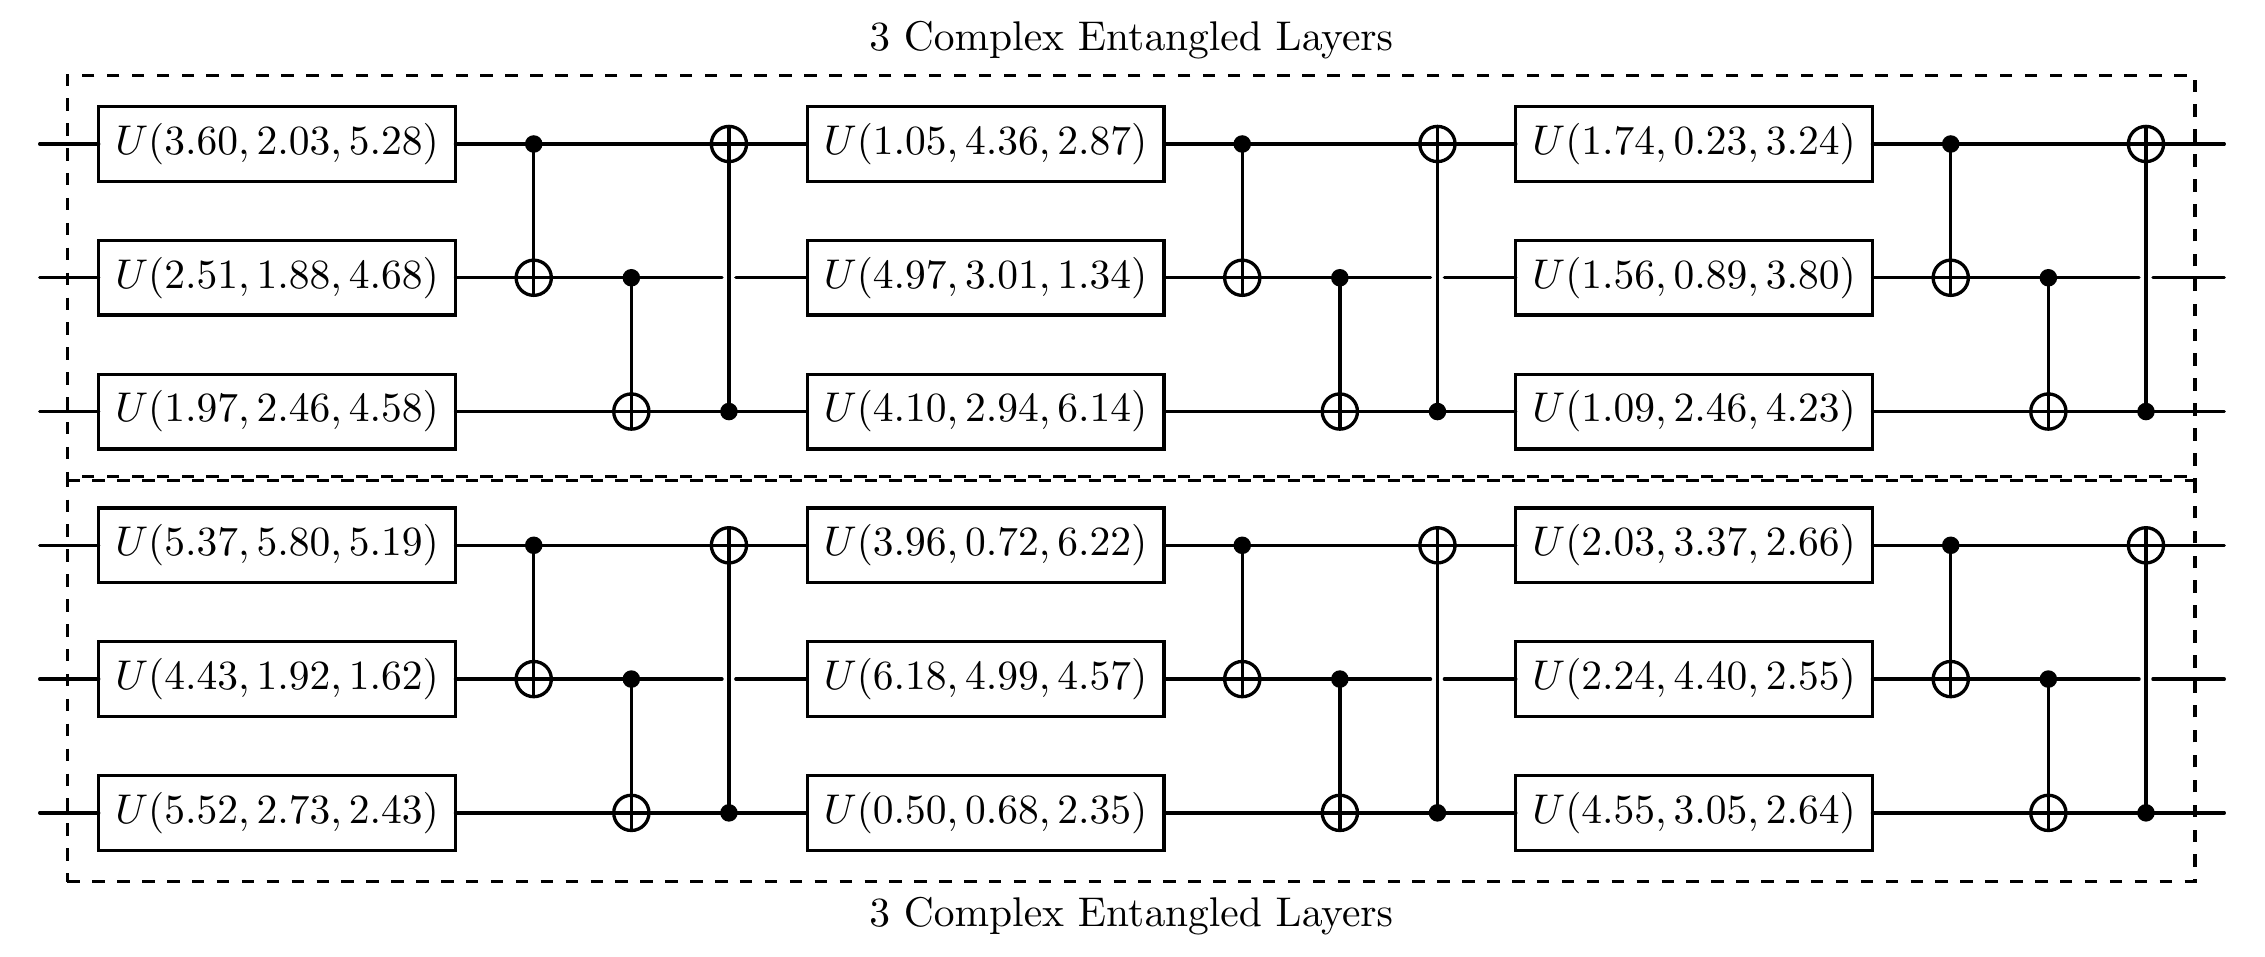

None


  0%|          | 0/50 [00:00<?, ?it/s]

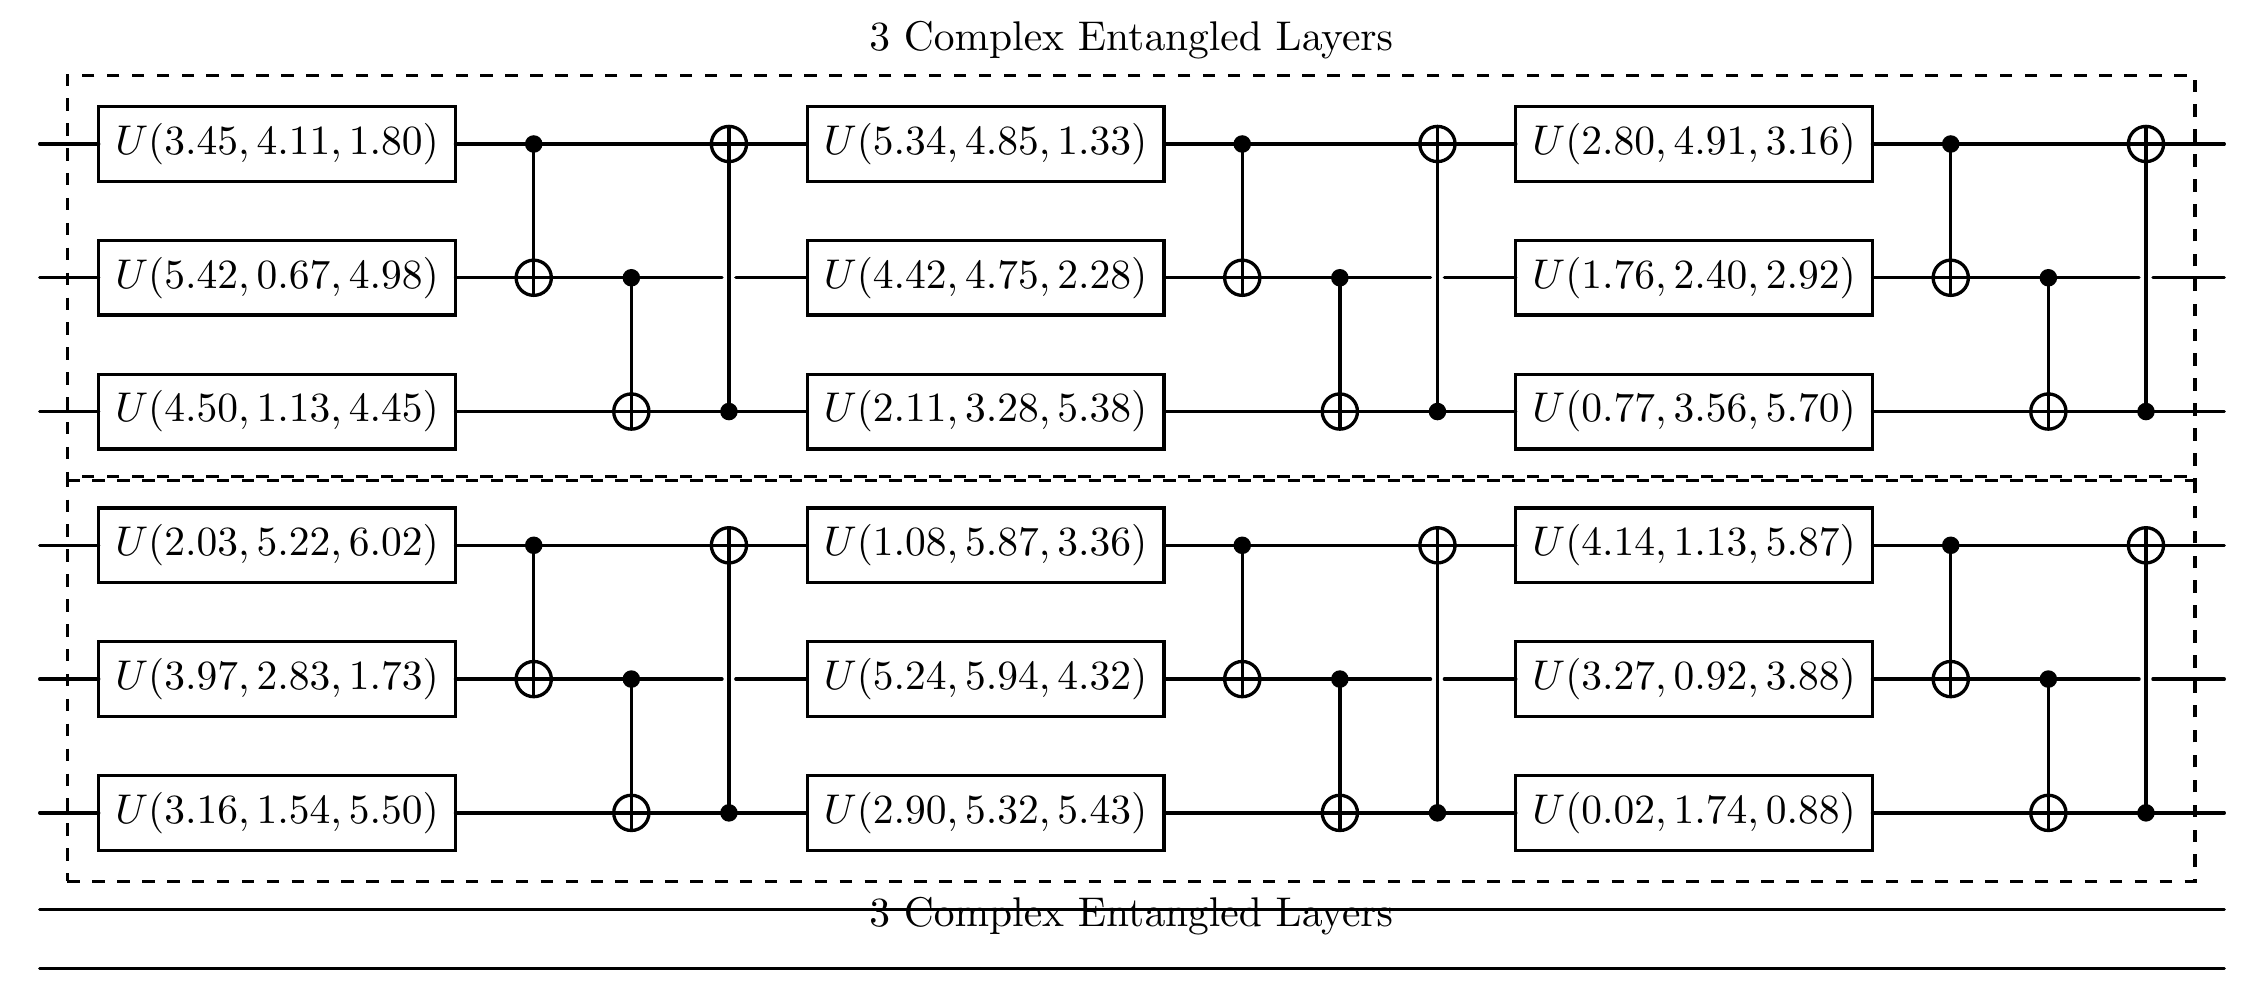

None


  0%|          | 0/50 [00:00<?, ?it/s]

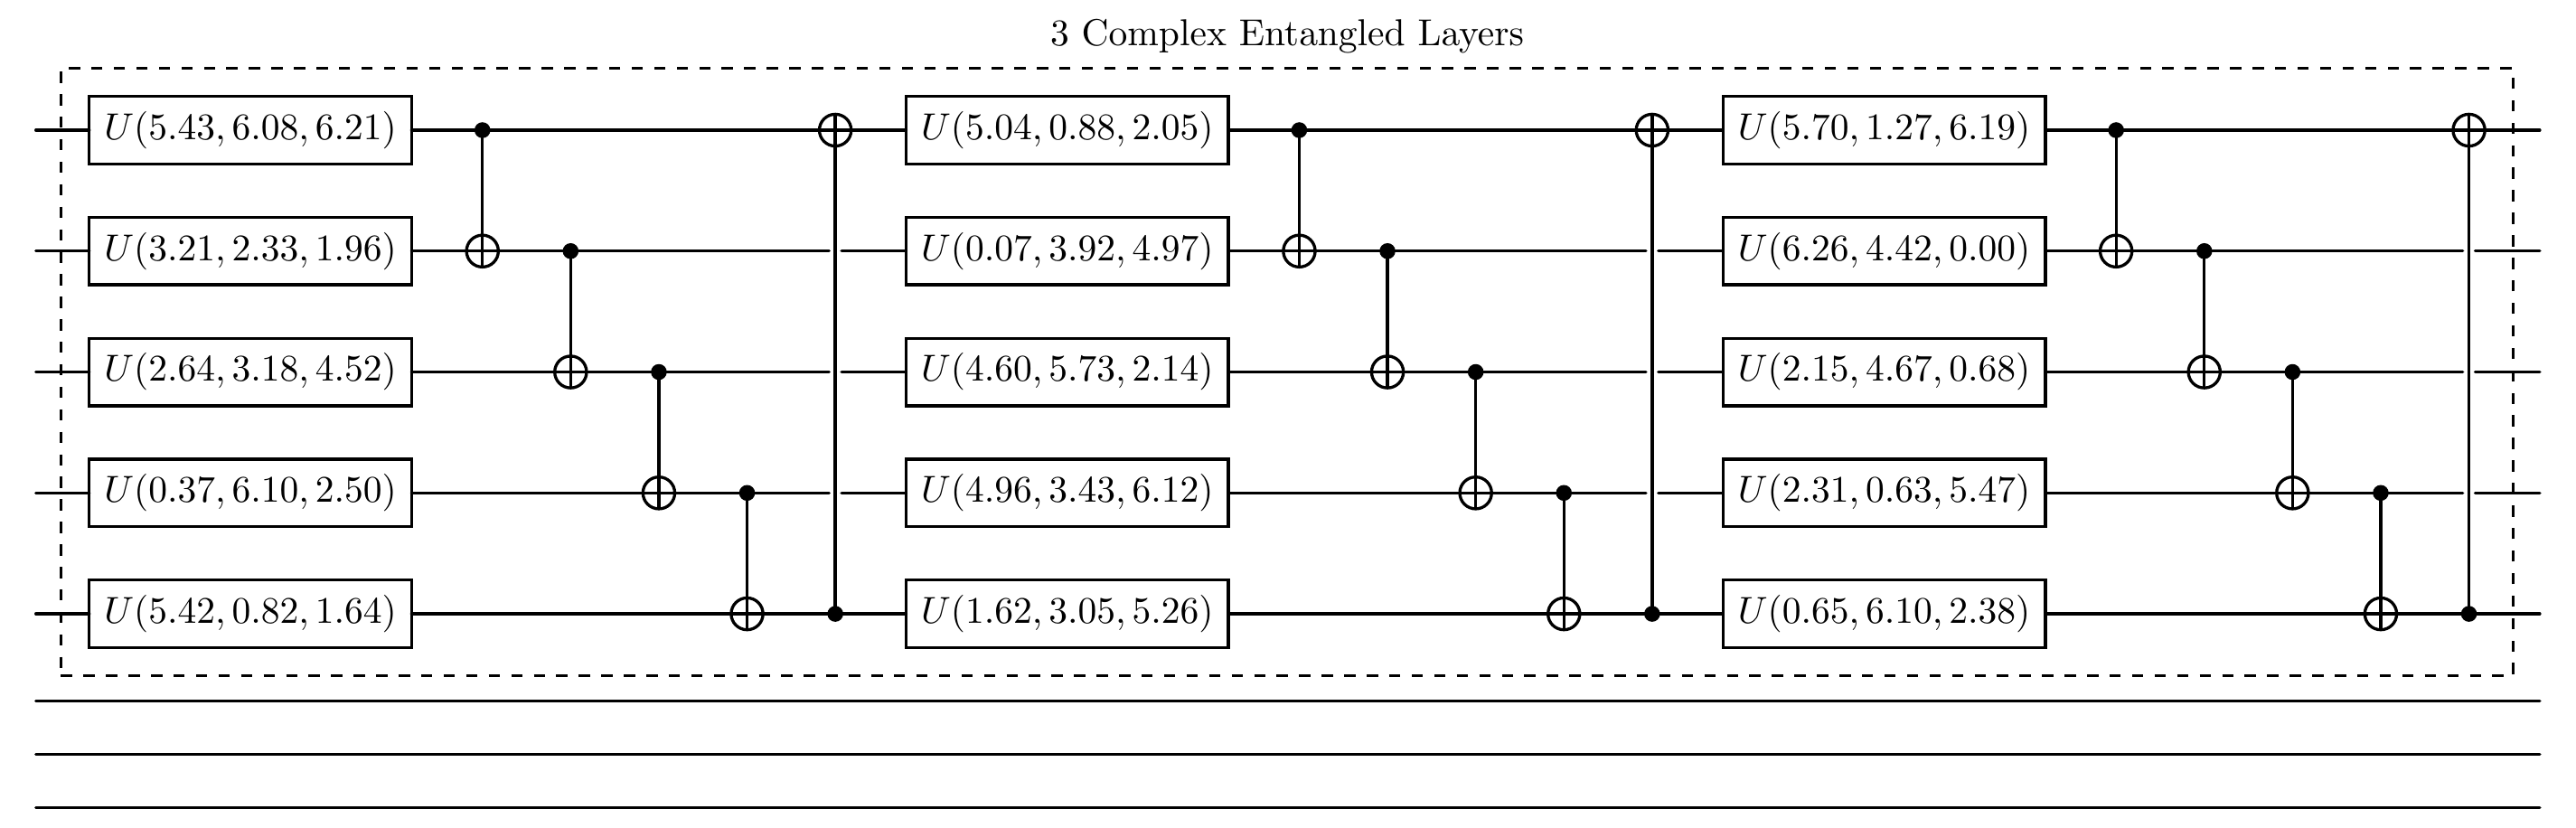

None


  0%|          | 0/50 [00:00<?, ?it/s]

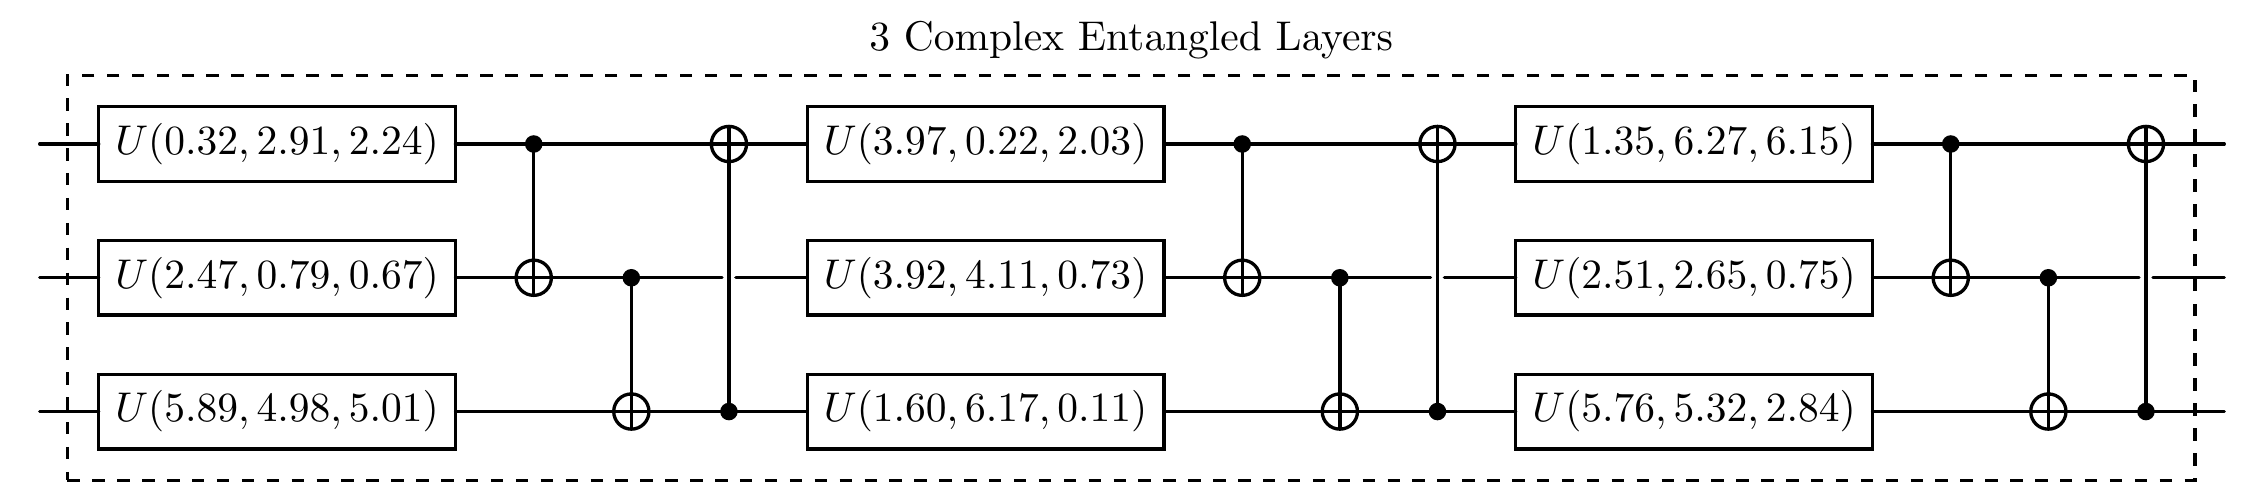

None


  0%|          | 0/50 [00:00<?, ?it/s]

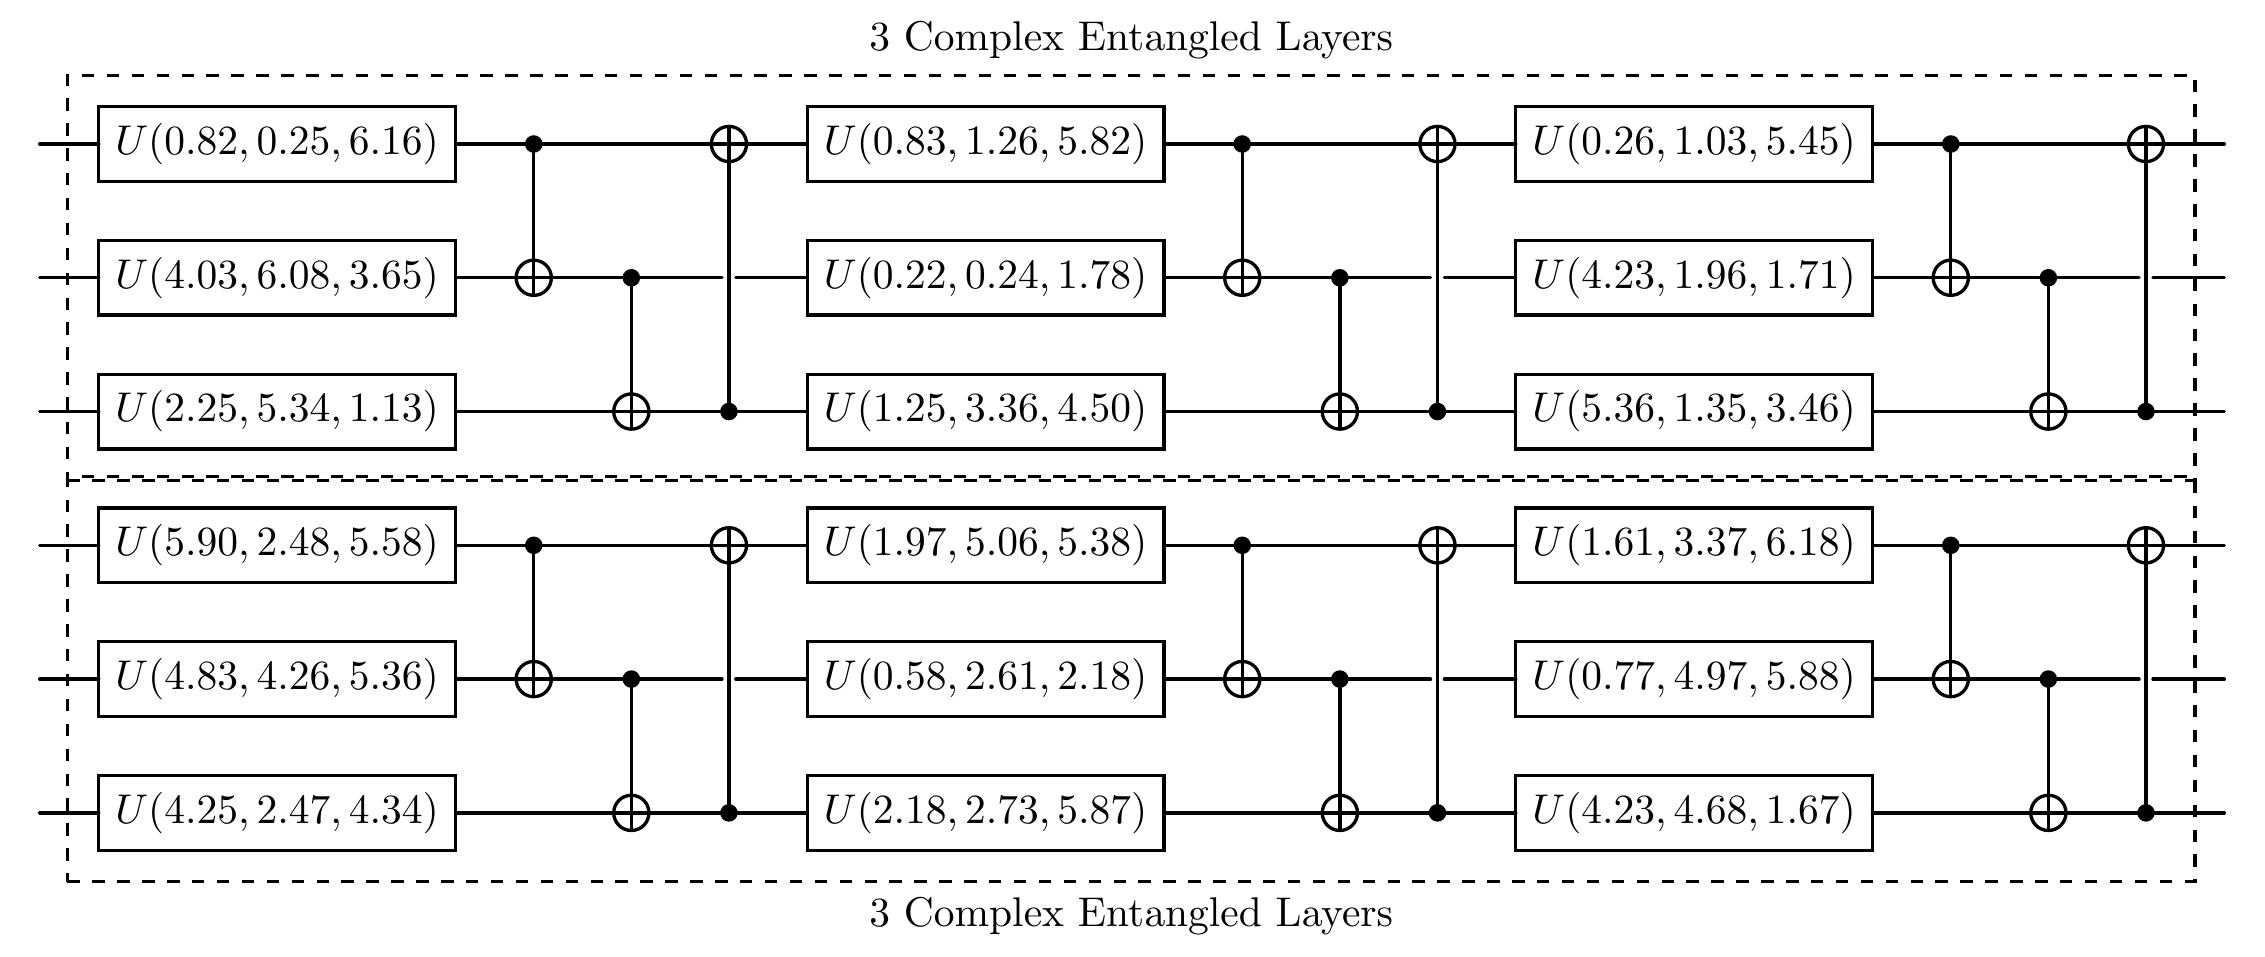

None


  0%|          | 0/50 [00:00<?, ?it/s]

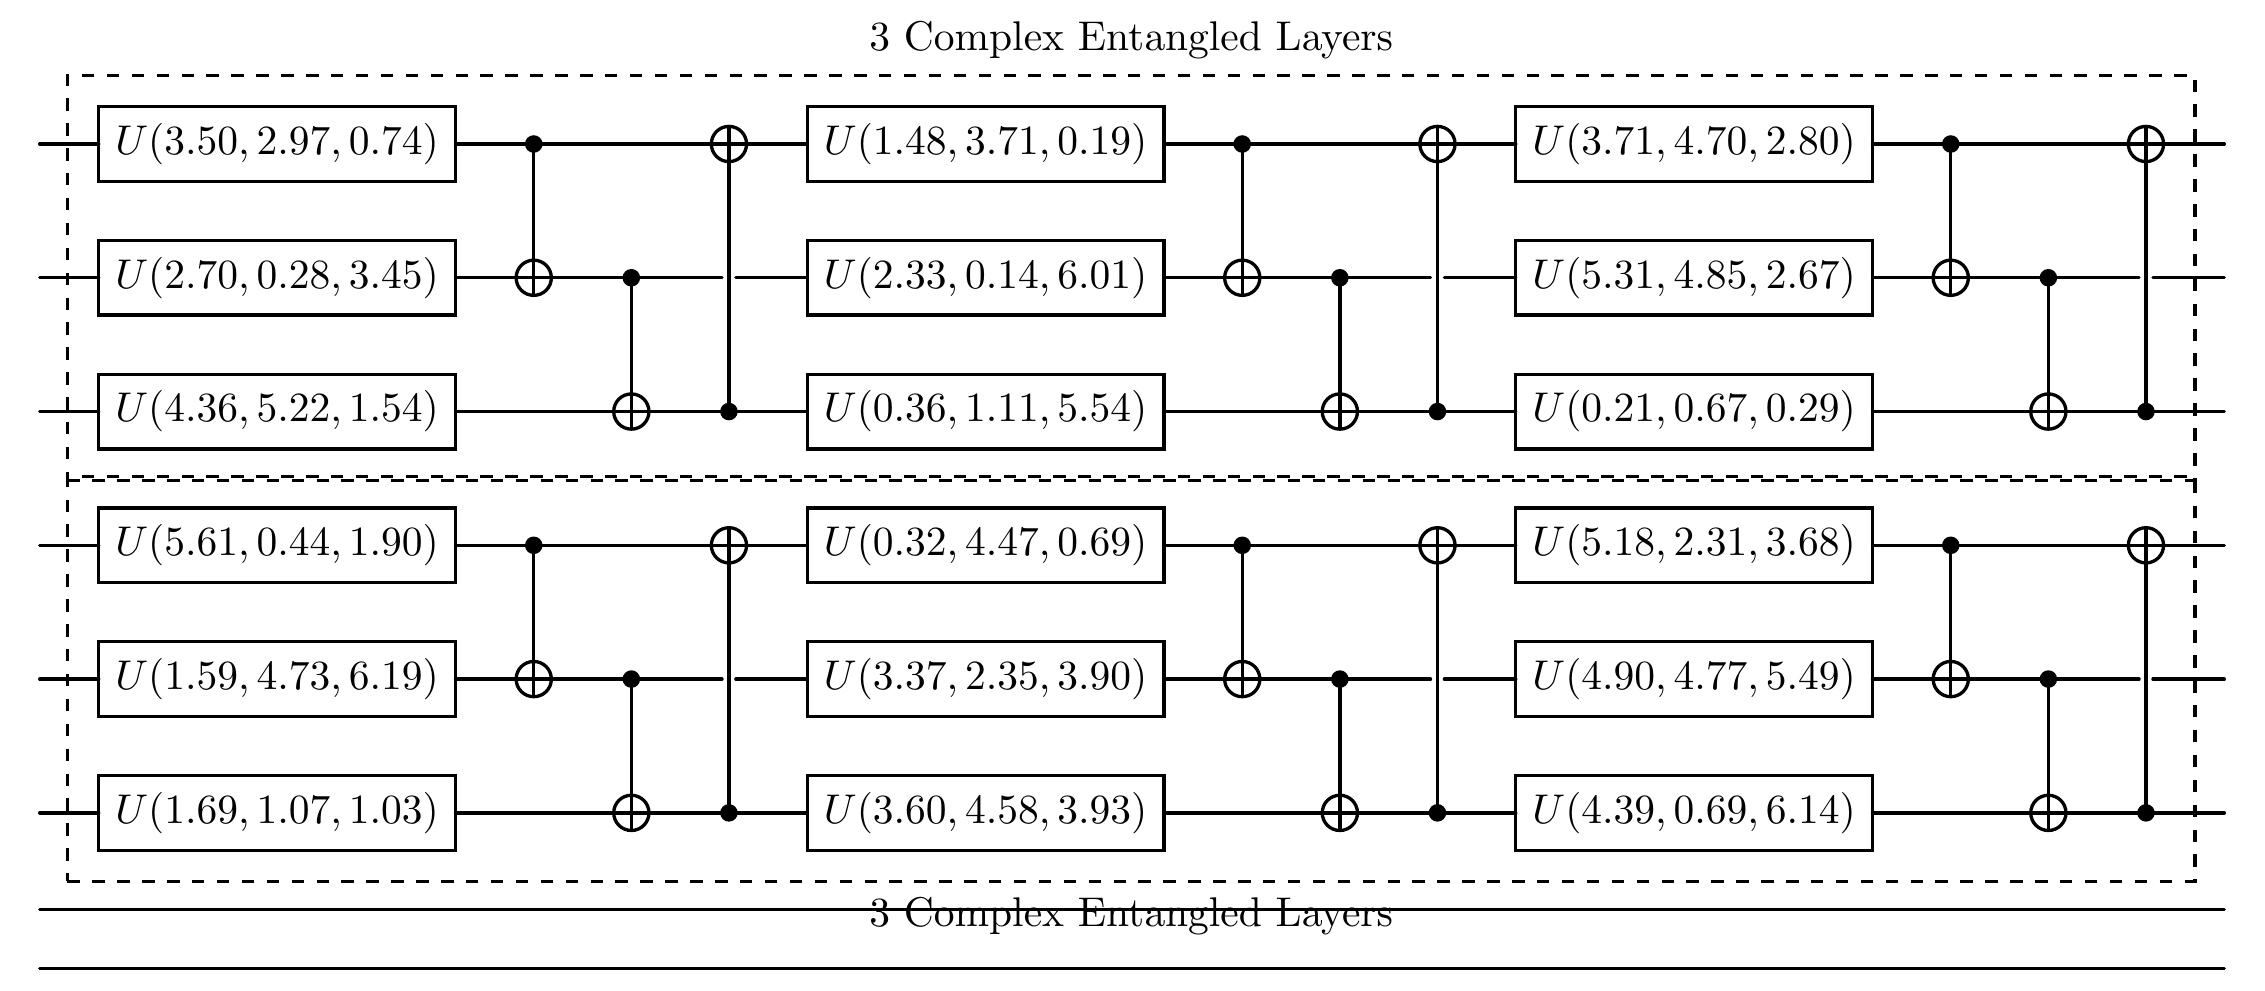

None


  0%|          | 0/50 [00:00<?, ?it/s]

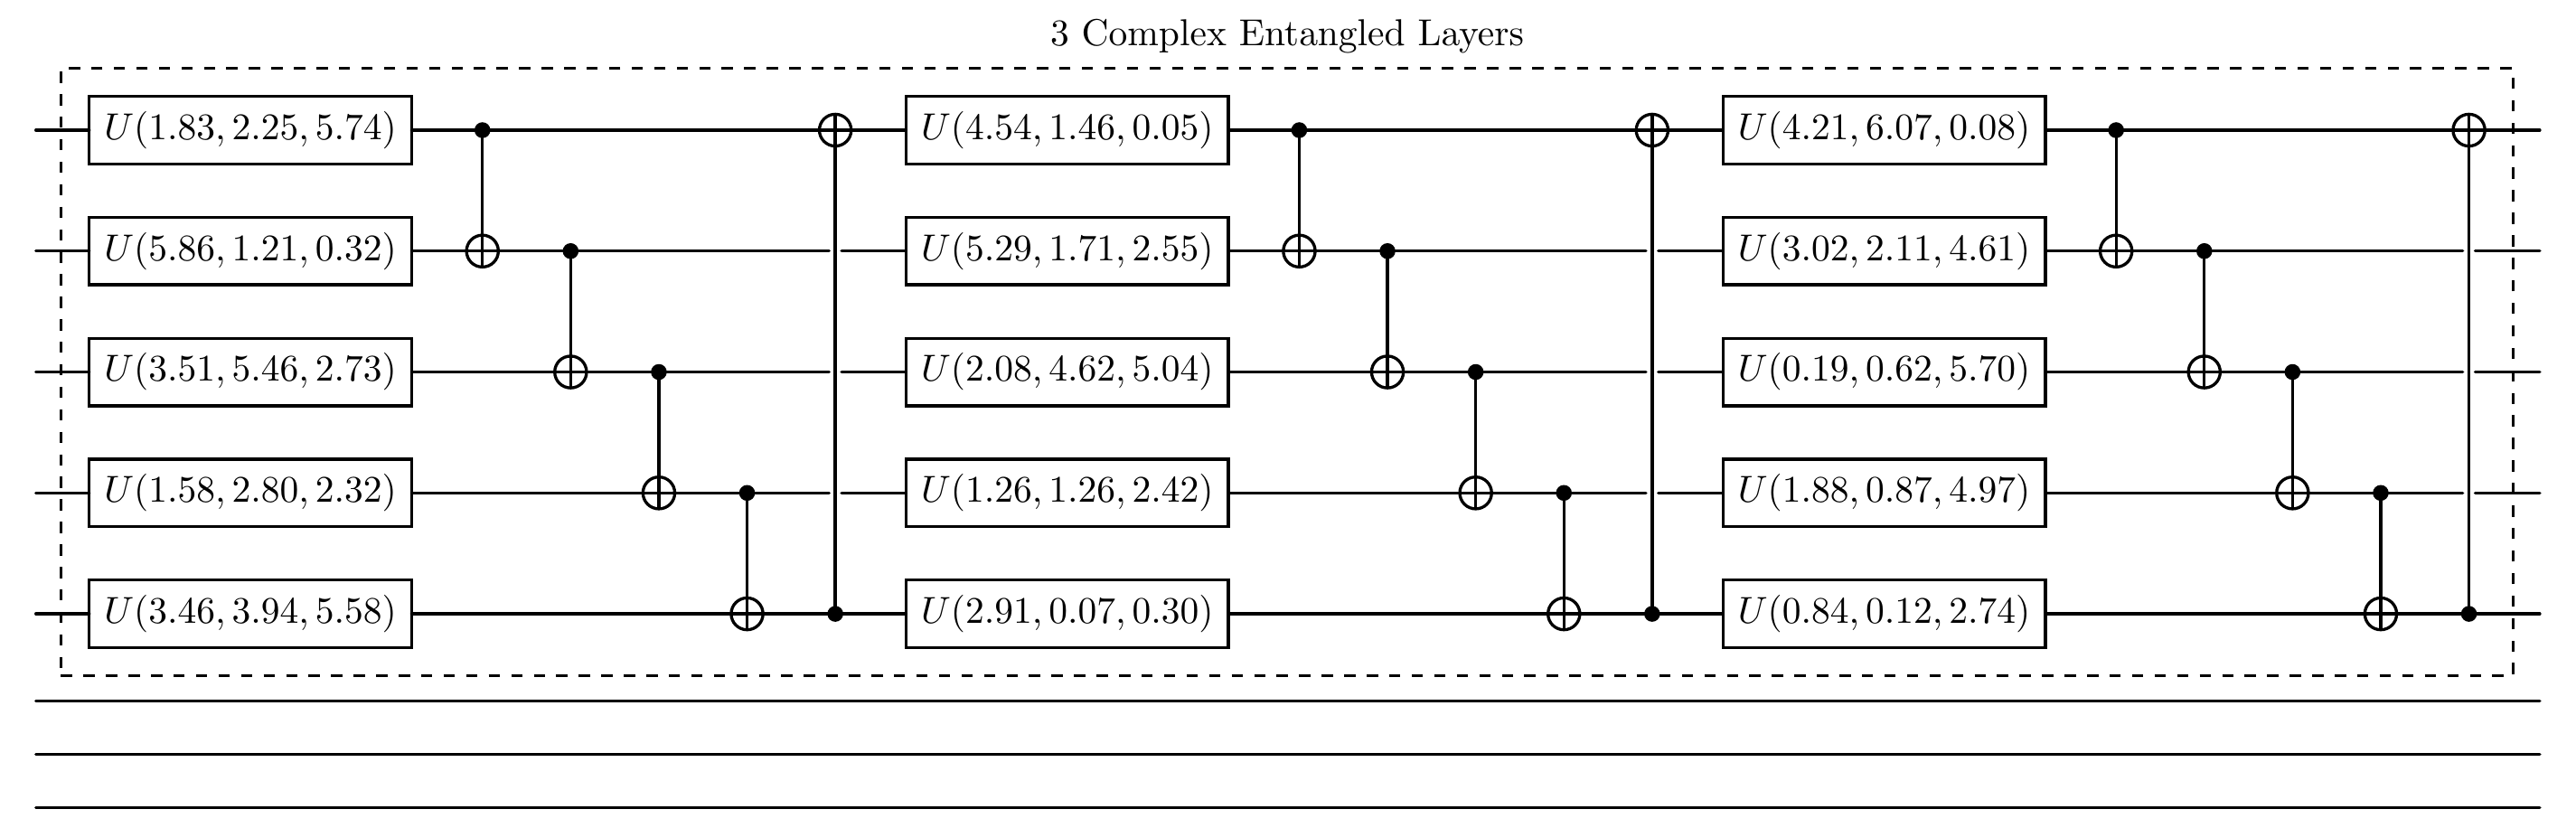

None


  0%|          | 0/50 [00:00<?, ?it/s]

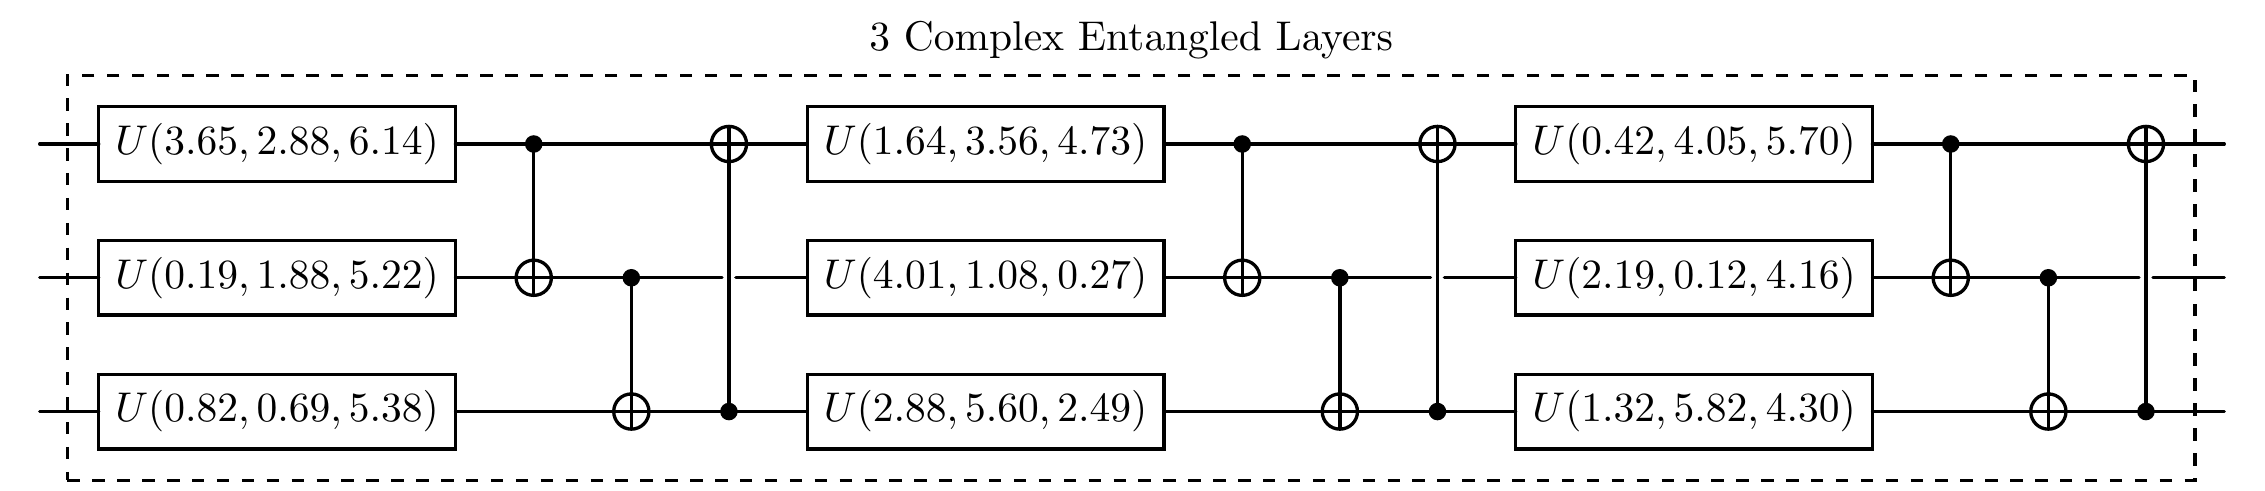

None


  0%|          | 0/50 [00:00<?, ?it/s]

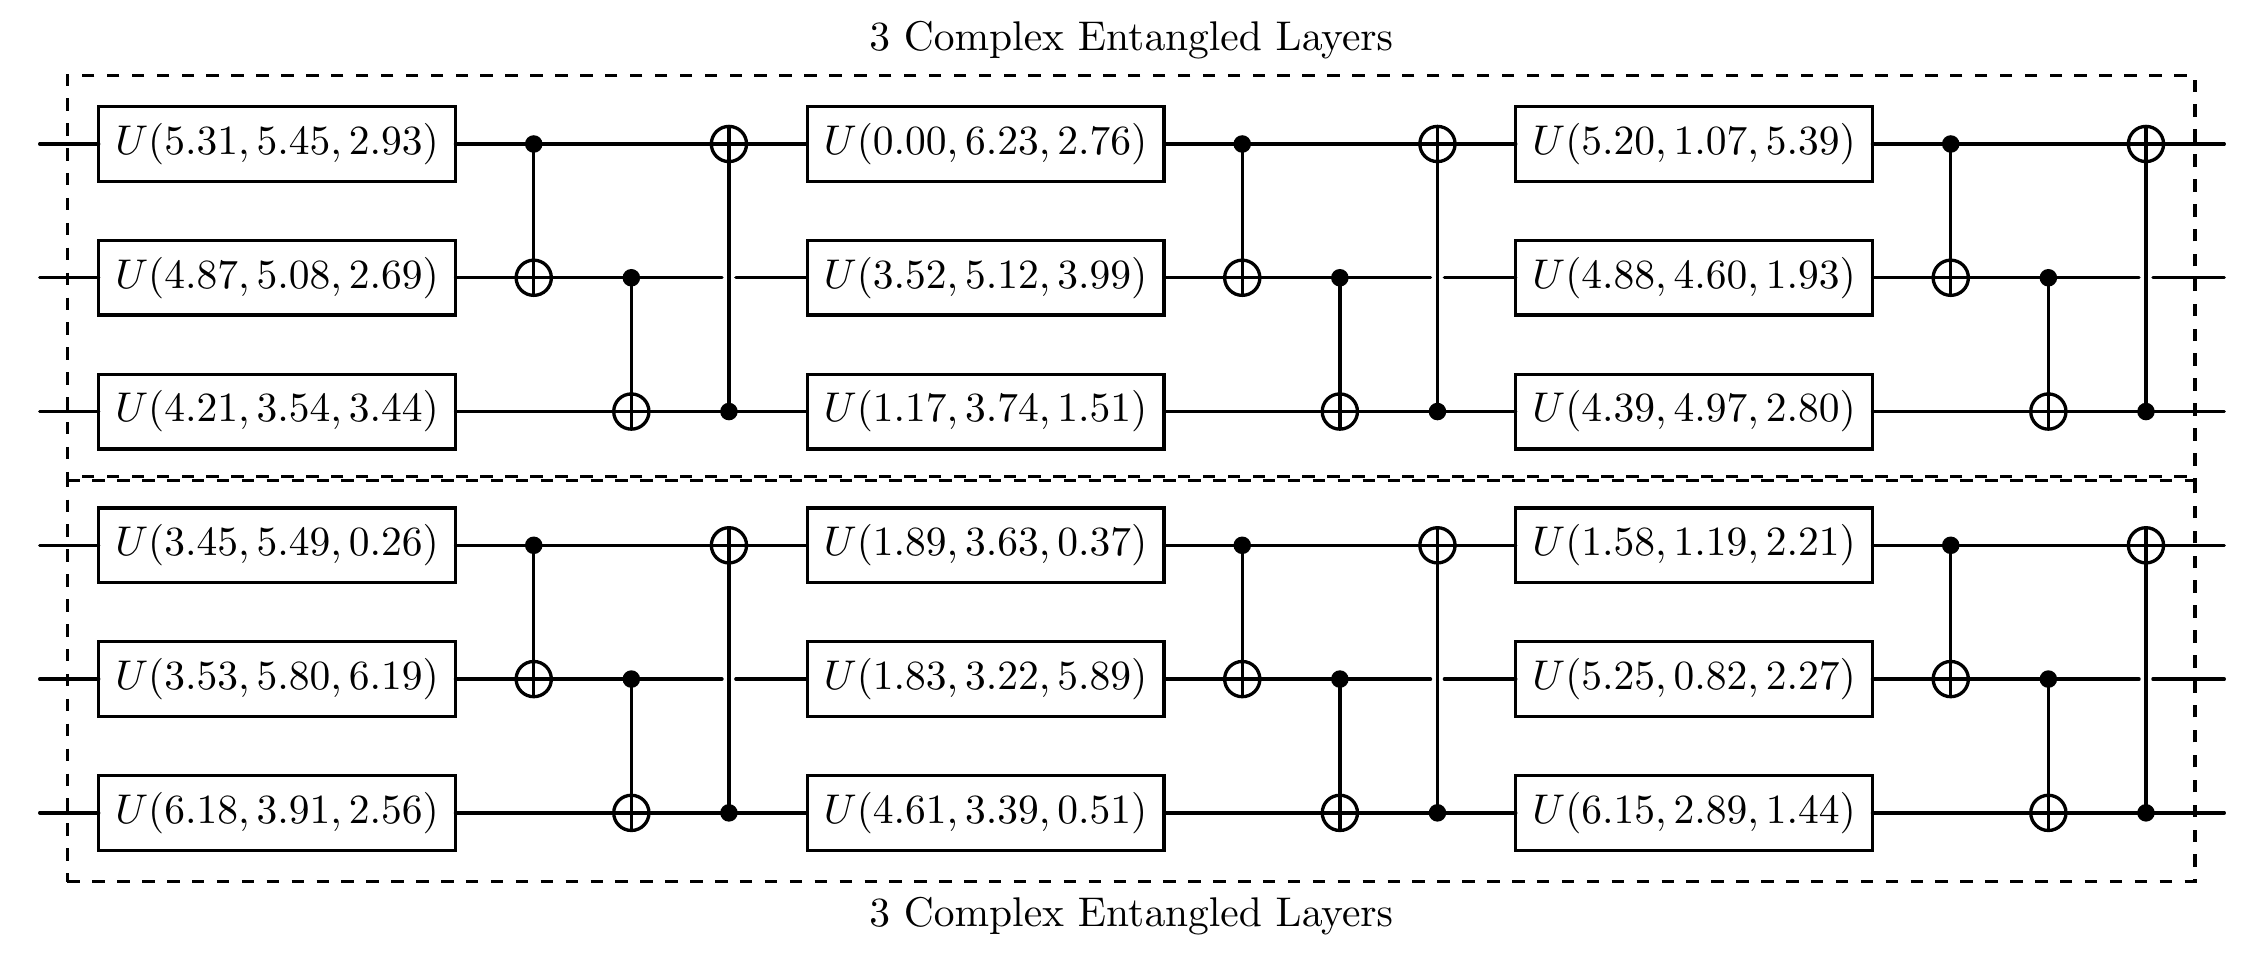

None


  0%|          | 0/50 [00:00<?, ?it/s]

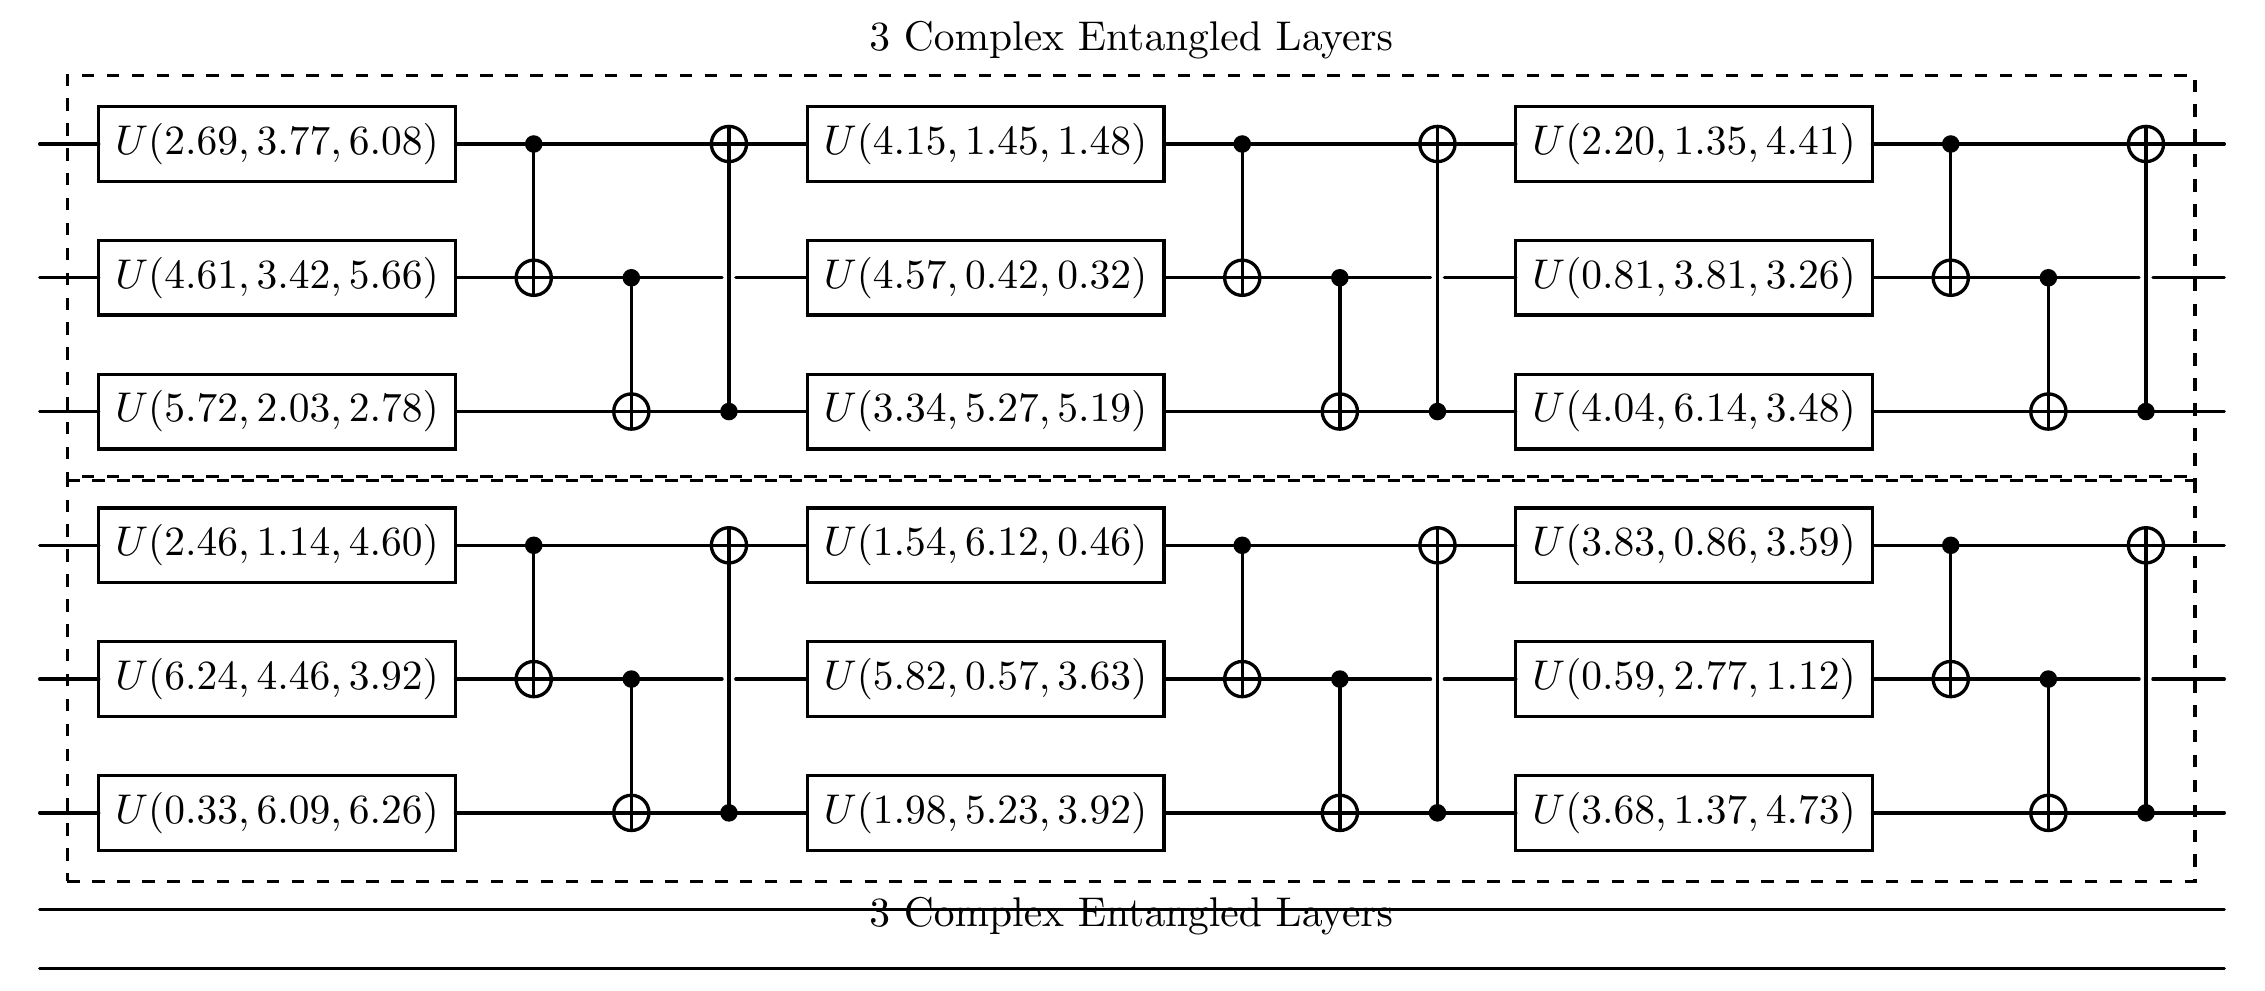

None


  0%|          | 0/50 [00:00<?, ?it/s]

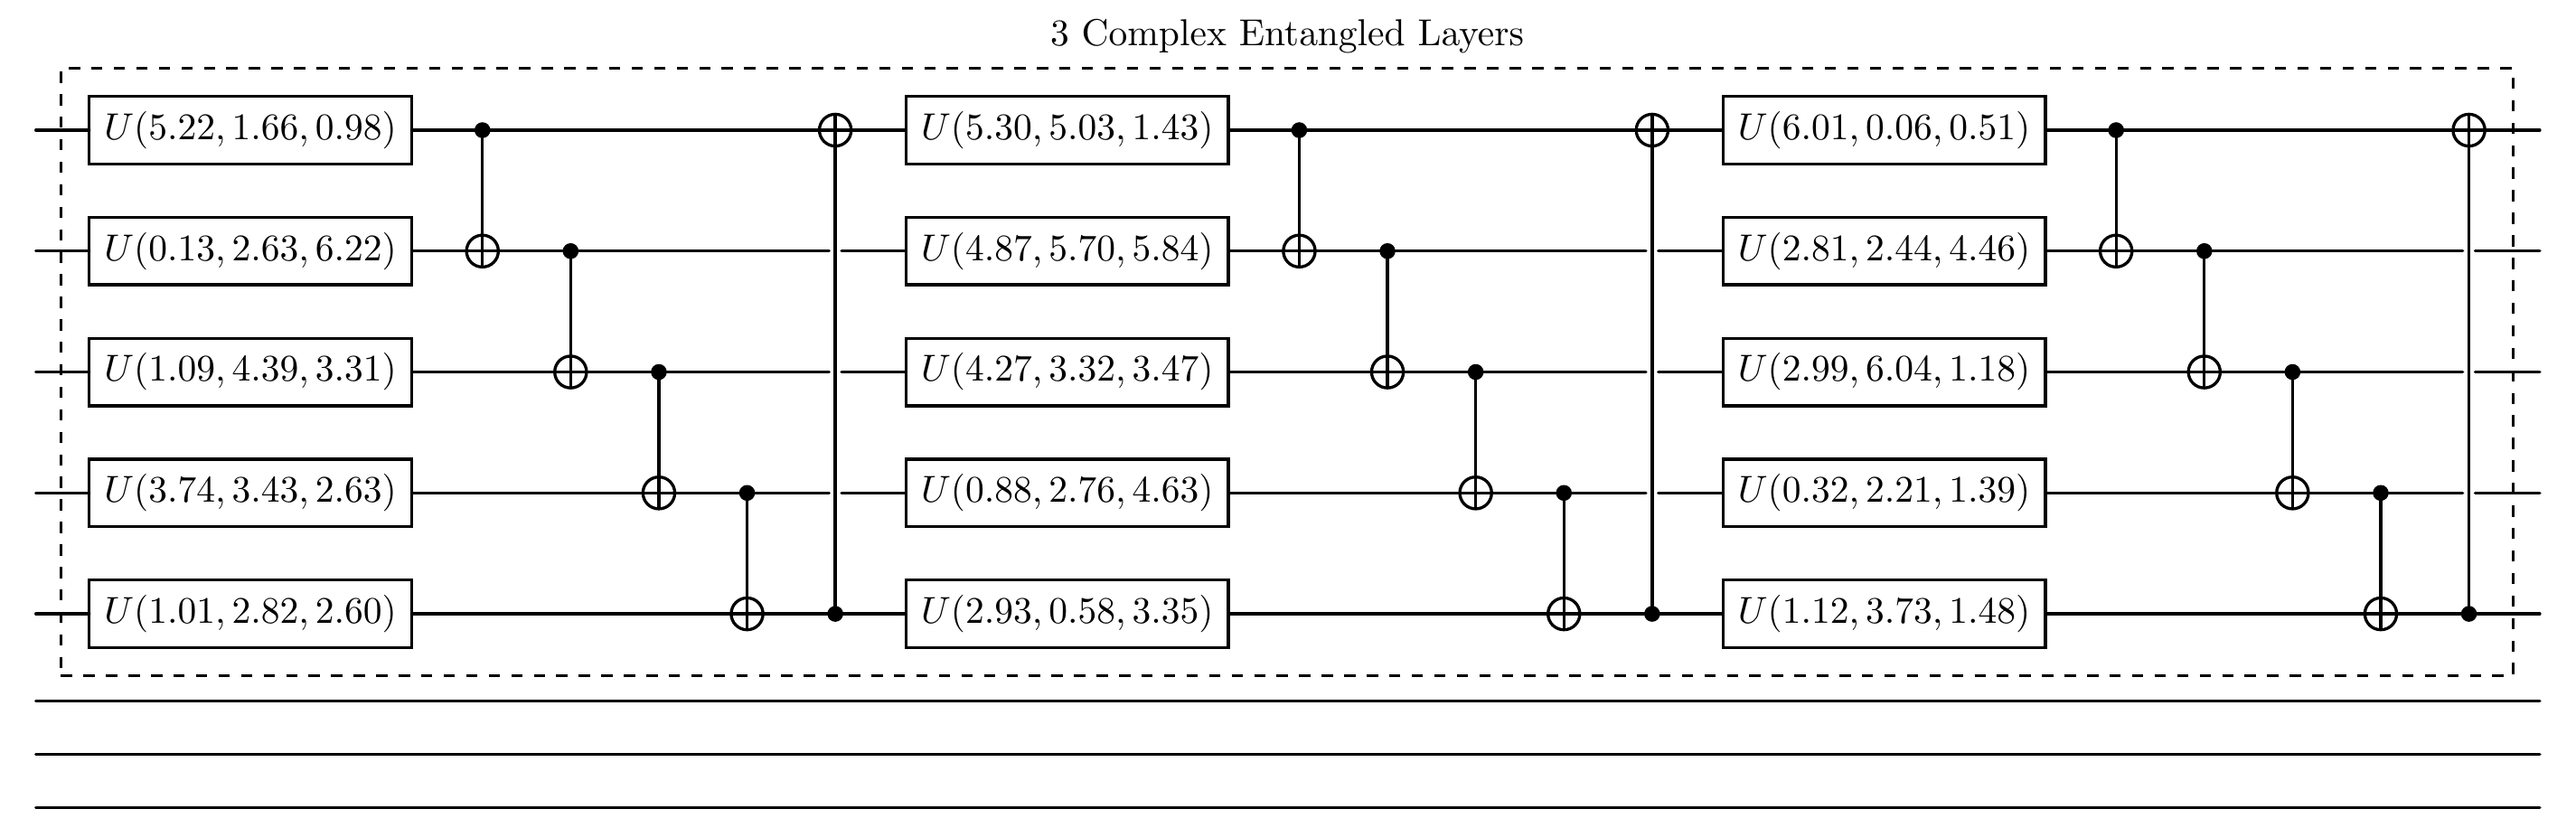

None


  0%|          | 0/50 [00:00<?, ?it/s]

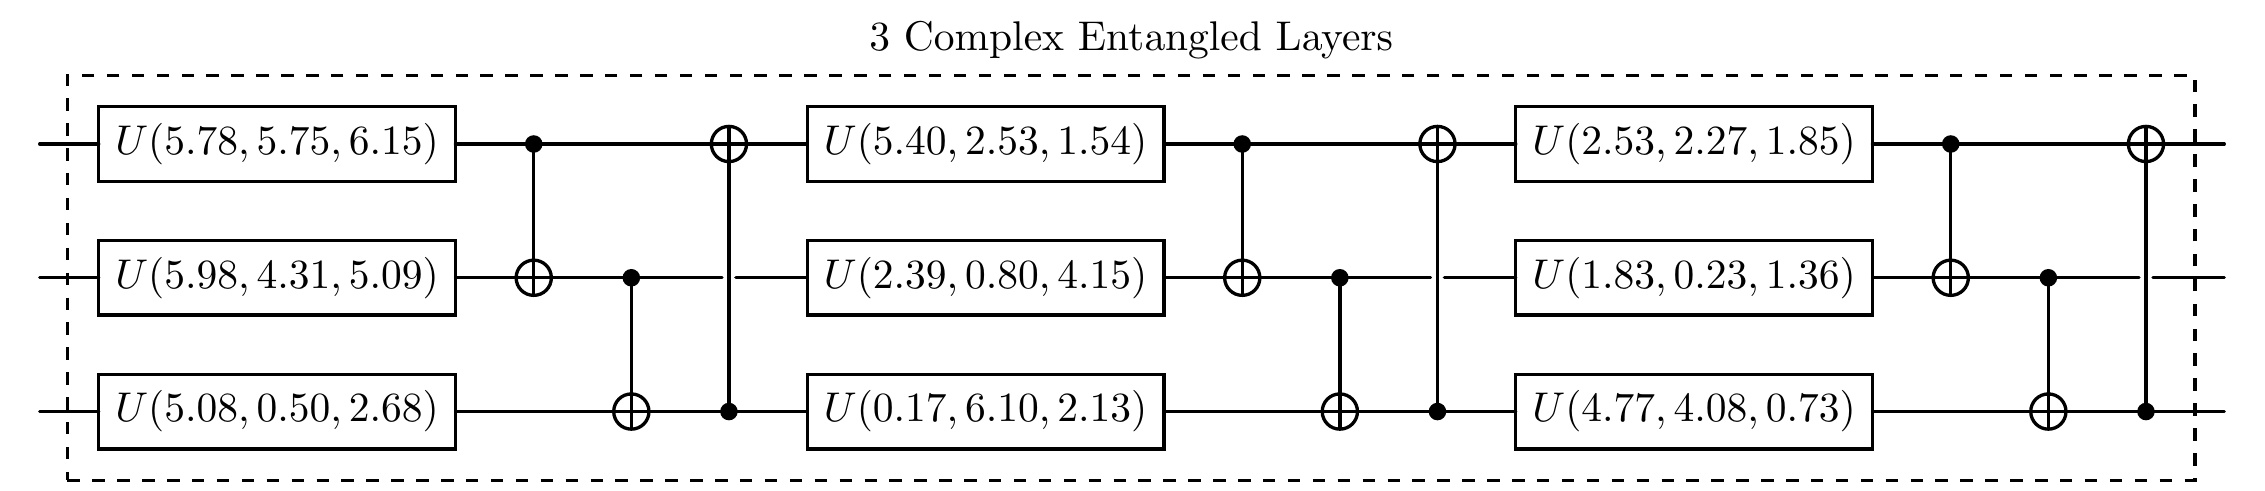

None


  0%|          | 0/50 [00:00<?, ?it/s]

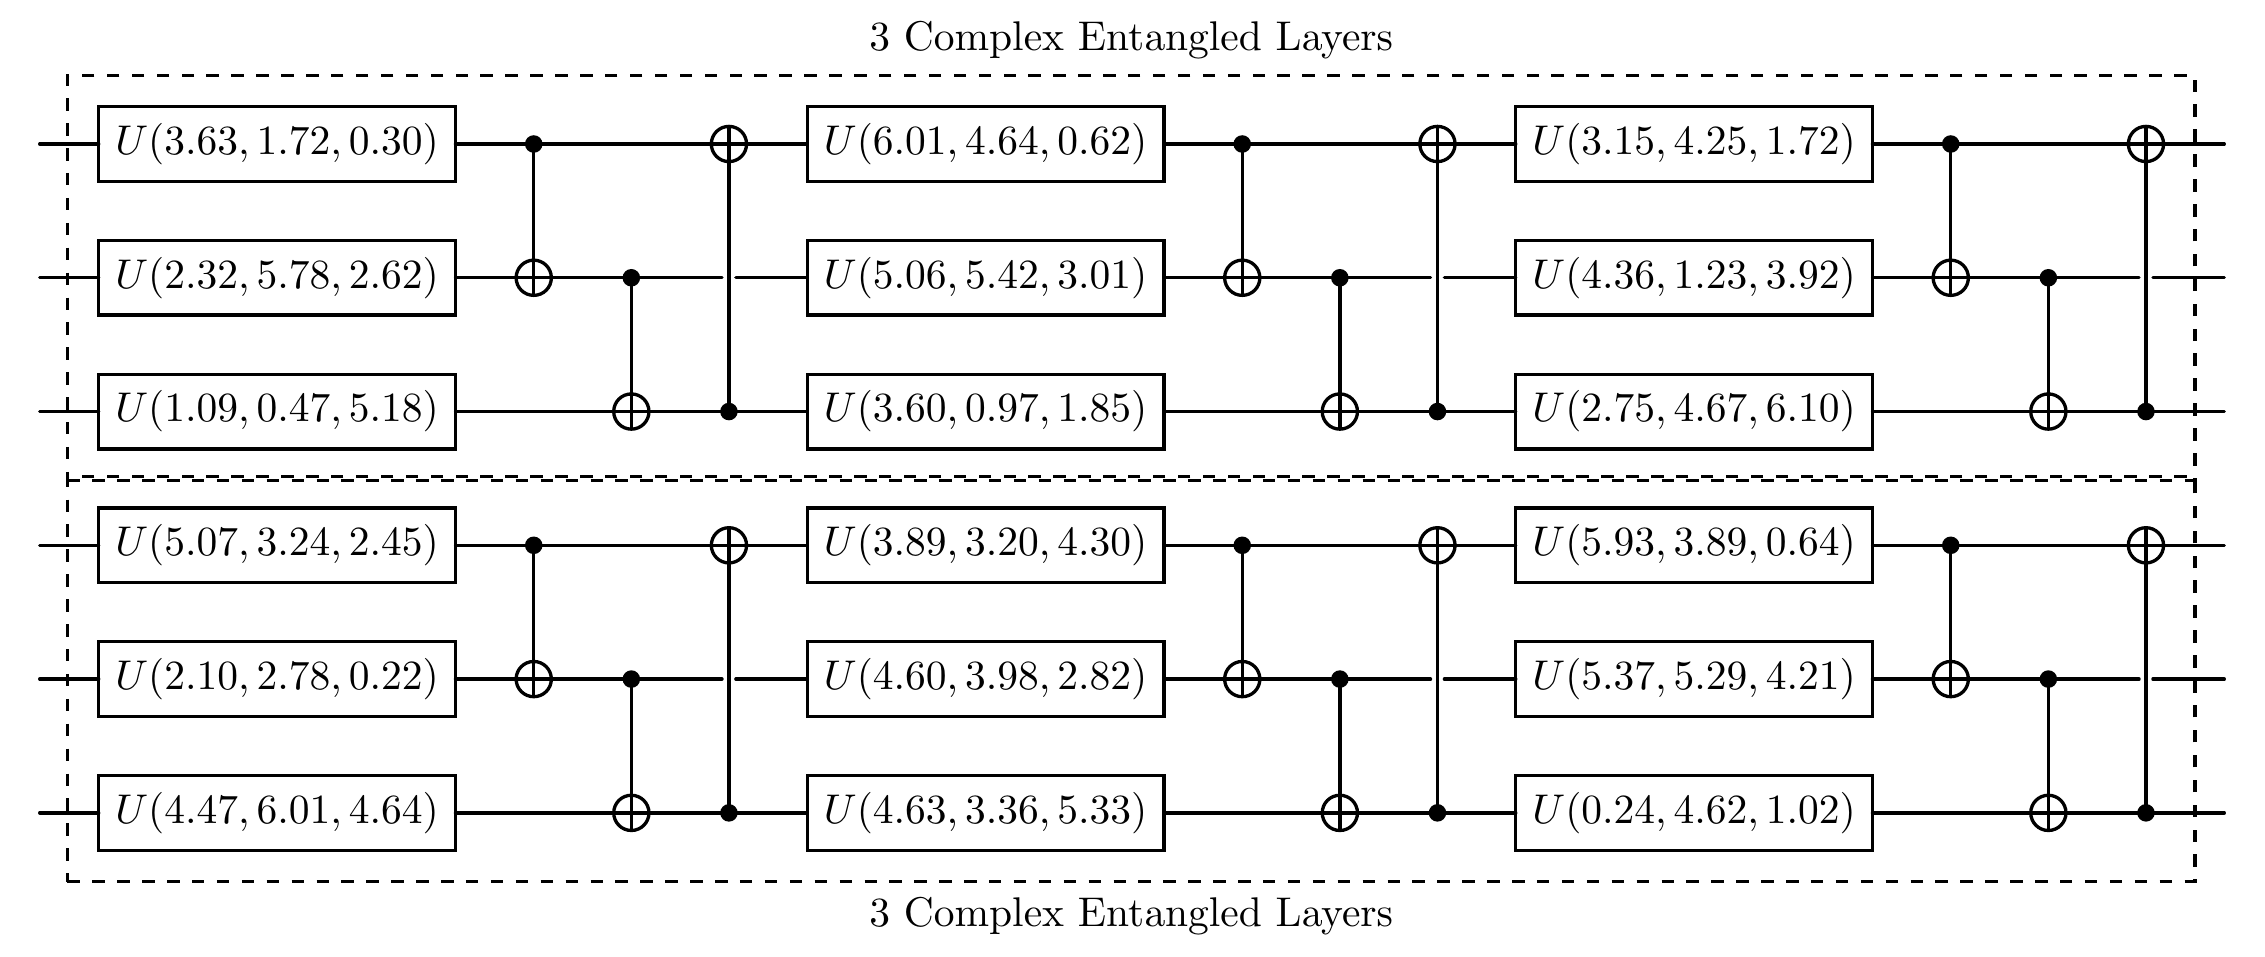

None


  0%|          | 0/50 [00:00<?, ?it/s]

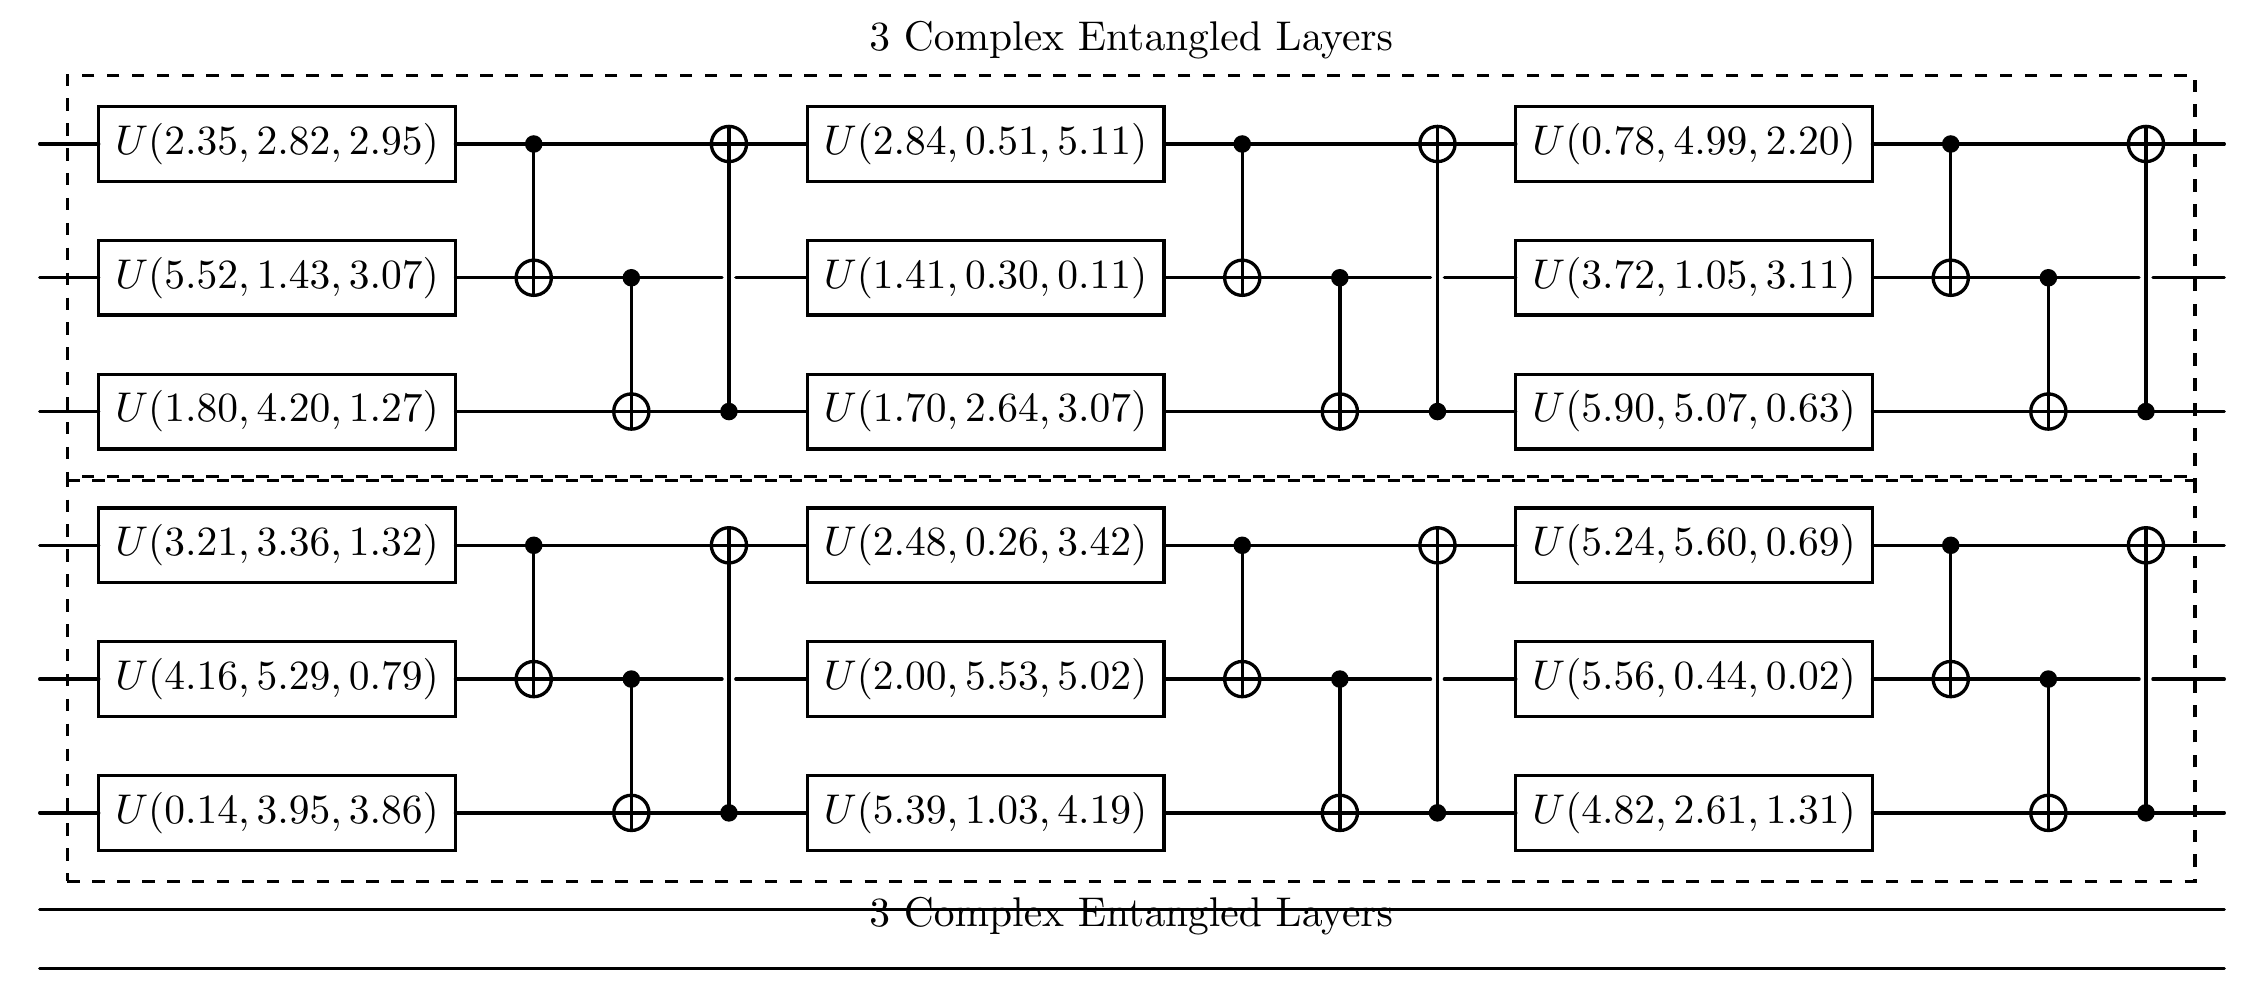

None


  0%|          | 0/50 [00:00<?, ?it/s]

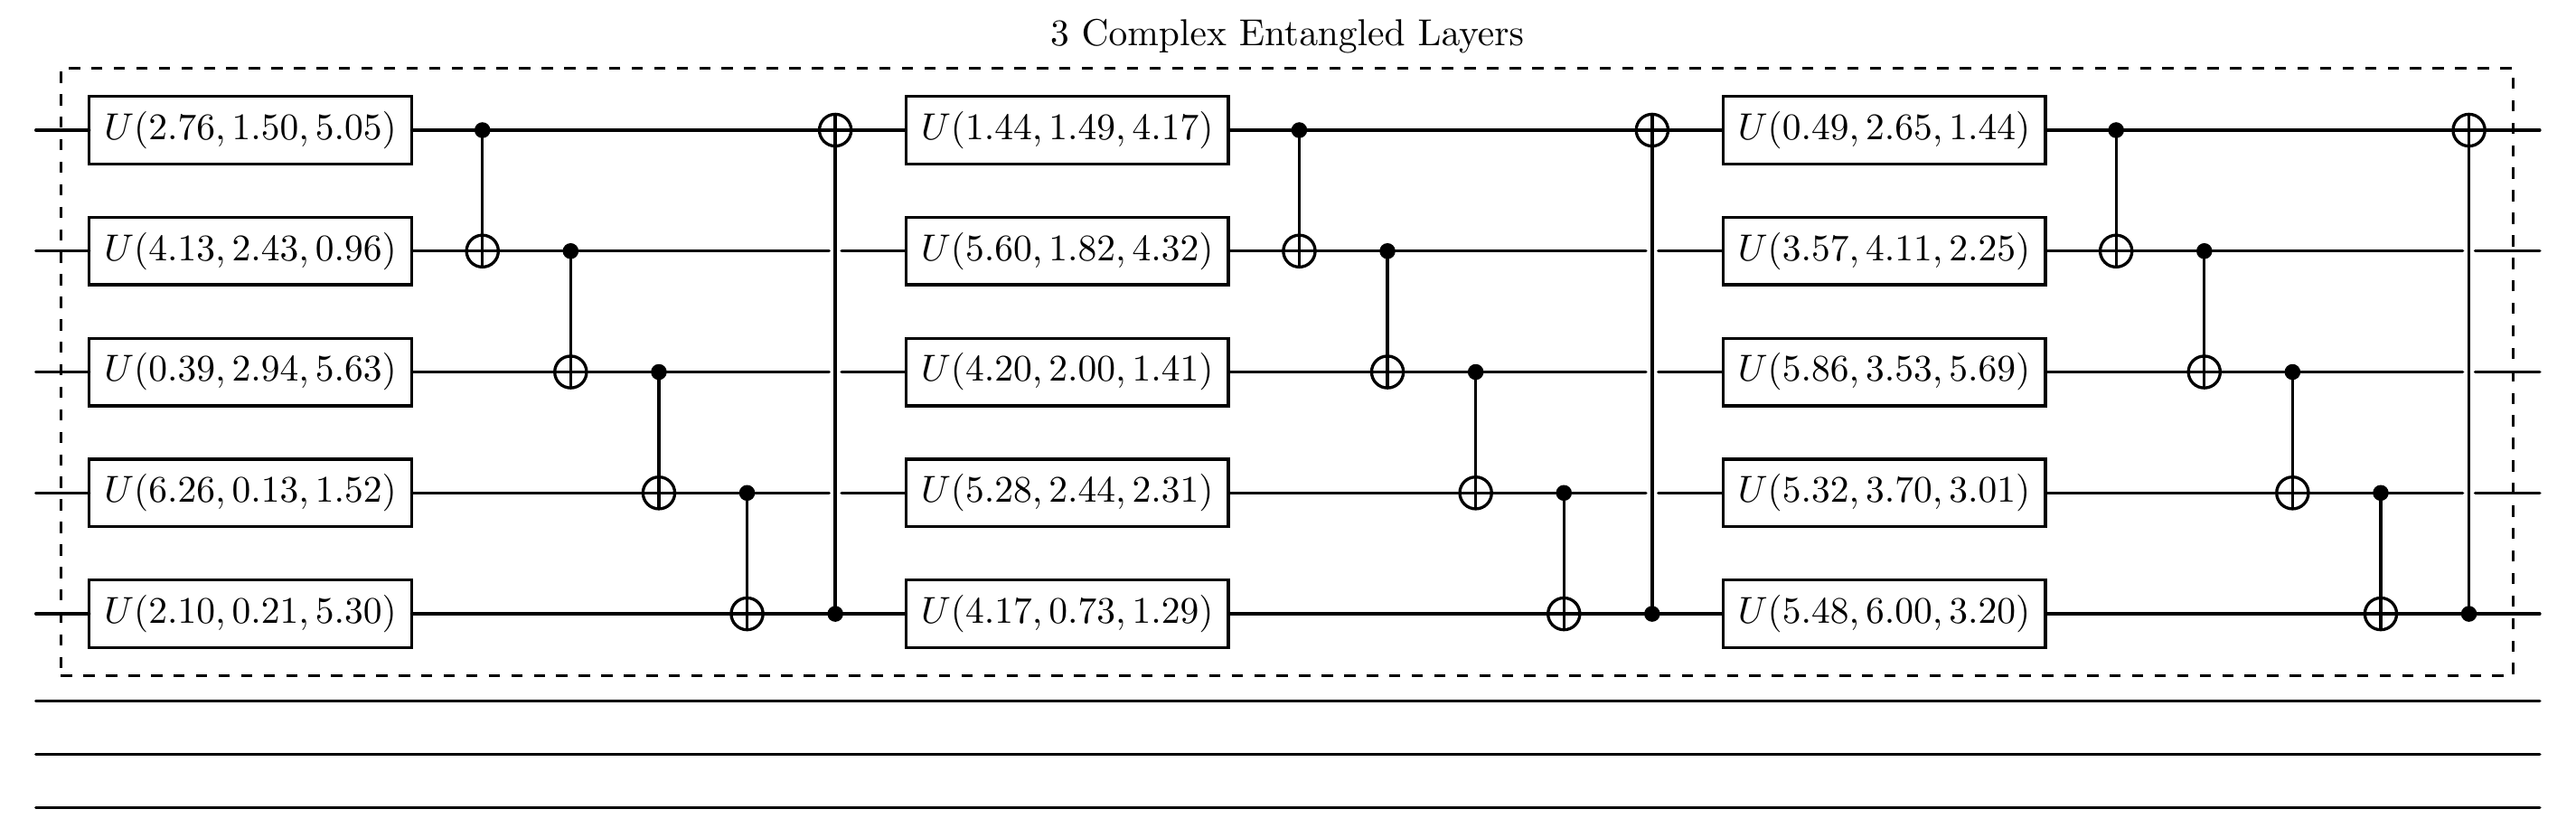

None


  0%|          | 0/50 [00:00<?, ?it/s]

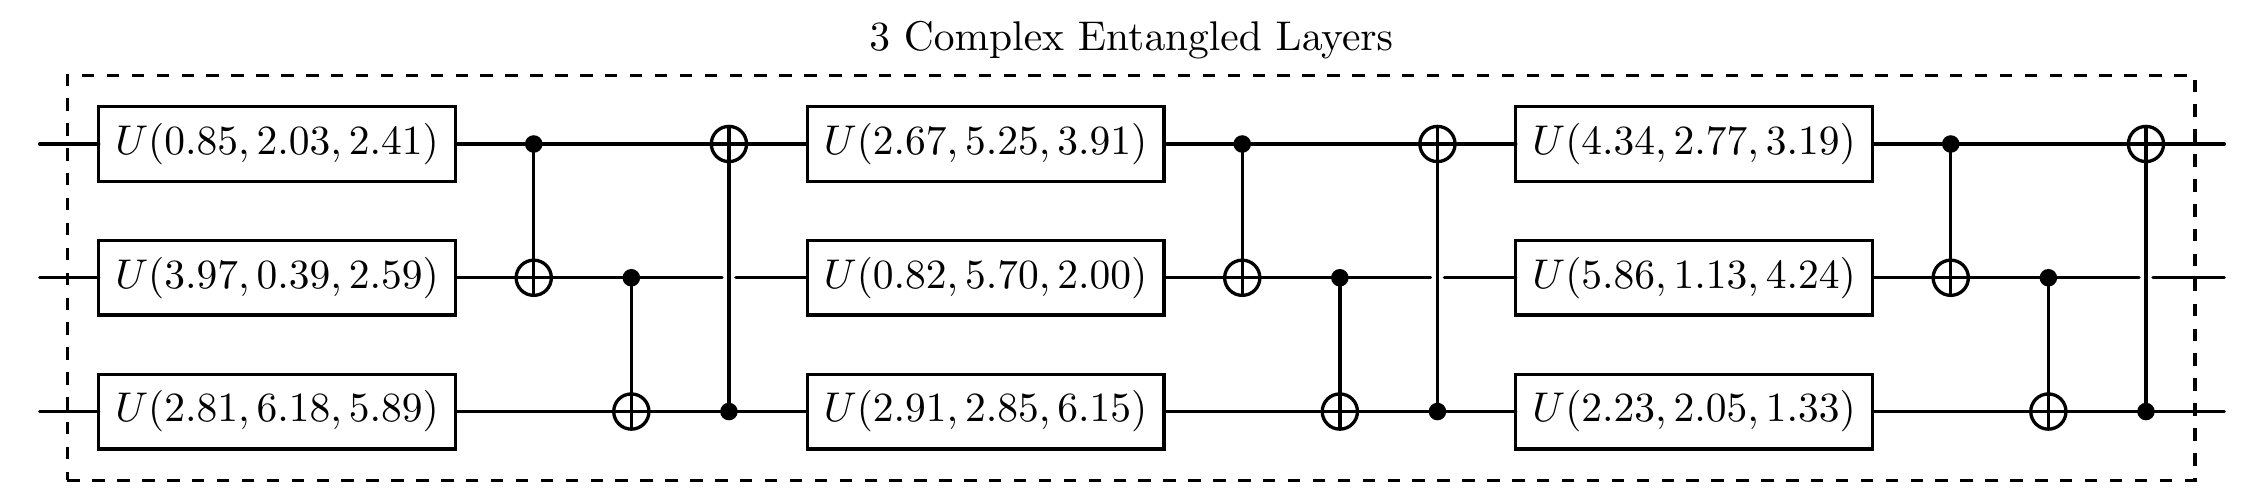

None


  0%|          | 0/50 [00:00<?, ?it/s]

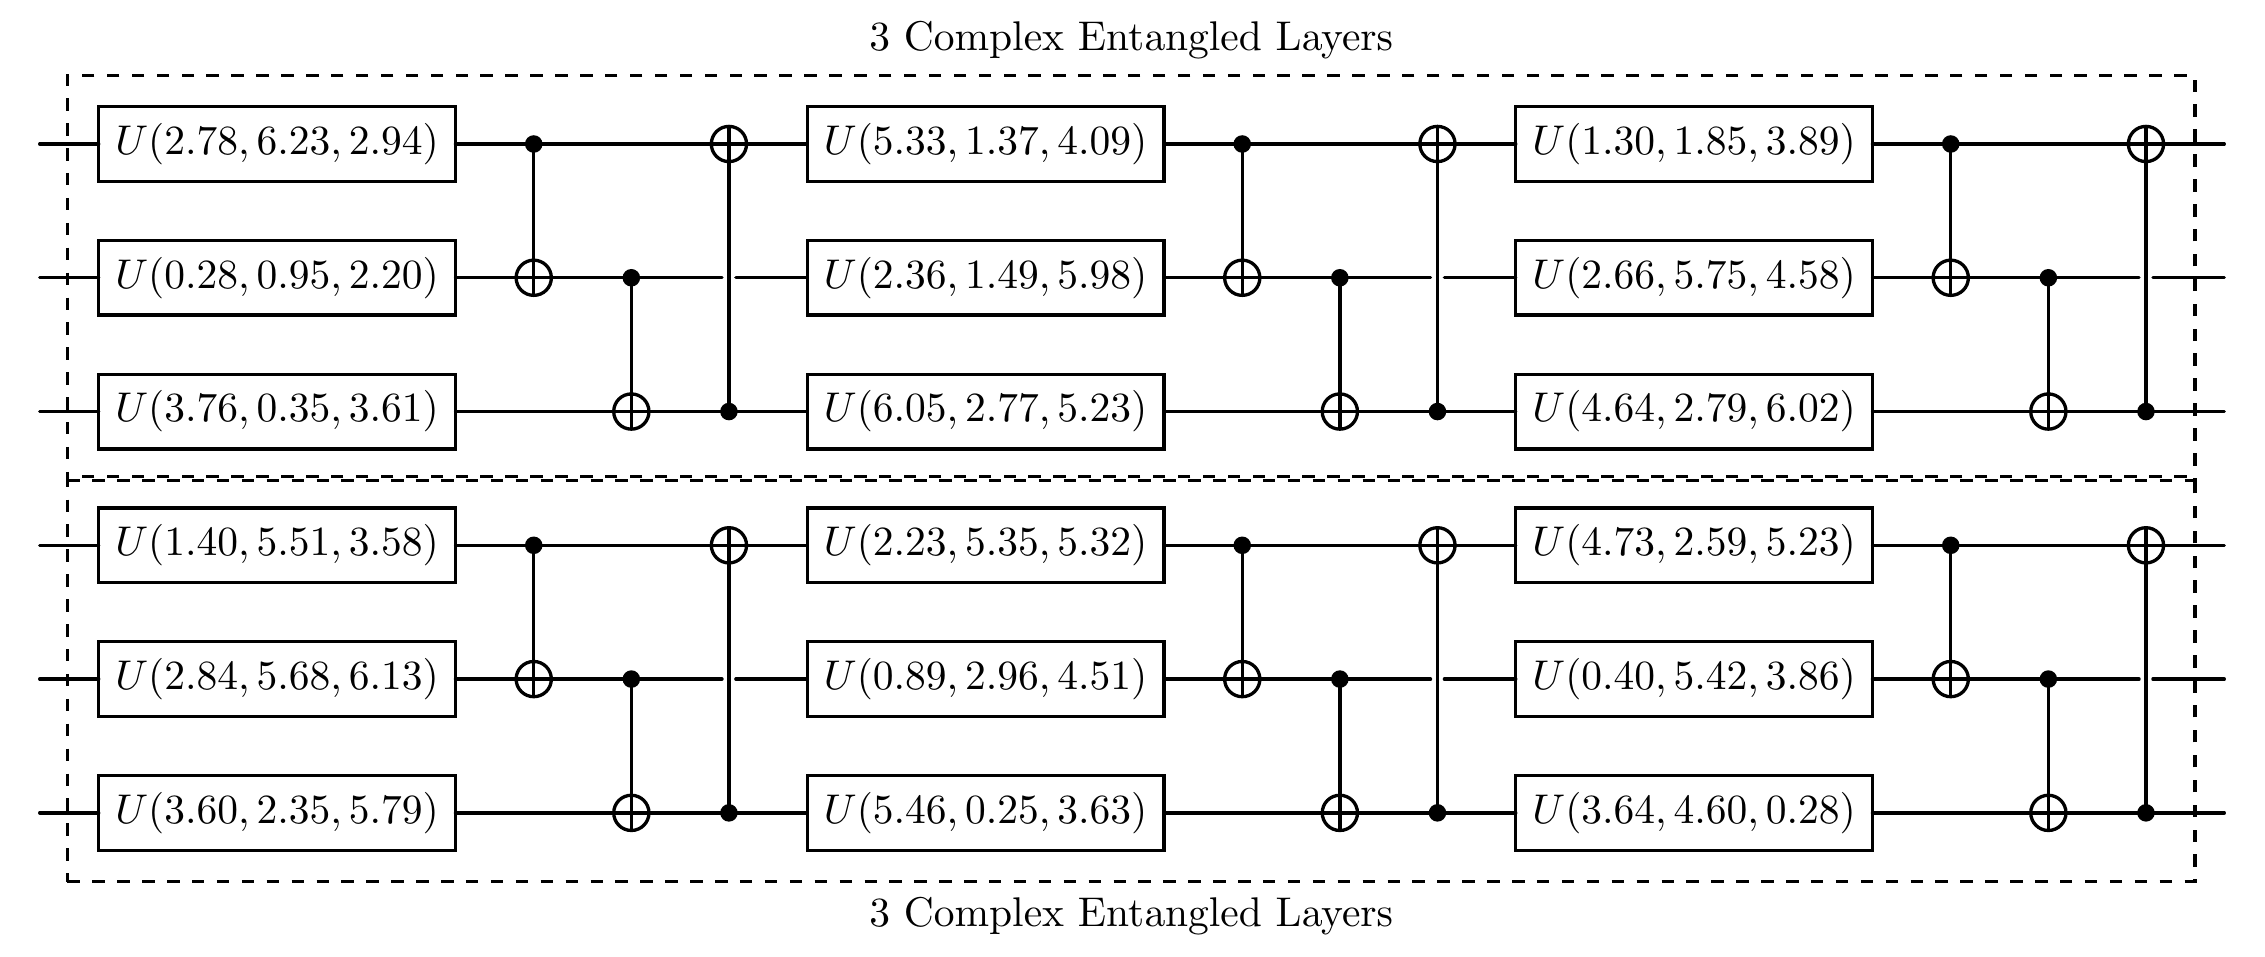

None


  0%|          | 0/50 [00:00<?, ?it/s]

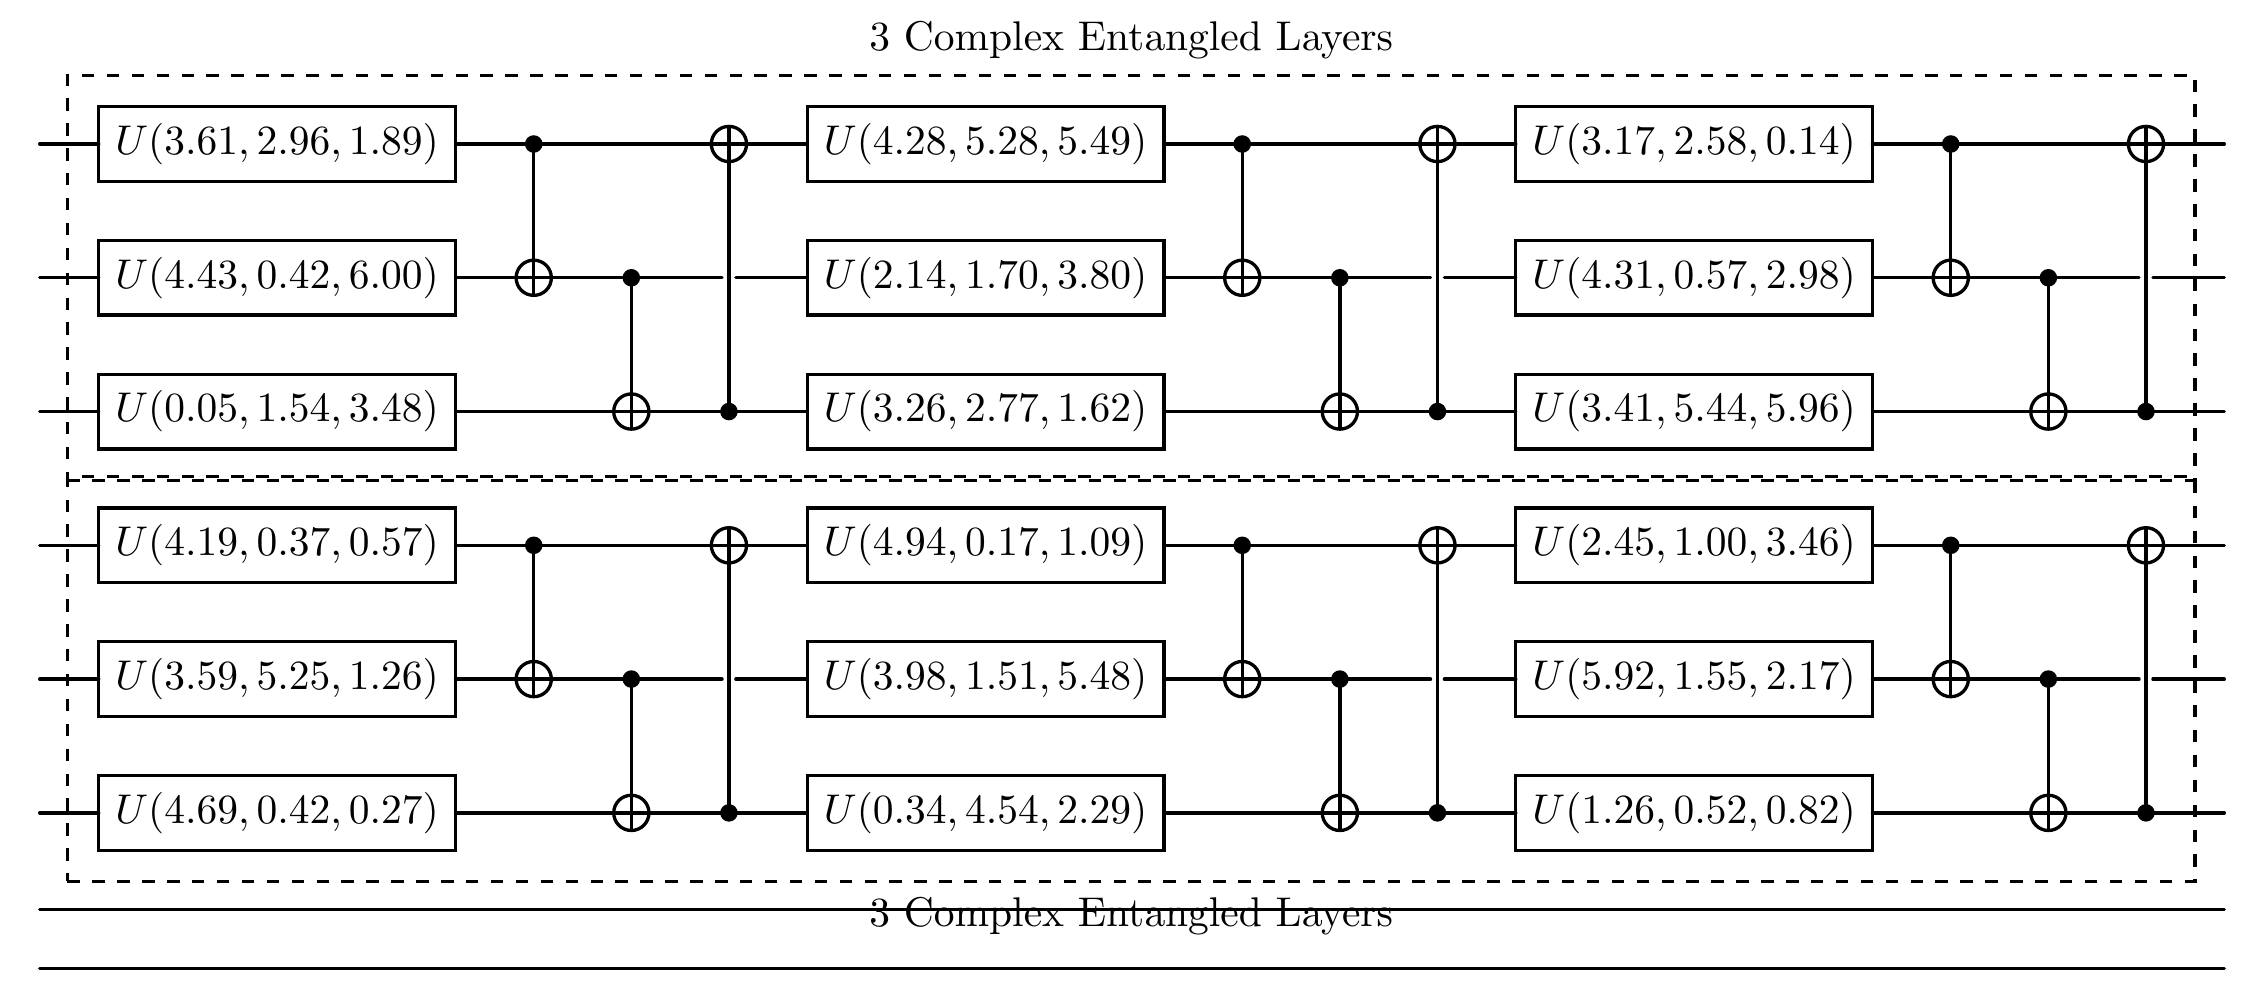

None


  0%|          | 0/50 [00:00<?, ?it/s]

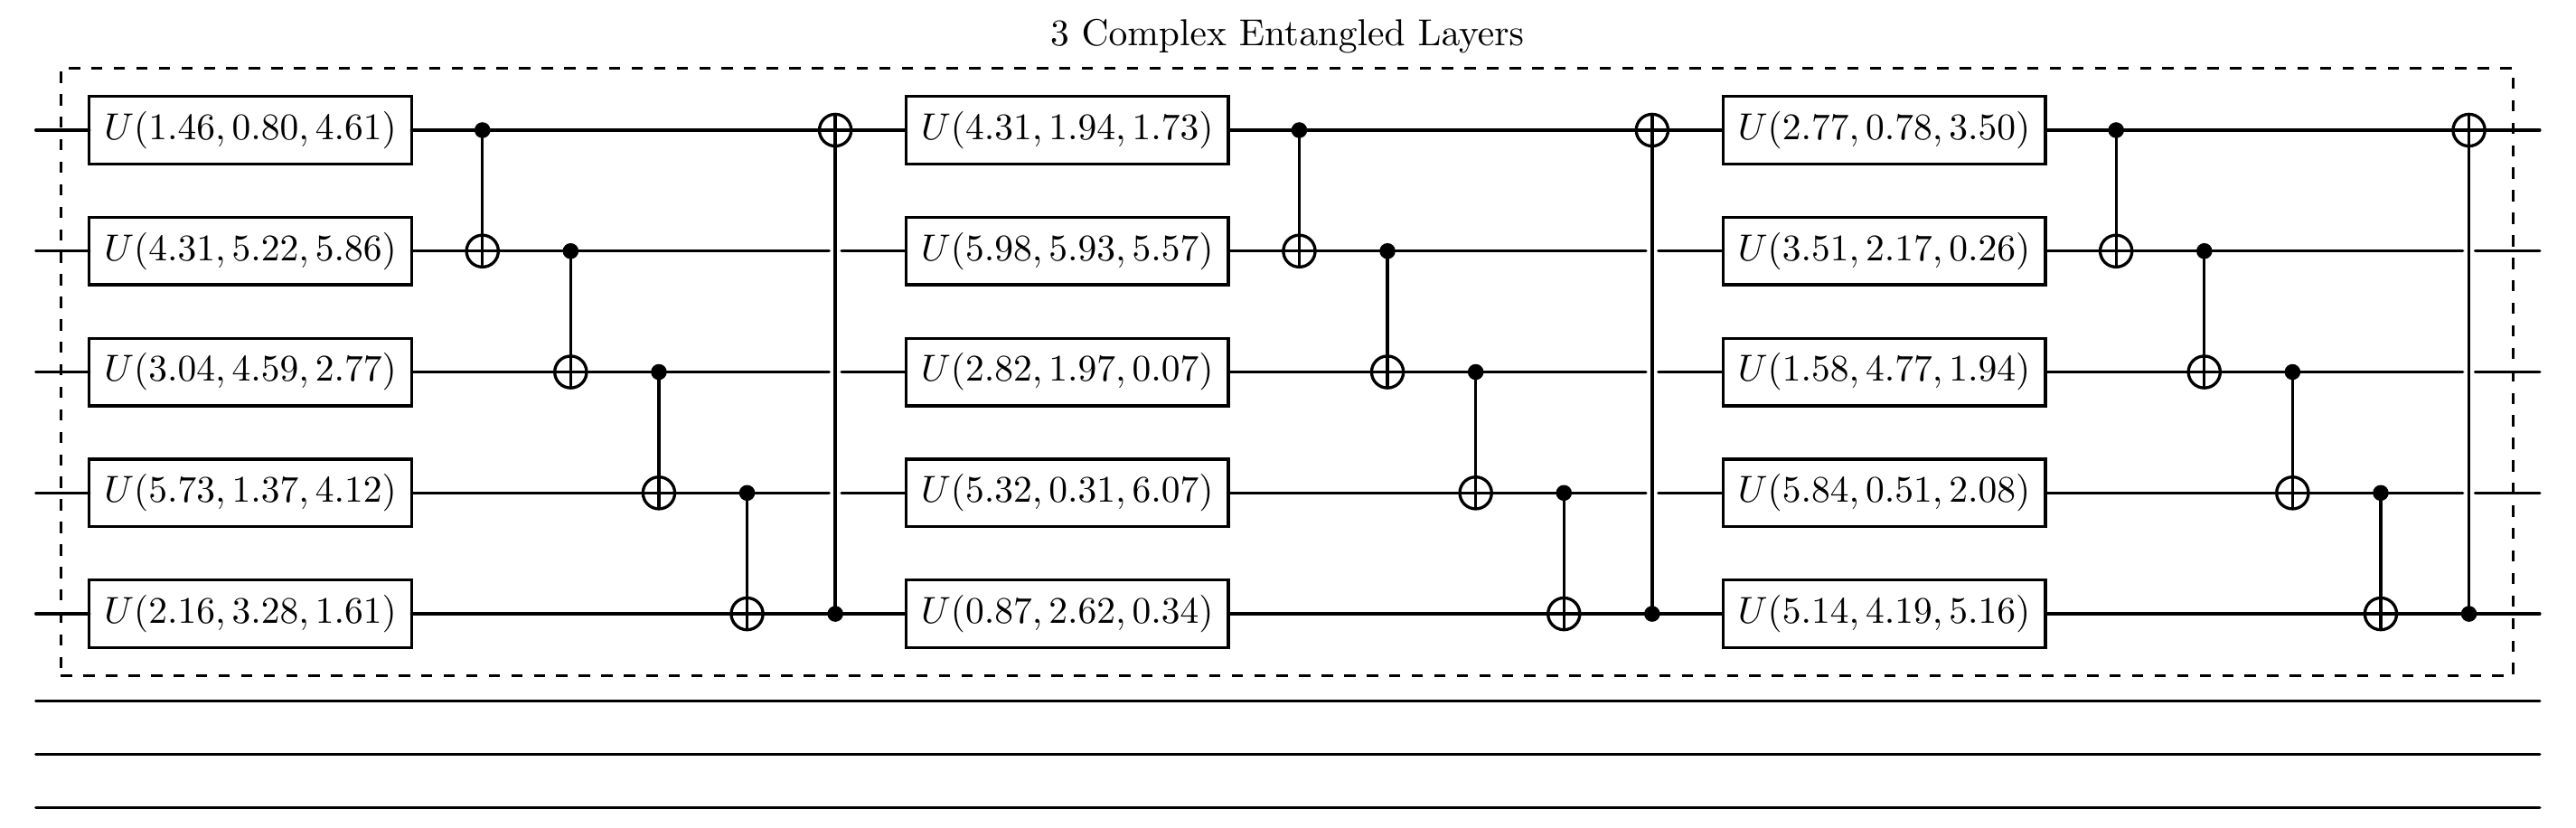

None


  0%|          | 0/50 [00:00<?, ?it/s]

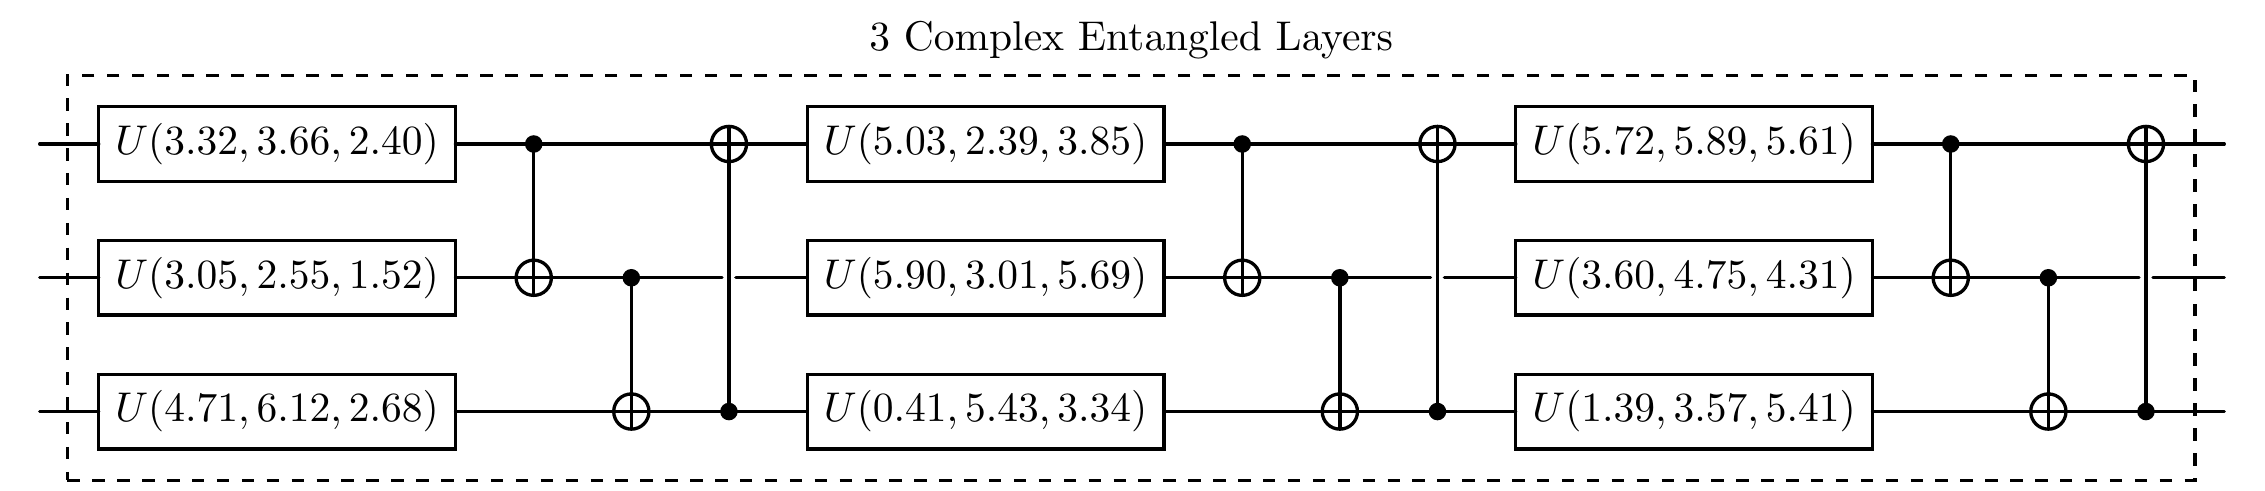

None


  0%|          | 0/50 [00:00<?, ?it/s]

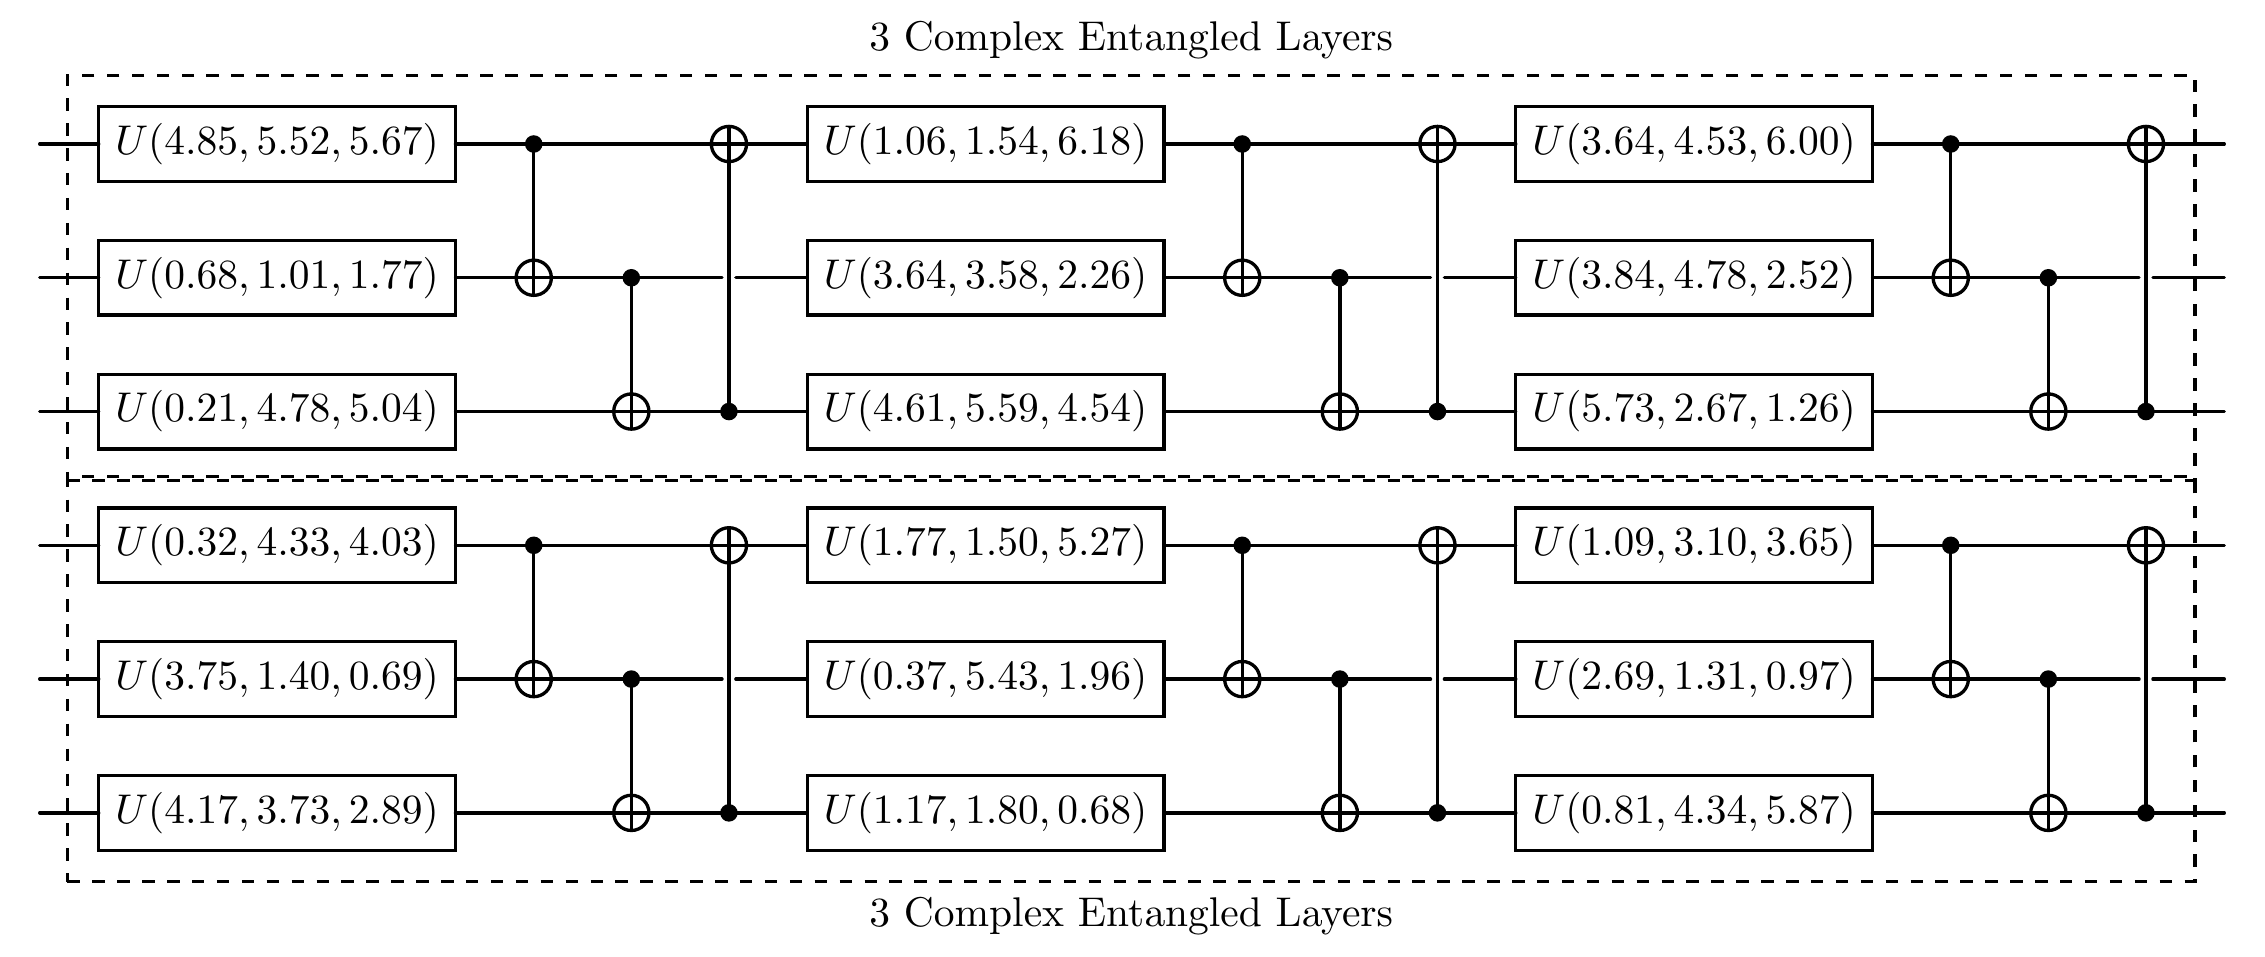

None


  0%|          | 0/50 [00:00<?, ?it/s]

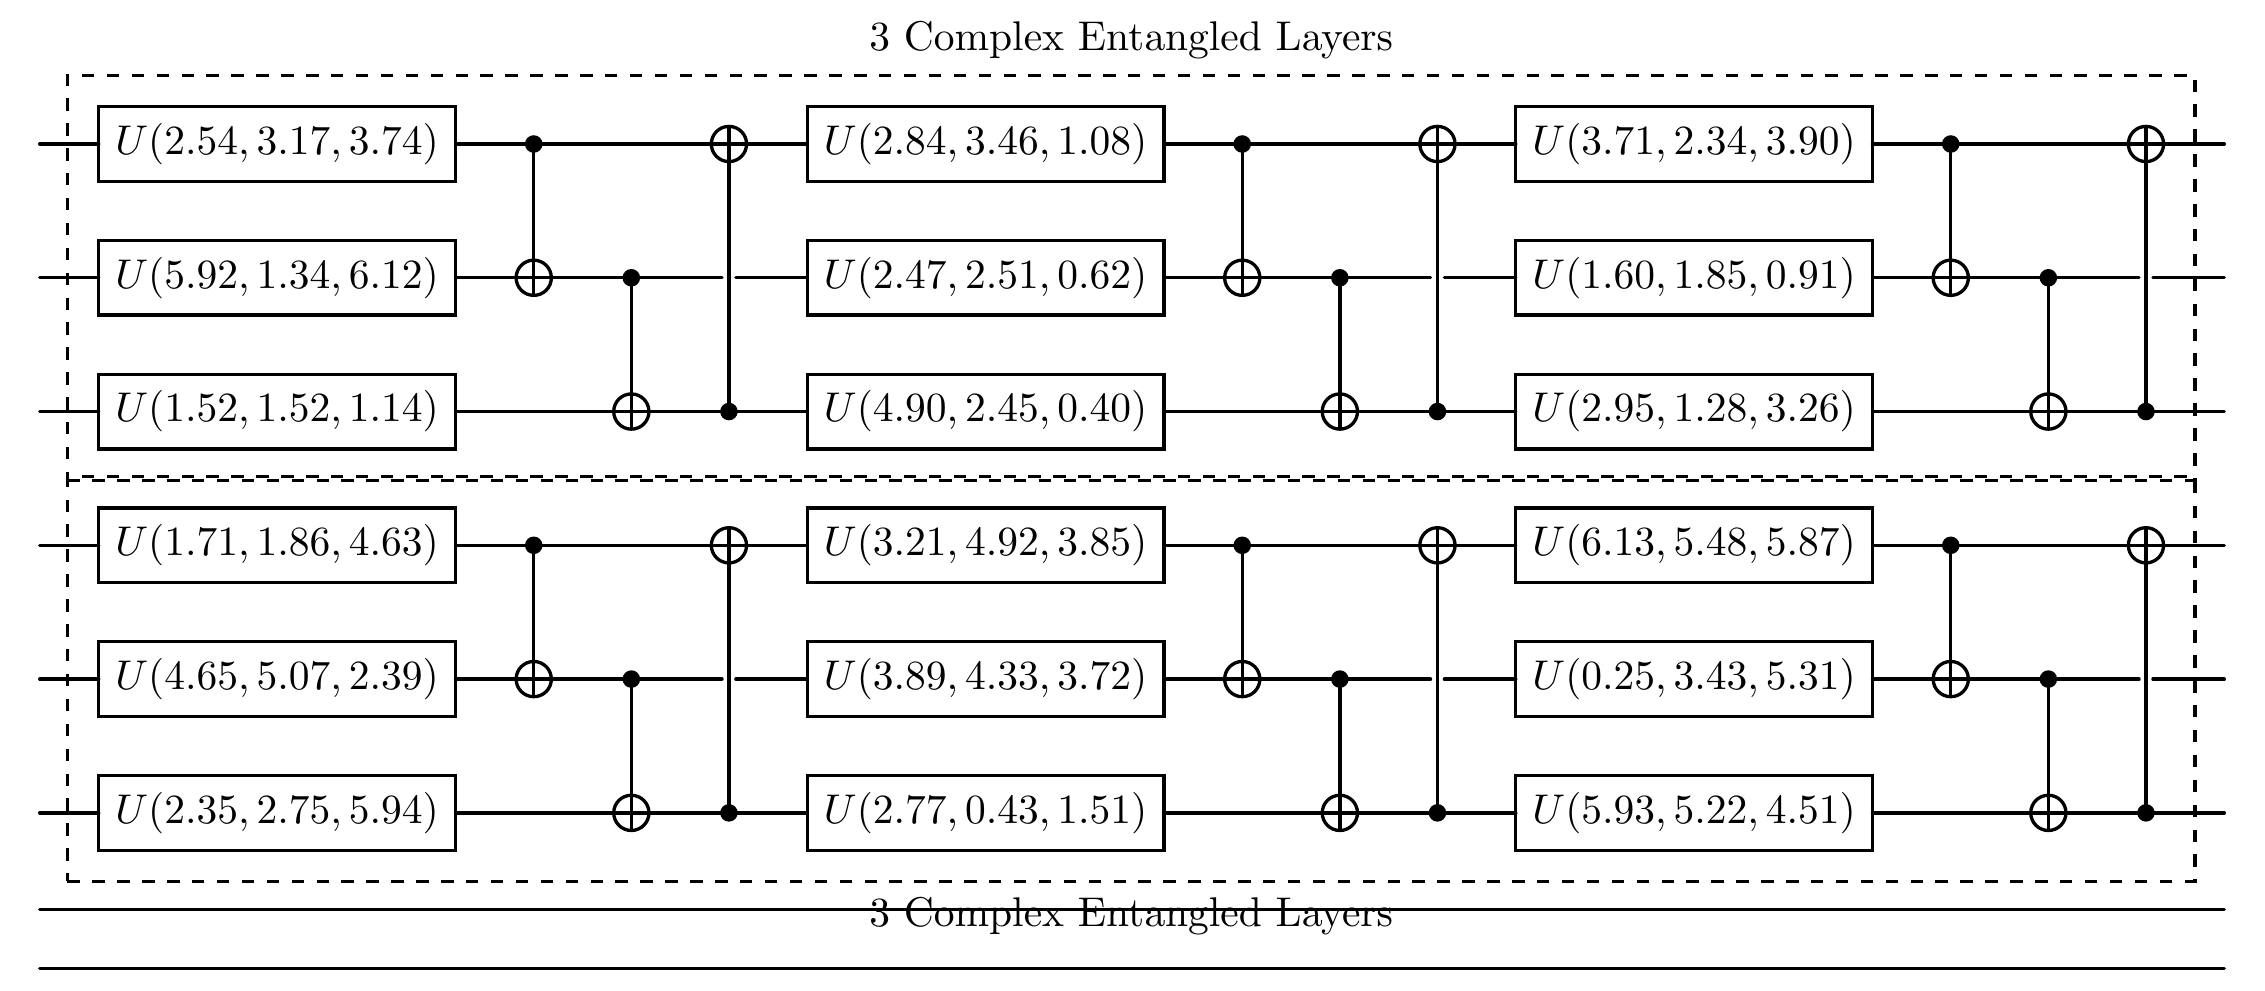

None


  0%|          | 0/50 [00:00<?, ?it/s]

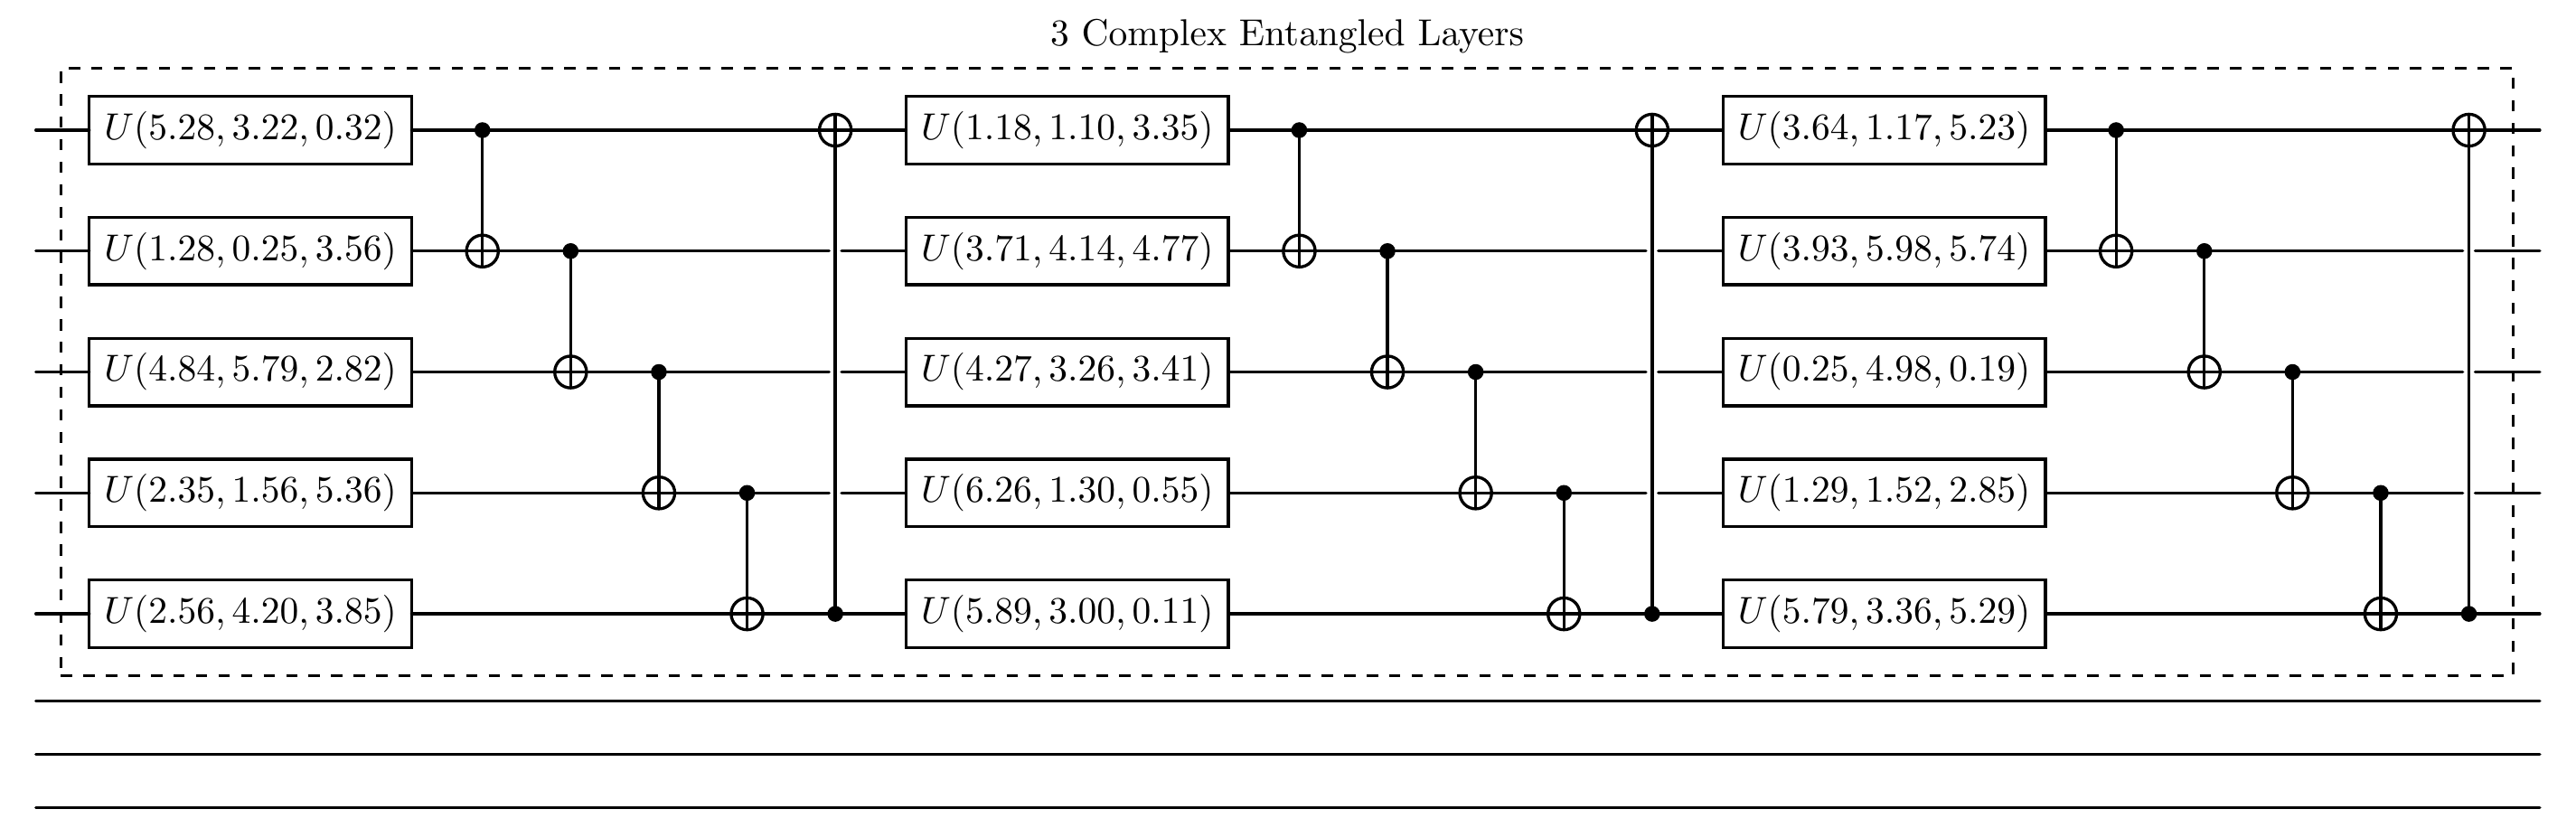

None


  0%|          | 0/50 [00:00<?, ?it/s]

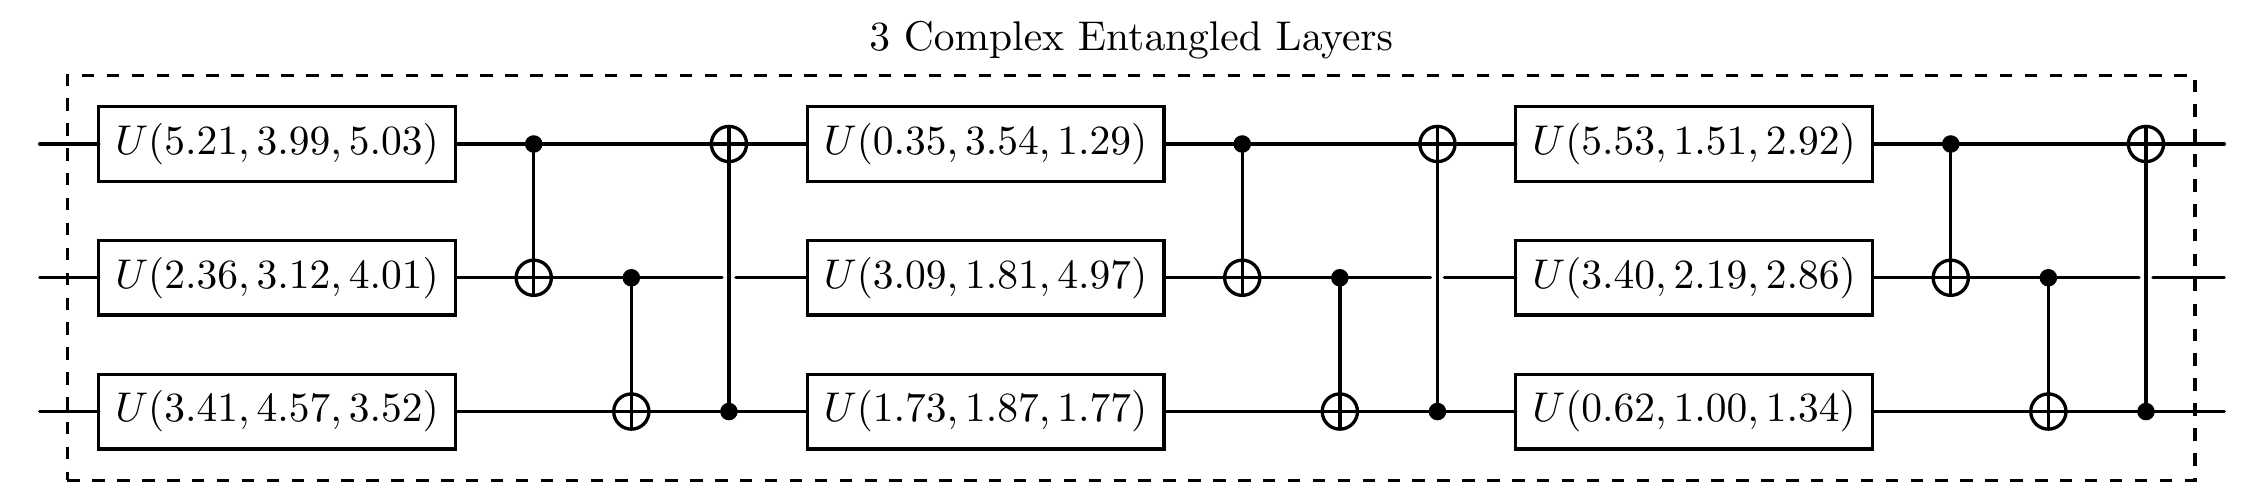

  2%|▏         | 1/50 [00:04<03:36,  4.43s/it]

None


  0%|          | 0/50 [00:00<?, ?it/s]

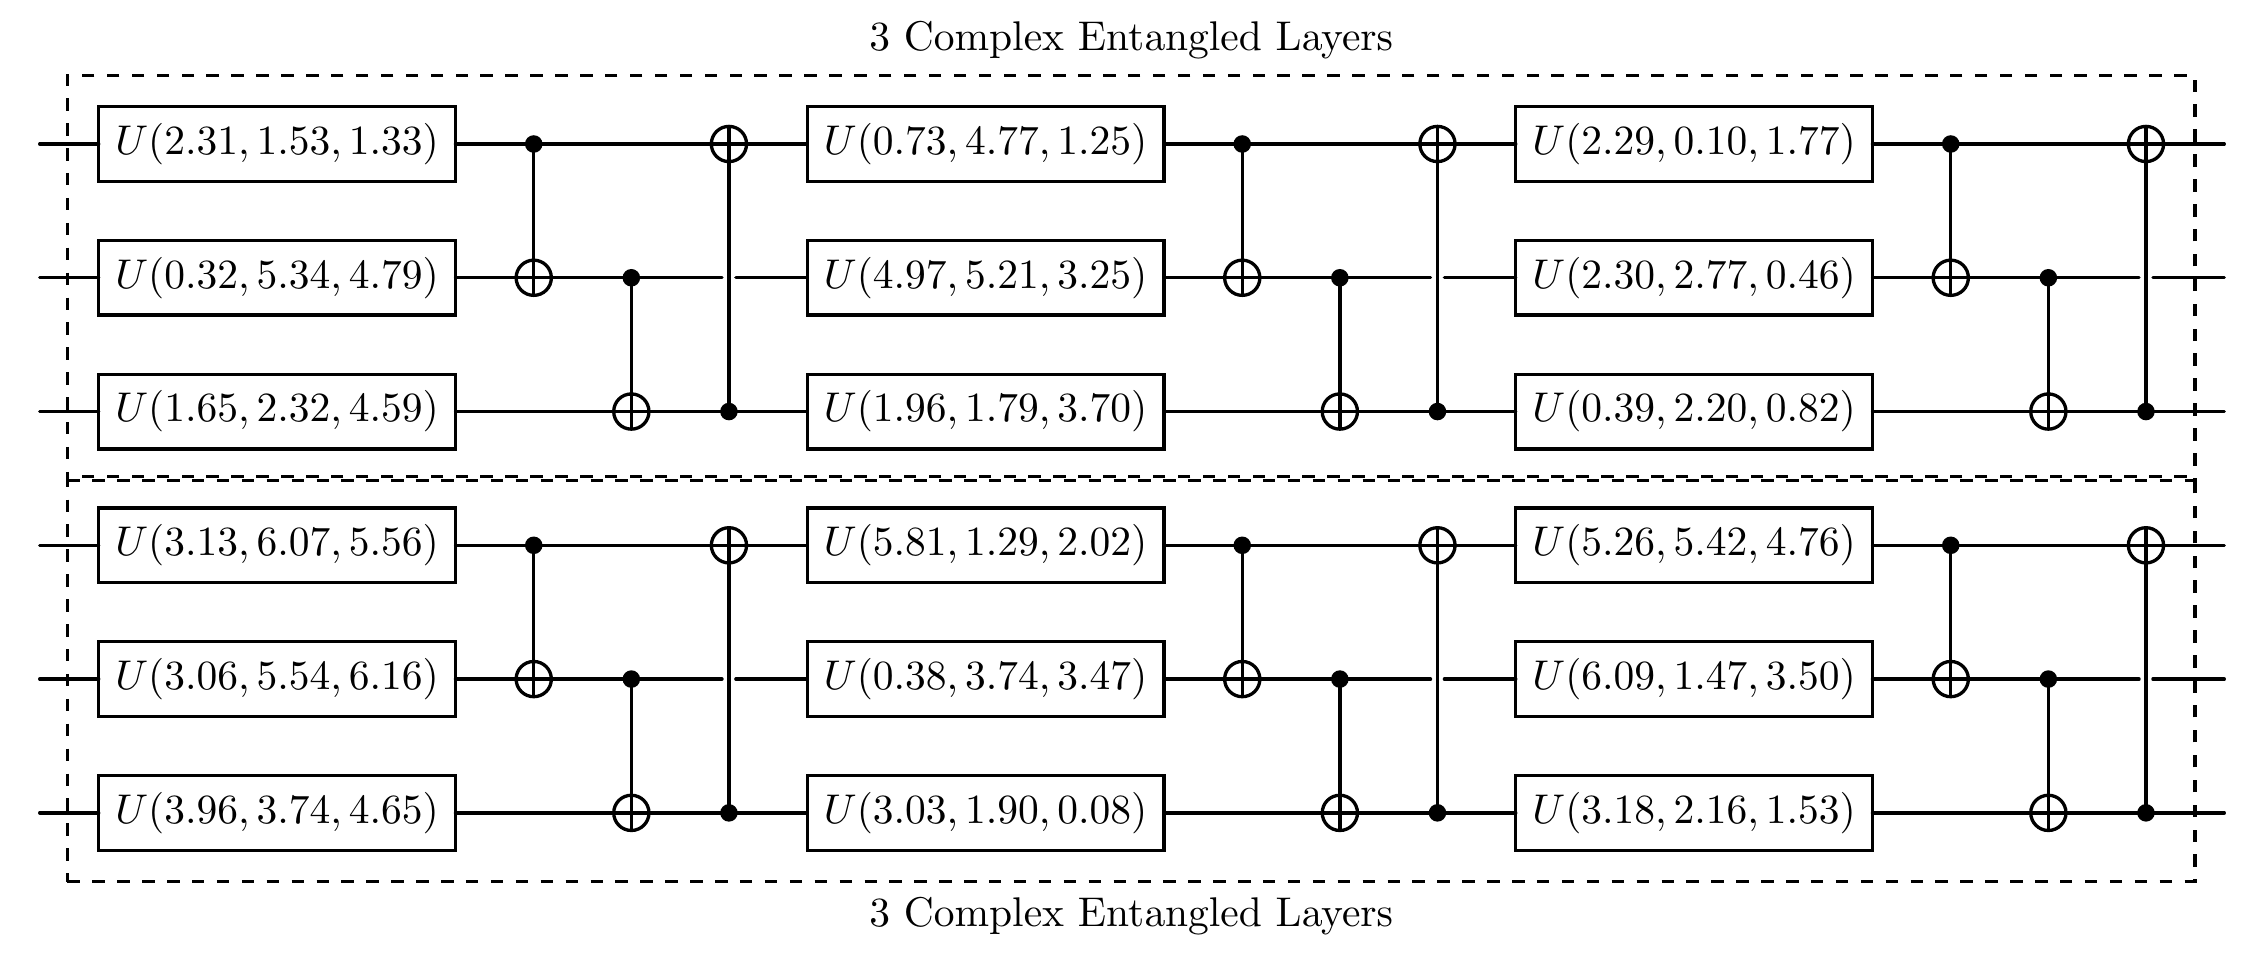

None


  0%|          | 0/50 [00:00<?, ?it/s]

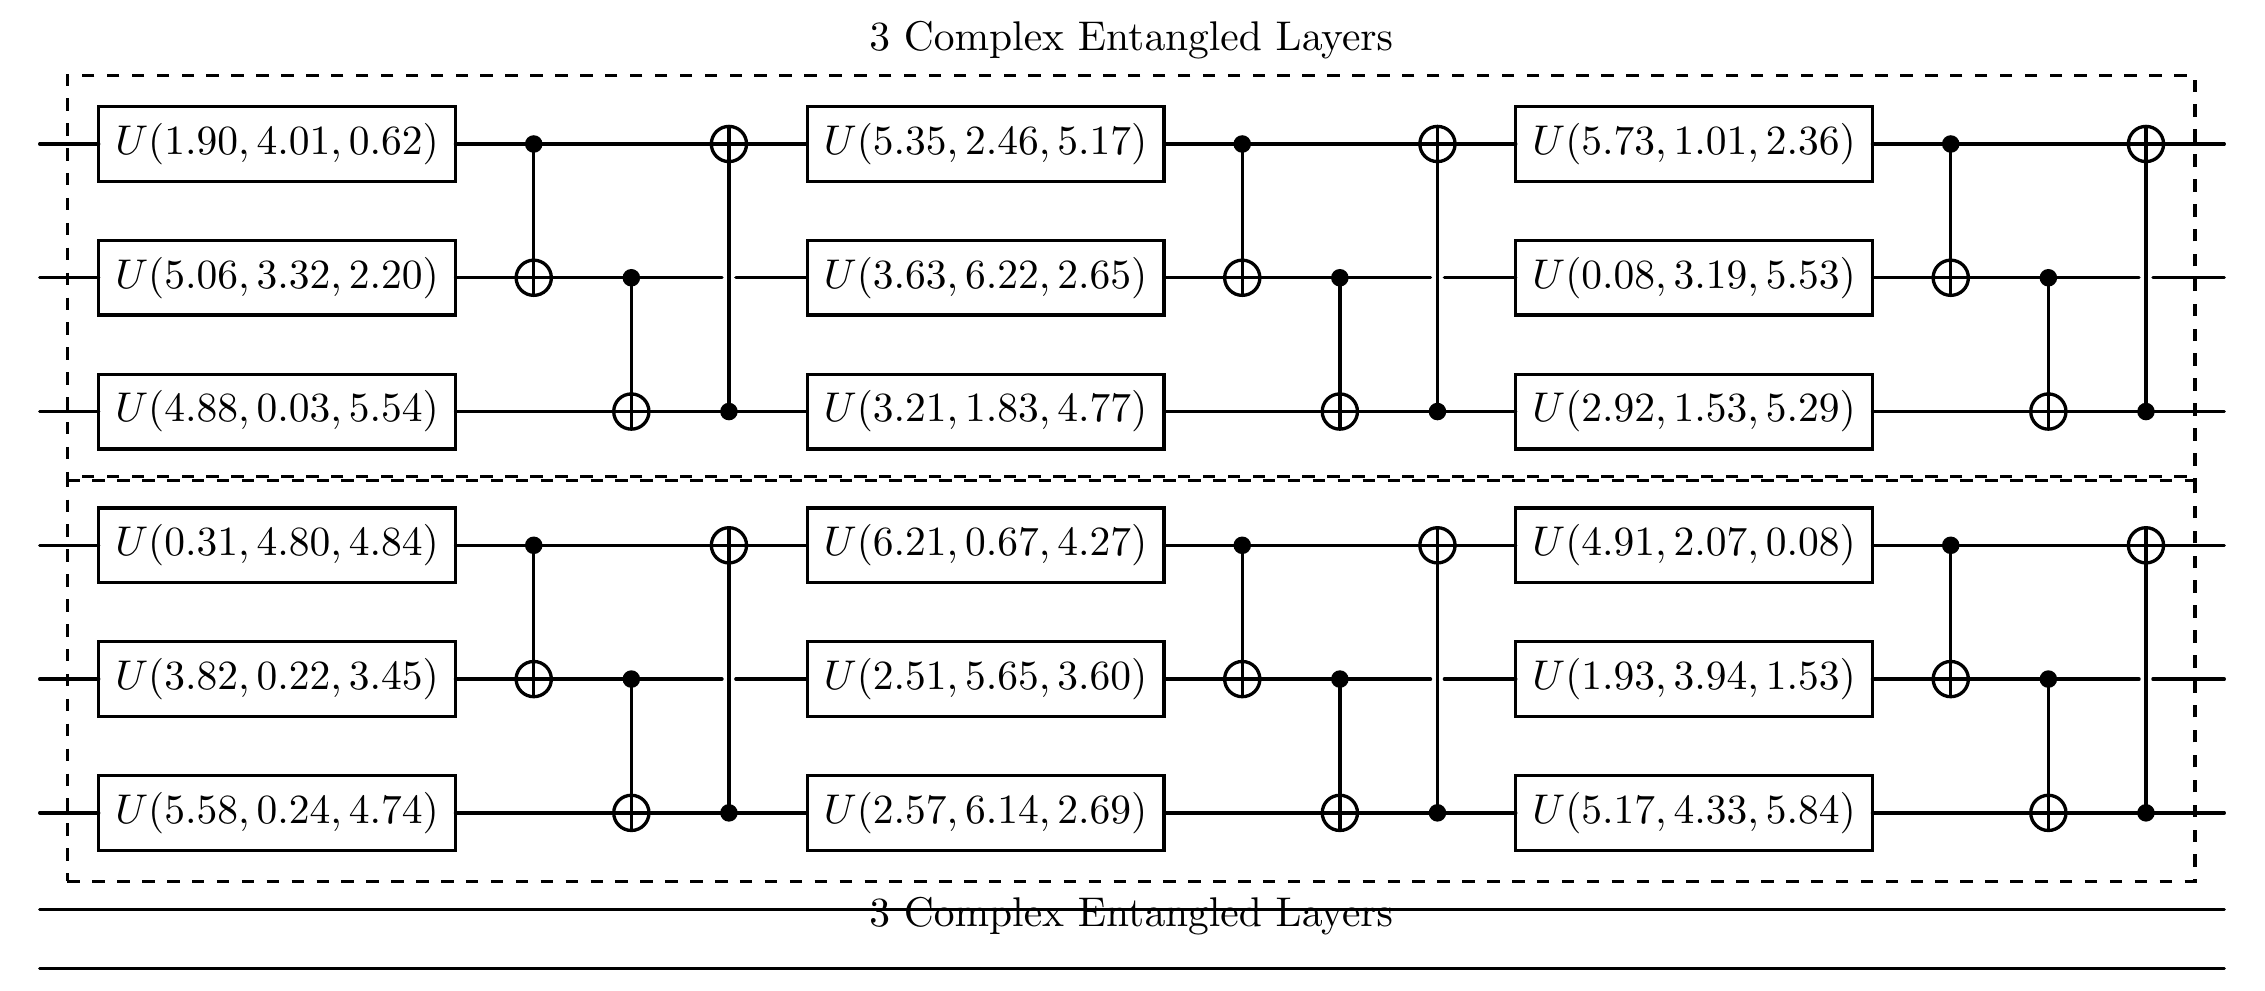

None


  0%|          | 0/50 [00:00<?, ?it/s]

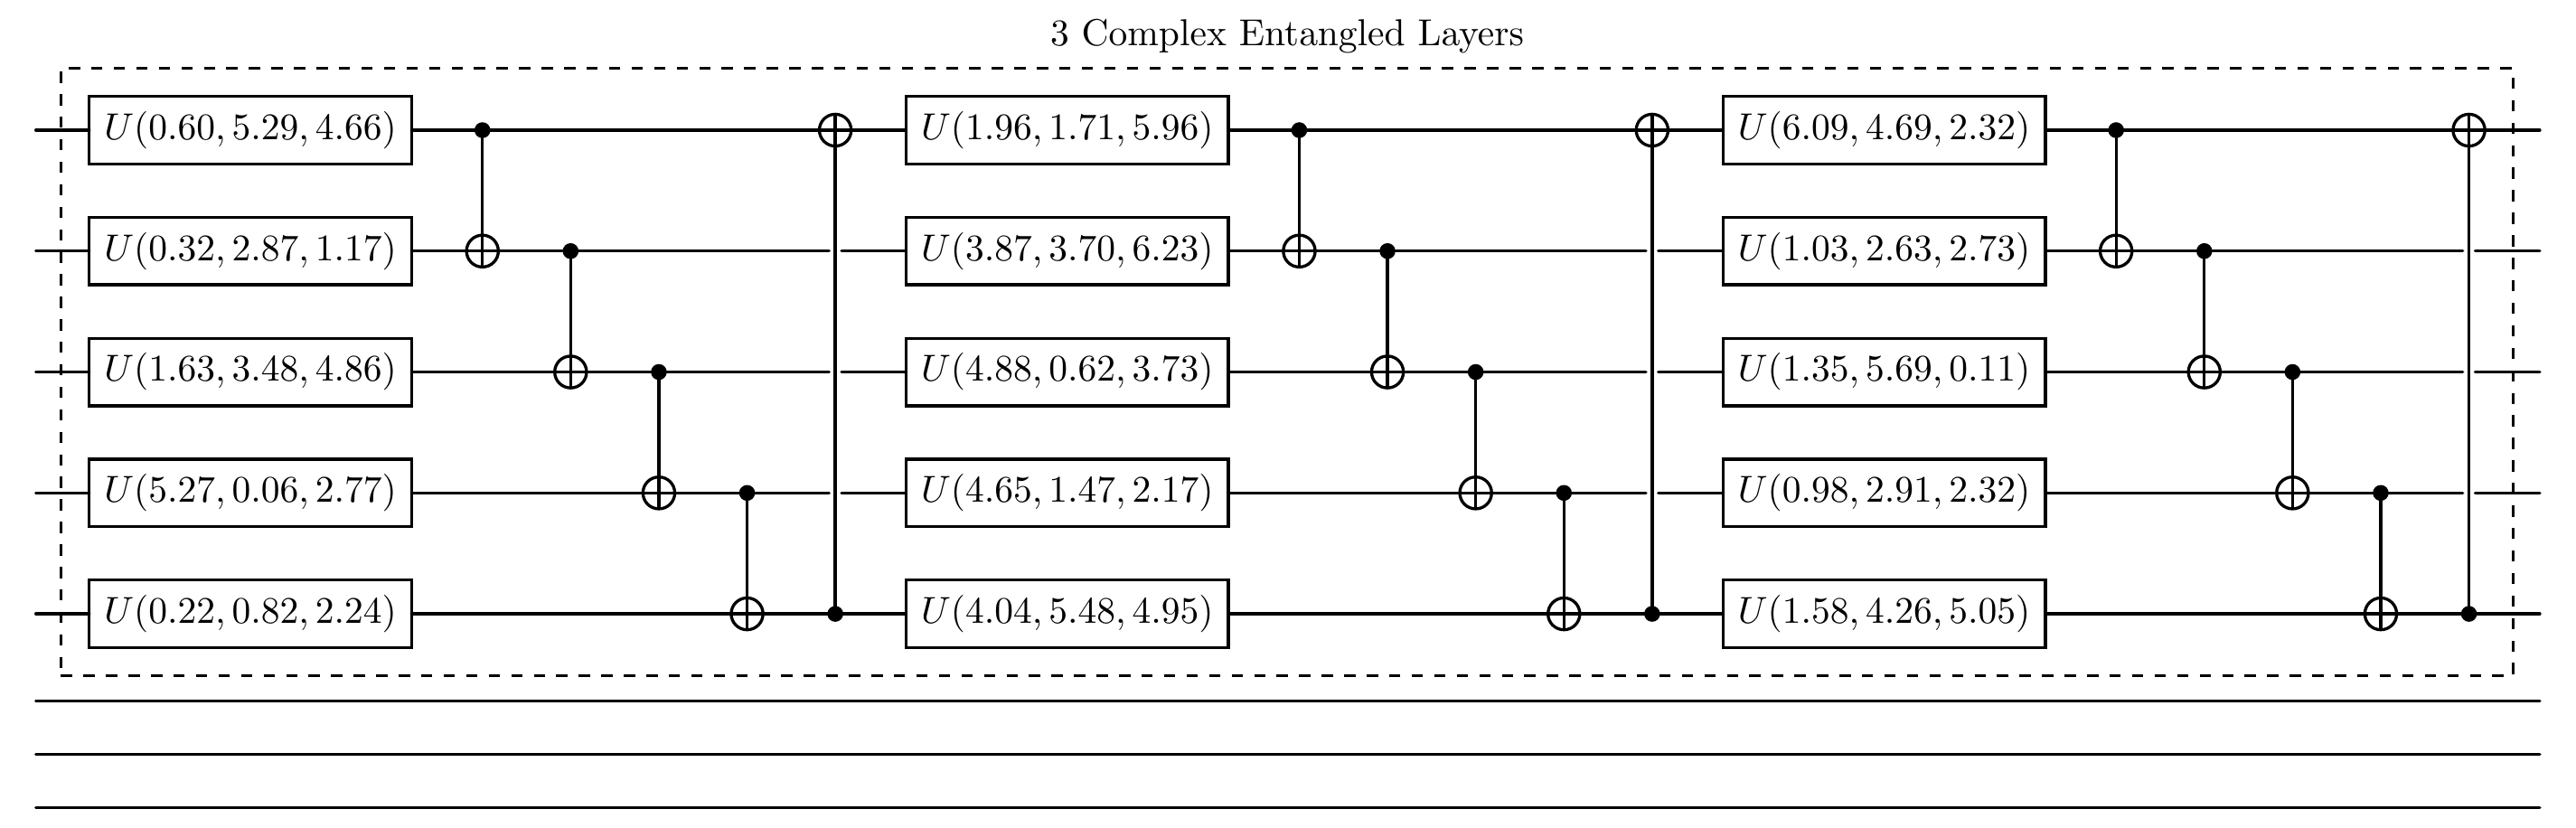

None


100%|██████████| 50/50 [06:31<00:00,  7.82s/it]


In [14]:

for itr in range(10):   
    sample = 50

    # nLk_list = [(3,1,2),(3,2,2),(3,4,2), (4,1,3),(4,2,3),(4,4,3),(4,16,3), (6,1,5),(6,2,5),(6,4,5),(6,16,5),]

    # nLk_list = [(3,8,2), (4,8,3), (6,8,5)]
    nLk_list = [(3,8,3), (6,8,3), (8,8,3), (8,8,5)]




    Z = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex128)

    for n,L,k in nLk_list:
        loss_list, grad_list = [], []

        rho = zero_state(n).density_matrix
        O_list = []

        for j in range(n):
            prev_mat = torch.eye(2**j, dtype=torch.complex128)
            next_mat = torch.eye(2**(n-j-1), dtype=torch.complex128)
            O = torch.kron(torch.kron(prev_mat,Z),next_mat)
            O_list.append(O)


        for j in tqdm(range(sample)):
            simple_lcunn = lcqnn_model(n,L,k)
            if j==0:
                print(simple_lcunn[0].plot(include_empty=True))

            opt = torch.optim.Adam(lr=0.1, params=simple_lcunn.parameters())
            
            # gradient
            opt.zero_grad()
            loss = get_cost(L, simple_lcunn, rho, O_list) # compute loss
            loss.backward()
            opt.step()
            
            loss_list.append(loss.item())

            grad_list_ = []
            for param in simple_lcunn.parameters():
                # print(torch.flatten(param.grad))
                grad_list_.append(torch.flatten(param.grad))
                    
            grad_list.append(np.concatenate(grad_list_))

        np.save(f'./grad_exp/sample{itr+1}_n{n}_L{L}_k{k}.npy', np.array(grad_list))